In [26]:
!apt update
!apt install python-opengl xvfb -y
!pip install gym[box2d] pyvirtualdisplay==3.0 tqdm

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:8 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done
Building dependency tree       
Reading state infor

In [19]:
import gym

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from pathlib import Path

from torch.distributions import Categorical
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm


env_name = "LunarLander-v2"

env = gym.make(env_name)
env.reset()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
class PolicyNetwork(torch.nn.Module):
  def __init__(self, n=4, in_dim=128):
    super(PolicyNetwork, self).__init__()

    self.fc1 = torch.nn.Linear(in_dim, 128)
    self.fc2 = torch.nn.Linear(128, 128)
    self.fc3 = torch.nn.Linear(128, 128)

    self.fc4 = torch.nn.Linear(128, n)
    self.l_relu = torch.nn.LeakyReLU(0.1)

  def forward(self, x):
    x = self.l_relu(self.fc1(x))
    x = self.l_relu(self.fc2(x))
    x = self.l_relu(self.fc3(x))

    y = self.fc4(x)
    y = F.softmax(y, dim=-1)
    return y
  
  def sample_action(self, state):
    if not state is torch.Tensor:
      state = torch.from_numpy(state).float().to(device)

    if len(state.size()) == 1:
      state = state.unsqueeze(0)
    
    y = self(state)
    dist = Categorical(y)
    action = dist.sample()
    log_probability = dist.log_prob(action)
    return action.item(), log_probability.item()
    
  def best_action(self, state):
    if not state is torch.Tensor:
      state = torch.from_numpy(state).float().to(device)
    if len(state.size()) == 1:
      state = state.unsqueeze(0)

    y = self(state).squeeze()
    action = torch.argmax(y)
    return action.item()

  def evaluate_actions(self, states, actions):
    y = self(states)
    dist = Categorical(y)
    entropy = dist.entropy()
    log_probabilities = dist.log_prob(actions)
    return log_probabilities, entropy


In [ ]:
class ValueNetwork(torch.nn.Module):
  def __init__(self, in_dim=128):
    super(ValueNetwork, self).__init__()

    self.fc1 = torch.nn.Linear(in_dim, 128)
    self.fc2 = torch.nn.Linear(128, 128)
    self.fc3 = torch.nn.Linear(128, 128)

    self.fc4 = torch.nn.Linear(128, 1)

    self.l_relu = torch.nn.LeakyReLU(0.1)

  def forward(self, x):

    x = self.l_relu(self.fc1(x))
    x = self.l_relu(self.fc2(x))
    x = self.l_relu(self.fc3(x))

    y = self.fc4(x)

    return y.squeeze(1)

  def state_value(self, state):

    if not state is torch.Tensor:
        state = torch.from_numpy(state).float().to(device)

    if len(state.size()) == 1:
        state = state.unsqueeze(0)

    y = self(state)

    return y.item()

In [ ]:
def train_value_network(value_model, value_optimizer, data_loader, epochs=4):
  epochs_losses = []

  for i in range(epochs):

    losses = []

    for observations, _, _, _, rewards_to_go in data_loader:
      observations = observations.float().to(device)
      rewards_to_go = rewards_to_go.float().to(device)

      value_optimizer.zero_grad()

      values = value_model(observations)

      loss = F.mse_loss(values, rewards_to_go)

      loss.backward()

      value_optimizer.step()

      losses.append(loss.item())

    mean_loss = np.mean(losses)

    epochs_losses.append(mean_loss)

  return epochs_losses


def ac_loss(new_log_probabilities, old_log_probabilities, advantages, epsilon_clip=0.2):
  probability_ratios = torch.exp(new_log_probabilities - old_log_probabilities)
  clipped_probabiliy_ratios = torch.clamp(
      probability_ratios, 1 - epsilon_clip, 1 + epsilon_clip
  )

  surrogate_1 = probability_ratios * advantages
  surrogate_2 = clipped_probabiliy_ratios * advantages

  return -torch.min(surrogate_1, surrogate_2)


def train_policy_network(
    policy_model, policy_optimizer, data_loader, epochs=4, clip=0.2
):
  epochs_losses = []

  c1 = 0.01

  for i in range(epochs):

      losses = []

      for observations, actions, advantages, log_probabilities, _ in data_loader:
          observations = observations.float().to(device)
          actions = actions.long().to(device)
          advantages = advantages.float().to(device)
          old_log_probabilities = log_probabilities.float().to(device)

          policy_optimizer.zero_grad()

          new_log_probabilities, entropy = policy_model.evaluate_actions(
              observations, actions
          )

          loss = (
              ac_loss(
                  new_log_probabilities,
                  old_log_probabilities,
                  advantages,
                  epsilon_clip=clip,
              ).mean()
              - c1 * entropy.mean()
          )

          loss.backward()

          policy_optimizer.step()

          losses.append(loss.item())

      mean_loss = np.mean(losses)

      epochs_losses.append(mean_loss)

  return epochs_losses

In [ ]:
def cumulative_sum(array, gamma=1.0):
    curr = 0
    cumulative_array = []

    for a in array[::-1]:
        curr = a + gamma * curr
        cumulative_array.append(curr)

    return cumulative_array[::-1]


class Episode:
    def __init__(self, gamma=0.99, lambd=0.95):
        self.observations = []
        self.actions = []
        self.advantages = []
        self.rewards = []
        self.rewards_to_go = []
        self.values = []
        self.log_probabilities = []
        self.gamma = gamma
        self.lambd = lambd

    def append(
        self, observation, action, reward, value, log_probability, reward_scale=20
    ):
        self.observations.append(observation)
        self.actions.append(action)
        self.rewards.append(reward / reward_scale)
        self.values.append(value)
        self.log_probabilities.append(log_probability)

    def end_episode(self, last_value):
        rewards = np.array(self.rewards + [last_value])
        values = np.array(self.values + [last_value])

        deltas = rewards[:-1] + self.gamma * values[1:] - values[:-1]

        self.advantages = cumulative_sum(deltas.tolist(), gamma=self.gamma * self.lambd)

        self.rewards_to_go = cumulative_sum(rewards.tolist(), gamma=self.gamma)[:-1]


def normalize_list(array):
    array = np.array(array)
    array = (array - np.mean(array)) / (np.std(array) + 1e-5)
    return array.tolist()


class History(Dataset):
    def __init__(self):
        self.episodes = []
        self.observations = []
        self.actions = []
        self.advantages = []
        self.rewards = []
        self.rewards_to_go = []
        self.log_probabilities = []

    def free_memory(self):
        del self.episodes[:]
        del self.observations[:]
        del self.actions[:]
        del self.advantages[:]
        del self.rewards[:]
        del self.rewards_to_go[:]
        del self.log_probabilities[:]

    def add_episode(self, episode):
        self.episodes.append(episode)

    def build_dataset(self):
        for episode in self.episodes:
            self.observations += episode.observations
            self.actions += episode.actions
            self.advantages += episode.advantages
            self.rewards += episode.rewards
            self.rewards_to_go += episode.rewards_to_go
            self.log_probabilities += episode.log_probabilities

        assert (
            len(
                {
                    len(self.observations),
                    len(self.actions),
                    len(self.advantages),
                    len(self.rewards),
                    len(self.rewards_to_go),
                    len(self.log_probabilities),
                }
            )
            == 1
        )

        self.advantages = normalize_list(self.advantages)

    def __len__(self):
        return len(self.observations)

    def __getitem__(self, idx):
        return (
            self.observations[idx],
            self.actions[idx],
            self.advantages[idx],
            self.log_probabilities[idx],
            self.rewards_to_go[idx],
        )

In [14]:
env_name="LunarLander-v2"
reward_scale=20.0
clip=0.2
log_dir="../logs"
learning_rate=0.001
state_scale=1.0
writer = SummaryWriter(log_dir=log_dir, filename_suffix=env_name, comment=env_name)

env = gym.make(env_name)
observation = env.reset()

n_actions = env.action_space.n
feature_dim = observation.size

value_model = ValueNetwork(in_dim=feature_dim).to(device)
value_optimizer = optim.Adam(value_model.parameters(), lr=learning_rate)

policy_model = PolicyNetwork(in_dim=feature_dim, n=n_actions).to(device)
policy_optimizer = optim.Adam(policy_model.parameters(), lr=learning_rate)

n_epoch = 4

max_episodes = 20
max_timesteps = 400

batch_size = 32

max_iterations = 200

history = History()

epoch_ite = 0
episode_ite = 0


# Save total and final rewards in an array
avg_total_rewards, avg_final_rewards = [], []
prg_bar = tqdm(range(max_iterations))

for ite in prg_bar:

  total_rewards, final_rewards = [], []

  if ite % 50 == 0:
      torch.save(
          policy_model.state_dict(),
          Path(log_dir) / (env_name + f"_{str(ite)}_policy.pth"),
      )
      torch.save(
          value_model.state_dict(),
          Path(log_dir) / (env_name + f"_{str(ite)}_value.pth"),
      )

  for episode_i in range(max_episodes):

      observation = env.reset()
      episode = Episode()
      total_reward, total_step = 0, 0

      # for timestep in range(max_timesteps):
      # cancel max_timsteps limit
      while True:

          action, log_probability = policy_model.sample_action(
              observation / state_scale
          )
          value = value_model.state_value(observation / state_scale)

          new_observation, reward, done, info = env.step(action)

          episode.append(
              observation=observation / state_scale,
              action=action,
              reward=reward,
              value=value,
              log_probability=log_probability,
              reward_scale=reward_scale,
          )

          observation = new_observation
          total_reward += reward
          total_step += 1

          if done:
              final_rewards.append(reward)
              total_rewards.append(total_reward)
              episode.end_episode(last_value=0)
              break

          # if timestep == max_timesteps - 1:
          #     value = value_model.state_value(observation / state_scale)
          #     episode.end_episode(last_value=value)

      episode_ite += 1
      #writer.add_scalar(
      #    "Average Episode Reward",
      #    reward_scale * np.sum(episode.rewards),
      #    episode_ite,
      #)
      # print(
      #     "Average Episode Reward",
      #     reward_scale * np.sum(episode.rewards),
      #     episode_ite,
      # )
      #writer.add_scalar(
      #    "Average Probabilities",
      #    np.exp(np.mean(episode.log_probabilities)),
      #    episode_ite,
      #)
      # print(
      #     "Average Probabilities",
      #     np.exp(np.mean(episode.log_probabilities)),
      #     episode_ite,
      # )

      history.add_episode(episode)

  history.build_dataset()
  data_loader = DataLoader(history, batch_size=batch_size, shuffle=True)

  policy_loss = train_policy_network(
      policy_model, policy_optimizer, data_loader, epochs=n_epoch, clip=clip
  )

  value_loss = train_value_network(
      value_model, value_optimizer, data_loader, epochs=n_epoch
  )

  for p_l, v_l in zip(policy_loss, value_loss):
      epoch_ite += 1
      # writer.add_scalar("Policy Loss", p_l, epoch_ite)
      # writer.add_scalar("Value Loss", v_l, epoch_ite)
      # print("Policy Loss", p_l, epoch_ite)
      # print("Value Loss", v_l, epoch_ite)

  history.free_memory()

  avg_total_reward = sum(total_rewards) / len(total_rewards)
  avg_final_reward = sum(final_rewards) / len(final_rewards)
  avg_total_rewards.append(avg_total_reward)
  avg_final_rewards.append(avg_final_reward)
  prg_bar.set_description(f"Total: {avg_total_reward: 4.1f}, Final: {avg_final_reward: 4.1f}")

Total:  248.8, Final:  75.5: 100%|██████████| 200/200 [48:51<00:00, 14.66s/it]


In [ ]:
main(
    reward_scale=20.0,
    clip=0.2,
    env_name="LunarLander-v2",
    learning_rate=0.001,
    state_scale=1.0,
    log_dir="logs/Lunar"
)

  0%|          | 0/200 [00:00<?, ?it/s]

Average Episode Reward -182.26356598071914 1
Average Probabilities 0.25016181924144104 1
Average Episode Reward -258.1150140605148 2
Average Probabilities 0.24953616958387606 2
Average Episode Reward -257.1329142443988 3
Average Probabilities 0.2517416319661295 3
Average Episode Reward -72.87270620844328 4
Average Probabilities 0.24884923771498432 4
Average Episode Reward -88.66546035829779 5
Average Probabilities 0.2507355192385921 5
Average Episode Reward -121.41128169479663 6
Average Probabilities 0.25069411022671695 6
Average Episode Reward -289.07402454363375 7
Average Probabilities 0.25038794189978913 7
Average Episode Reward -101.73257534149242 8
Average Probabilities 0.25073607125594416 8
Average Episode Reward -97.00180850741363 9
Average Probabilities 0.24993911219098336 9
Average Episode Reward -130.3542472259487 10
Average Probabilities 0.2503560924676109 10
Average Episode Reward -92.08251343604147 11
Average Probabilities 0.2505409868769924 11
Average Episode Reward -17.9

  0%|          | 1/200 [00:02<08:21,  2.52s/it]

Policy Loss -0.015976003299538907 1
Value Loss 9.649551171522875 1
Policy Loss -0.02287473696140716 2
Value Loss 4.048649574701603 2
Policy Loss -0.026547023596671913 3
Value Loss 3.2897454729446998 3
Policy Loss -0.031099447855152763 4
Value Loss 2.8837273992024937 4
Average Episode Reward -153.46082736699967 21
Average Probabilities 0.25065464557959477 21
Average Episode Reward -91.35231614646436 22
Average Probabilities 0.2540411844089081 22
Average Episode Reward -103.37567873864856 23
Average Probabilities 0.2586533129070506 23
Average Episode Reward -168.21539907442627 24
Average Probabilities 0.25161023157772794 24
Average Episode Reward -127.37372796397167 25
Average Probabilities 0.2547367941772086 25
Average Episode Reward -104.8087449606079 26
Average Probabilities 0.2565133858370222 26
Average Episode Reward -346.4490111444004 27
Average Probabilities 0.25439672772474675 27
Average Episode Reward -112.74640955842878 28
Average Probabilities 0.2566920668136617 28
Average Epi

  1%|          | 2/200 [00:05<08:24,  2.55s/it]

Policy Loss -0.005966435389762575 5
Value Loss 3.028361450542103 5
Policy Loss -0.02371478747915138 6
Value Loss 2.1281492818485606 6
Policy Loss -0.01737980544567108 7
Value Loss 1.8700910546562888 7
Policy Loss -0.026014037684283474 8
Value Loss 1.5817785983735866 8
Average Episode Reward -108.37463659072795 41
Average Probabilities 0.2683147117851937 41
Average Episode Reward -90.86946787106314 42
Average Probabilities 0.25617476421475743 42
Average Episode Reward -131.91737458047805 43
Average Probabilities 0.2535706194723199 43
Average Episode Reward -33.98599815425619 44
Average Probabilities 0.2555250986737454 44
Average Episode Reward -142.0774415515614 45
Average Probabilities 0.2582223662385991 45
Average Episode Reward -313.8106510284334 46
Average Probabilities 0.25543547180351167 46
Average Episode Reward -113.56197207102775 47
Average Probabilities 0.2549492370591098 47
Average Episode Reward -110.92856441809855 48
Average Probabilities 0.24577980137207572 48
Average Epis

  2%|▏         | 3/200 [00:07<08:45,  2.67s/it]

Policy Loss -0.013708740039246863 9
Value Loss 4.684326192428326 9
Policy Loss -0.026911030684051842 10
Value Loss 3.8714409100598304 10
Policy Loss -0.028097771188436912 11
Value Loss 3.404464230455201 11
Policy Loss -0.03134603117560518 12
Value Loss 2.9374765013826303 12
Average Episode Reward -108.7406150662713 61
Average Probabilities 0.26573379339158415 61
Average Episode Reward -102.84781103491076 62
Average Probabilities 0.2583060193055458 62
Average Episode Reward -38.9525233382405 63
Average Probabilities 0.2576932162832071 63
Average Episode Reward -37.72547159350469 64
Average Probabilities 0.25804989922809773 64
Average Episode Reward -130.18196018388753 65
Average Probabilities 0.26757447574282756 65
Average Episode Reward -95.67155917253238 66
Average Probabilities 0.2565417492395163 66
Average Episode Reward -104.77440461823399 67
Average Probabilities 0.2717032883158659 67
Average Episode Reward -102.97482150858285 68
Average Probabilities 0.2579369851026997 68
Average

  2%|▏         | 4/200 [00:10<09:06,  2.79s/it]

Policy Loss -0.016221237747724784 13
Value Loss 4.024216247817217 13
Policy Loss -0.029412536313599448 14
Value Loss 2.8083781064566917 14
Policy Loss -0.054119896885575884 15
Value Loss 2.429246607473341 15
Policy Loss -0.038267414890608545 16
Value Loss 2.023050073849953 16
Average Episode Reward -107.73110876357315 81
Average Probabilities 0.2605898113172452 81
Average Episode Reward -57.16364158721789 82
Average Probabilities 0.2578253088289965 82
Average Episode Reward -146.74670776224764 83
Average Probabilities 0.262385324639731 83
Average Episode Reward -70.84878914295959 84
Average Probabilities 0.25755450552085357 84
Average Episode Reward -123.3156956104693 85
Average Probabilities 0.2459154770612445 85
Average Episode Reward -103.08521391536789 86
Average Probabilities 0.2597737436462006 86
Average Episode Reward -95.85561037499657 87
Average Probabilities 0.2514815177197774 87
Average Episode Reward -218.2097361362722 88
Average Probabilities 0.2783640428875357 88
Average 

  2%|▎         | 5/200 [00:13<09:12,  2.83s/it]

Policy Loss -0.015501193619067115 17
Value Loss 3.26014050415584 17
Policy Loss -0.025312954293830053 18
Value Loss 2.3980943358370235 18
Policy Loss -0.02994842569543315 19
Value Loss 2.095263669533389 19
Policy Loss -0.029392595020388917 20
Value Loss 1.8971493488975935 20
Average Episode Reward -204.4352143411153 101
Average Probabilities 0.2723575101883337 101
Average Episode Reward -176.30224188025682 102
Average Probabilities 0.26391620494497087 102
Average Episode Reward -89.77016831436254 103
Average Probabilities 0.24412122276466683 103
Average Episode Reward -89.37694800703807 104
Average Probabilities 0.2681357448612712 104
Average Episode Reward -143.37502922483034 105
Average Probabilities 0.25822631125447576 105
Average Episode Reward -60.77356060752909 106
Average Probabilities 0.26862581147794373 106
Average Episode Reward -125.3798902057768 107
Average Probabilities 0.2715278828199181 107
Average Episode Reward -136.48567799015436 108
Average Probabilities 0.2542817524

  3%|▎         | 6/200 [00:16<09:20,  2.89s/it]

Policy Loss -0.027690023824106902 21
Value Loss 2.6674277428537607 21
Policy Loss -0.030095050169620663 22
Value Loss 2.327164838090539 22
Policy Loss -0.035388523669098504 23
Value Loss 2.177470438182354 23
Policy Loss -0.03102820237108972 24
Value Loss 1.9998126225546002 24
Average Episode Reward -226.13533774962846 121
Average Probabilities 0.25473866045633403 121
Average Episode Reward -70.18422264247427 122
Average Probabilities 0.29285517082492435 122
Average Episode Reward -26.47359098920664 123
Average Probabilities 0.30333768599445254 123
Average Episode Reward -59.376838226624706 124
Average Probabilities 0.2817447252838062 124
Average Episode Reward -120.94457415003336 125
Average Probabilities 0.27776896365387876 125
Average Episode Reward -97.37324598813609 126
Average Probabilities 0.27461105674899455 126
Average Episode Reward -107.26813898881076 127
Average Probabilities 0.2644020970336506 127
Average Episode Reward -110.70695092324979 128
Average Probabilities 0.279900

  4%|▎         | 7/200 [00:20<10:13,  3.18s/it]

Policy Loss -0.011523798991663333 25
Value Loss 2.1436172326405845 25
Policy Loss -0.018686518849184115 26
Value Loss 1.4373181133698194 26
Policy Loss -0.02949794766325981 27
Value Loss 1.1619945512368128 27
Policy Loss -0.02651353232944623 28
Value Loss 0.9803283306268545 28
Average Episode Reward 19.11567863046246 141
Average Probabilities 0.29610035334881857 141
Average Episode Reward 4.2586816547341035 142
Average Probabilities 0.30150398342752077 142
Average Episode Reward -84.63732366006668 143
Average Probabilities 0.2889902262283388 143
Average Episode Reward -119.55627216833938 144
Average Probabilities 0.2868311291340076 144
Average Episode Reward -85.06971164247197 145
Average Probabilities 0.28623305856111075 145
Average Episode Reward -87.94443374690893 146
Average Probabilities 0.2747780440914717 146
Average Episode Reward -53.68810004149644 147
Average Probabilities 0.28301844040324375 147
Average Episode Reward -126.29252809840189 148
Average Probabilities 0.2920966383

  4%|▍         | 8/200 [00:25<11:55,  3.73s/it]

Policy Loss -0.017349176880235625 29
Value Loss 2.7721535075794566 29
Policy Loss -0.019654689723569336 30
Value Loss 1.877094562005515 30
Policy Loss -0.025205054762538034 31
Value Loss 1.4357428466430817 31
Policy Loss -0.026412233926656873 32
Value Loss 1.0359833950948234 32
Average Episode Reward -22.030169088360864 161
Average Probabilities 0.2850198094376496 161
Average Episode Reward -17.77984536375797 162
Average Probabilities 0.30045206196468416 162
Average Episode Reward -126.55359388909577 163
Average Probabilities 0.2760109557048594 163
Average Episode Reward -41.05268402239805 164
Average Probabilities 0.2943660520019412 164
Average Episode Reward -85.88370270964072 165
Average Probabilities 0.2767351110798 165
Average Episode Reward -60.00777324319503 166
Average Probabilities 0.29922940996234587 166
Average Episode Reward -117.9522133362112 167
Average Probabilities 0.2715116318907908 167
Average Episode Reward -105.4452278245602 168
Average Probabilities 0.2901867189459

  4%|▍         | 9/200 [00:29<12:33,  3.94s/it]

Policy Loss 0.002179084867648371 33
Value Loss 2.1112569645865933 33
Policy Loss -0.008302414032456639 34
Value Loss 1.1063071142186176 34
Policy Loss -0.008966594177124265 35
Value Loss 0.8080929858343942 35
Policy Loss -0.01687019280475247 36
Value Loss 0.6001469700873553 36
Average Episode Reward 3.4133791341044217 181
Average Probabilities 0.3076026048807008 181
Average Episode Reward -50.51853579507177 182
Average Probabilities 0.2863009740634754 182
Average Episode Reward 6.537921348555198 183
Average Probabilities 0.3217072981544523 183
Average Episode Reward -26.25362166908548 184
Average Probabilities 0.27167865270379465 184
Average Episode Reward -10.867236801132725 185
Average Probabilities 0.2688907629819179 185
Average Episode Reward -46.51630252723113 186
Average Probabilities 0.30030131667526 186
Average Episode Reward -20.056407426566736 187
Average Probabilities 0.32028839047027263 187
Average Episode Reward 23.574740930036782 188
Average Probabilities 0.30479747707982

  5%|▌         | 10/200 [00:34<13:05,  4.14s/it]

Policy Loss -0.015456869427154782 37
Value Loss 0.6979839829027011 37
Policy Loss -0.026632364689102097 38
Value Loss 0.35646130801529013 38
Policy Loss -0.030108603899196913 39
Value Loss 0.26691381857600266 39
Policy Loss -0.03180555988263379 40
Value Loss 0.20892210184566437 40
Average Episode Reward -29.724416693355415 201
Average Probabilities 0.2936129222962919 201
Average Episode Reward -11.41834570968263 202
Average Probabilities 0.28457785180618406 202
Average Episode Reward -33.01719431429903 203
Average Probabilities 0.2954417922488325 203
Average Episode Reward -17.431853998880857 204
Average Probabilities 0.3170679840974082 204
Average Episode Reward -56.291951527697435 205
Average Probabilities 0.28660795422087193 205
Average Episode Reward 10.683427102828276 206
Average Probabilities 0.32342544287095676 206
Average Episode Reward -72.64775109862832 207
Average Probabilities 0.28630464737818645 207
Average Episode Reward -59.38940656639133 208
Average Probabilities 0.2892

  6%|▌         | 11/200 [00:38<12:50,  4.08s/it]

Policy Loss -0.02864814877975732 41
Value Loss 0.42121177837252616 41
Policy Loss -0.030658346228301527 42
Value Loss 0.30422257240861655 42
Policy Loss -0.03554769731126726 43
Value Loss 0.274951109290123 43
Policy Loss -0.03721136355306953 44
Value Loss 0.2504081230610609 44
Average Episode Reward -49.534462301912626 221
Average Probabilities 0.3042927161533271 221
Average Episode Reward -20.07704059597444 222
Average Probabilities 0.30619912425607076 222
Average Episode Reward -31.382345681251287 223
Average Probabilities 0.28298604141137934 223
Average Episode Reward 21.866772918017872 224
Average Probabilities 0.2945837869962552 224
Average Episode Reward 11.232030299042055 225
Average Probabilities 0.30889246229724626 225
Average Episode Reward 7.426714495135194 226
Average Probabilities 0.30547914138545973 226
Average Episode Reward -6.41791512859033 227
Average Probabilities 0.3003473905175933 227
Average Episode Reward 2.315862210538848 228
Average Probabilities 0.285260085820

  6%|▌         | 12/200 [00:43<13:51,  4.42s/it]

Policy Loss -0.02203954517551996 45
Value Loss 0.746433062750159 45
Policy Loss -0.029286095384255195 46
Value Loss 0.5295041212902486 46
Policy Loss -0.03448561834876688 47
Value Loss 0.4593581687478186 47
Policy Loss -0.03630346221650399 48
Value Loss 0.409009957053129 48
Average Episode Reward 133.09777570959494 241
Average Probabilities 0.2904420179980331 241
Average Episode Reward -4.872050505310508 242
Average Probabilities 0.3224485707739097 242
Average Episode Reward 10.040771903748968 243
Average Probabilities 0.30974474333373747 243
Average Episode Reward -19.963229045736448 244
Average Probabilities 0.3248399181980844 244
Average Episode Reward -1.300009760019929 245
Average Probabilities 0.3407086340033178 245
Average Episode Reward 36.20708008824536 246
Average Probabilities 0.35072765901565134 246
Average Episode Reward -50.08455236081261 247
Average Probabilities 0.30955734941368424 247
Average Episode Reward 29.084841335774794 248
Average Probabilities 0.298543910439195

  6%|▋         | 13/200 [00:51<17:04,  5.48s/it]

Policy Loss -0.014667324305690349 49
Value Loss 1.4507284297588023 49
Policy Loss -0.025077609543470627 50
Value Loss 0.9599043984785147 50
Policy Loss -0.025942939703504666 51
Value Loss 0.7880642790320918 51
Policy Loss -0.029896245020976726 52
Value Loss 0.6573430593554855 52
Average Episode Reward -125.37668309018281 261
Average Probabilities 0.387063955961171 261
Average Episode Reward 116.53535826040446 262
Average Probabilities 0.3026193660665477 262
Average Episode Reward 18.21537008913857 263
Average Probabilities 0.3508741886180924 263
Average Episode Reward 114.2478809735955 264
Average Probabilities 0.30574977484324695 264
Average Episode Reward 95.64480842295902 265
Average Probabilities 0.3109364219384726 265
Average Episode Reward 152.9402627034288 266
Average Probabilities 0.2898467034864271 266
Average Episode Reward -35.840245339678425 267
Average Probabilities 0.31561590832279324 267
Average Episode Reward -44.31900572214704 268
Average Probabilities 0.30533039540780

  7%|▋         | 14/200 [01:04<23:47,  7.68s/it]

Policy Loss -0.006604112257078594 53
Value Loss 1.3322472801926184 53
Policy Loss -0.017122816275425102 54
Value Loss 0.8058358988135444 54
Policy Loss -0.019458433366095533 55
Value Loss 0.6370775111931928 55
Policy Loss -0.019151171678867266 56
Value Loss 0.5274620572371143 56
Average Episode Reward -13.08390297173852 281
Average Probabilities 0.345921726358113 281
Average Episode Reward 154.96278217729656 282
Average Probabilities 0.29429124010414903 282
Average Episode Reward 146.6724662712955 283
Average Probabilities 0.30518832639474547 283
Average Episode Reward -12.029474730329133 284
Average Probabilities 0.33166168281411 284
Average Episode Reward 130.59497575078802 285
Average Probabilities 0.30688086537884374 285
Average Episode Reward 24.7215741607142 286
Average Probabilities 0.39229176812292865 286
Average Episode Reward 134.79209278480252 287
Average Probabilities 0.2885237619925971 287
Average Episode Reward 24.526261640895477 288
Average Probabilities 0.35008476366332

  8%|▊         | 15/200 [01:15<26:34,  8.62s/it]

Policy Loss -0.007624434698270171 57
Value Loss 1.4873542130322746 57
Policy Loss -0.01183045979650969 58
Value Loss 1.0416655365933372 58
Policy Loss -0.02152026824406168 59
Value Loss 0.8968695067898345 59
Policy Loss -0.027477634571575 60
Value Loss 0.7347487627801316 60
Average Episode Reward 21.89502696611452 301
Average Probabilities 0.4046757347416588 301
Average Episode Reward 32.704841906089534 302
Average Probabilities 0.329997320614278 302
Average Episode Reward 138.75094683863637 303
Average Probabilities 0.29160532483059987 303
Average Episode Reward 96.55357863435414 304
Average Probabilities 0.29528557666851435 304
Average Episode Reward -5.6775360831595645 305
Average Probabilities 0.35539274083690964 305
Average Episode Reward 145.05831629761366 306
Average Probabilities 0.28911228157692204 306
Average Episode Reward 34.77870520212367 307
Average Probabilities 0.3739351854406222 307
Average Episode Reward 135.54110886527093 308
Average Probabilities 0.29544221517832625

  8%|▊         | 16/200 [01:27<29:32,  9.63s/it]

Policy Loss -0.015929848278815648 61
Value Loss 0.9479469133122843 61
Policy Loss -0.02315252193021683 62
Value Loss 0.6427822656625387 62
Policy Loss -0.025129331974312663 63
Value Loss 0.5747774695331345 63
Policy Loss -0.029803004785801987 64
Value Loss 0.4974920486613196 64
Average Episode Reward 195.5077281193124 321
Average Probabilities 0.32409899566983486 321
Average Episode Reward 52.66085679662722 322
Average Probabilities 0.37801873985695295 322
Average Episode Reward 38.26278746317655 323
Average Probabilities 0.39093655325182736 323
Average Episode Reward 24.645357401362258 324
Average Probabilities 0.3426896404607543 324
Average Episode Reward 22.38484362220385 325
Average Probabilities 0.37293745386712995 325
Average Episode Reward -5.16614189970884 326
Average Probabilities 0.42889793728098774 326
Average Episode Reward 119.90385149766055 327
Average Probabilities 0.29923451398713813 327
Average Episode Reward 170.393497380314 328
Average Probabilities 0.330628772955362

  8%|▊         | 17/200 [01:38<31:29, 10.32s/it]

Policy Loss -0.009461268211340475 65
Value Loss 1.2327600557779528 65
Policy Loss -0.0185403092764318 66
Value Loss 0.9697078607746006 66
Policy Loss -0.0203107647842622 67
Value Loss 0.8300199912688166 67
Policy Loss -0.02417478376769067 68
Value Loss 0.7454608868538719 68
Average Episode Reward 36.5741380639907 341
Average Probabilities 0.39584203755257474 341
Average Episode Reward 122.0836427625717 342
Average Probabilities 0.2928947536548846 342
Average Episode Reward -217.62400921734928 343
Average Probabilities 0.3255289988573162 343
Average Episode Reward 31.25171428857839 344
Average Probabilities 0.3510649239362556 344
Average Episode Reward -20.18004740156993 345
Average Probabilities 0.3572389055124123 345
Average Episode Reward 40.276132908116566 346
Average Probabilities 0.41527386149742485 346
Average Episode Reward -21.161473591810566 347
Average Probabilities 0.3324984619921672 347
Average Episode Reward 171.7795479037433 348
Average Probabilities 0.31494431086066393 3

  9%|▉         | 18/200 [01:45<27:31,  9.07s/it]

Policy Loss -0.008576894780637416 69
Value Loss 2.6124961281244734 69
Policy Loss -0.02033120617929813 70
Value Loss 1.393739592844406 70
Policy Loss -0.025025980036079355 71
Value Loss 1.118180200061967 71
Policy Loss -0.02993257196240984 72
Value Loss 0.9481583113691449 72
Average Episode Reward -27.947716867364676 361
Average Probabilities 0.3033273014648194 361
Average Episode Reward 51.91879863475704 362
Average Probabilities 0.30020048711902686 362
Average Episode Reward 151.89175776195046 363
Average Probabilities 0.306709528142982 363
Average Episode Reward -24.8398000403561 364
Average Probabilities 0.3583707152695305 364
Average Episode Reward -5.345940104097391 365
Average Probabilities 0.32877693186149465 365
Average Episode Reward 16.802742574797076 366
Average Probabilities 0.32462802391336115 366
Average Episode Reward 0.7682559321745774 367
Average Probabilities 0.334462730932194 367
Average Episode Reward 1.6839564267383622 368
Average Probabilities 0.38928486631672976

 10%|▉         | 19/200 [01:52<25:50,  8.56s/it]

Policy Loss -0.007853299945306319 73
Value Loss 1.994171797312223 73
Policy Loss -0.015962940282546557 74
Value Loss 1.2143104491325525 74
Policy Loss -0.019210531591222837 75
Value Loss 0.9808391914917872 75
Policy Loss -0.02234914106531785 76
Value Loss 0.8292461693286896 76
Average Episode Reward -9.952563355001658 381
Average Probabilities 0.36150472360299024 381
Average Episode Reward 154.77076222441352 382
Average Probabilities 0.32299372375844204 382
Average Episode Reward 168.2904177144145 383
Average Probabilities 0.30743982127655 383
Average Episode Reward 175.31076021547642 384
Average Probabilities 0.31275449305930797 384
Average Episode Reward 20.58812934276071 385
Average Probabilities 0.3583486914769272 385
Average Episode Reward 138.20418131308728 386
Average Probabilities 0.31120548334748116 386
Average Episode Reward 174.28836003678225 387
Average Probabilities 0.3118654840053614 387
Average Episode Reward 0.6080752679374957 388
Average Probabilities 0.363586538621494

 10%|█         | 20/200 [02:04<28:48,  9.60s/it]

Policy Loss -0.010629643353500537 77
Value Loss 1.514539258364512 77
Policy Loss -0.015695359857220734 78
Value Loss 1.0522637938966557 78
Policy Loss -0.01675954612675218 79
Value Loss 0.8598104723710187 79
Policy Loss -0.019143149458651185 80
Value Loss 0.7204991099329627 80
Average Episode Reward 63.851505791240726 401
Average Probabilities 0.4180651312553701 401
Average Episode Reward 143.56416962453682 402
Average Probabilities 0.3218564161294951 402
Average Episode Reward -6.837813865214208 403
Average Probabilities 0.29668155062995866 403
Average Episode Reward 148.12561858784736 404
Average Probabilities 0.3262861035232064 404
Average Episode Reward 166.11477005372845 405
Average Probabilities 0.31457960516499855 405
Average Episode Reward 118.09938703416385 406
Average Probabilities 0.2981754197421635 406
Average Episode Reward 51.600412125690966 407
Average Probabilities 0.4288781089120765 407
Average Episode Reward 169.16662353865013 408
Average Probabilities 0.3152652550739

 10%|█         | 21/200 [02:17<31:22, 10.52s/it]

Policy Loss -0.008192870915844672 81
Value Loss 0.8992602412293597 81
Policy Loss -0.012951749436012128 82
Value Loss 0.6002696912826562 82
Policy Loss -0.01819957054969741 83
Value Loss 0.5044043747753632 83
Policy Loss -0.02118623651927564 84
Value Loss 0.4475668045078836 84
Average Episode Reward -36.118446562356 421
Average Probabilities 0.3473165118050637 421
Average Episode Reward 139.84957825413142 422
Average Probabilities 0.3171038258526782 422
Average Episode Reward 196.81638625799934 423
Average Probabilities 0.33031108889754446 423
Average Episode Reward 127.36393427891397 424
Average Probabilities 0.31226368813788674 424
Average Episode Reward 133.30252151157052 425
Average Probabilities 0.30886275329492036 425
Average Episode Reward 148.06467810346825 426
Average Probabilities 0.3203883027721398 426
Average Episode Reward 132.3351969387956 427
Average Probabilities 0.31886976504580045 427
Average Episode Reward 44.64817221184636 428
Average Probabilities 0.349387947042238

 11%|█         | 22/200 [02:30<33:31, 11.30s/it]

Policy Loss -0.005059844751855688 85
Value Loss 1.4485804997562792 85
Policy Loss -0.01892033631525684 86
Value Loss 0.9604832405964153 86
Policy Loss -0.021891778210204754 87
Value Loss 0.8185565450259943 87
Policy Loss -0.025651204894390402 88
Value Loss 0.7142101126994813 88
Average Episode Reward 195.10367153482517 441
Average Probabilities 0.34250735352274264 441
Average Episode Reward 165.3023862318151 442
Average Probabilities 0.31864434090981436 442
Average Episode Reward 164.15628506562746 443
Average Probabilities 0.3213007582422878 443
Average Episode Reward 177.3433259984797 444
Average Probabilities 0.3182765361822662 444
Average Episode Reward 169.84201830256384 445
Average Probabilities 0.31300650075015374 445
Average Episode Reward -5.7122761357400975 446
Average Probabilities 0.356170160520363 446
Average Episode Reward 181.04116798177762 447
Average Probabilities 0.3159465663200255 447
Average Episode Reward 120.36222659483286 448
Average Probabilities 0.3090341176451

 12%|█▏        | 23/200 [02:44<35:55, 12.18s/it]

Policy Loss -0.006417075087765938 89
Value Loss 0.7508856652240301 89
Policy Loss -0.011607810794696983 90
Value Loss 0.46366911631976737 90
Policy Loss -0.01537413682371121 91
Value Loss 0.3894226478316404 91
Policy Loss -0.016107110154076384 92
Value Loss 0.34785487451430025 92
Average Episode Reward 200.35679379514443 461
Average Probabilities 0.3178765905232339 461
Average Episode Reward 179.5624021969705 462
Average Probabilities 0.32719143533160133 462
Average Episode Reward 92.1722565417991 463
Average Probabilities 0.3166244885760303 463
Average Episode Reward 152.42768828494266 464
Average Probabilities 0.31736183815346014 464
Average Episode Reward 146.99060954917934 465
Average Probabilities 0.3106855124080543 465
Average Episode Reward 143.82087142547928 466
Average Probabilities 0.3248611658156341 466
Average Episode Reward 28.50854154396231 467
Average Probabilities 0.3505899788902079 467
Average Episode Reward -181.73935103232077 468
Average Probabilities 0.3321314762934

 12%|█▏        | 24/200 [02:59<37:55, 12.93s/it]

Policy Loss -0.008524825170385737 93
Value Loss 1.0518580775300996 93
Policy Loss -0.018733904223513453 94
Value Loss 0.6828574692251301 94
Policy Loss -0.02224048278333635 95
Value Loss 0.5436840734186292 95
Policy Loss -0.023292649584282347 96
Value Loss 0.42919474854251416 96
Average Episode Reward 152.60737456617048 481
Average Probabilities 0.3250328030050841 481
Average Episode Reward 183.82163117538238 482
Average Probabilities 0.320660753971973 482
Average Episode Reward -18.099153857824017 483
Average Probabilities 0.3520733168240661 483
Average Episode Reward 167.23657979984563 484
Average Probabilities 0.3259188767744103 484
Average Episode Reward 173.46382809038505 485
Average Probabilities 0.3296013386185702 485
Average Episode Reward 102.05878567310751 486
Average Probabilities 0.3100231560350928 486
Average Episode Reward 146.02444414038828 487
Average Probabilities 0.32337615597177316 487
Average Episode Reward 137.01854331249416 488
Average Probabilities 0.315662220045

 12%|█▎        | 25/200 [03:14<39:41, 13.61s/it]

Policy Loss -0.001317126619186802 97
Value Loss 0.30188430763292506 97
Policy Loss -0.01198427023205784 98
Value Loss 0.1887429471005548 98
Policy Loss -0.016073004105968066 99
Value Loss 0.11704218720437073 99
Policy Loss -0.01747991369090608 100
Value Loss 0.08188233783728154 100
Average Episode Reward 97.19017258254445 501
Average Probabilities 0.34440841191687693 501
Average Episode Reward 145.43989711942658 502
Average Probabilities 0.32457791249362633 502
Average Episode Reward 167.58209029422198 503
Average Probabilities 0.36819068303968366 503
Average Episode Reward 52.664057117498345 504
Average Probabilities 0.3509339411008463 504
Average Episode Reward 164.2007255617467 505
Average Probabilities 0.3351161627364002 505
Average Episode Reward 45.28265707990273 506
Average Probabilities 0.4014966721186969 506
Average Episode Reward -100.04574883544362 507
Average Probabilities 0.33371586978687284 507
Average Episode Reward 195.48525720774012 508
Average Probabilities 0.33894532

 13%|█▎        | 26/200 [03:29<40:31, 13.97s/it]

Policy Loss 0.0005316328562545677 101
Value Loss 0.9272795356497043 101
Policy Loss -0.01474427360211726 102
Value Loss 0.44423933273979593 102
Policy Loss -0.017927574482942077 103
Value Loss 0.31064414057661505 103
Policy Loss -0.020422987340550338 104
Value Loss 0.2588389744089932 104
Average Episode Reward 98.40991409712018 521
Average Probabilities 0.3210596568498202 521
Average Episode Reward 200.9537302681011 522
Average Probabilities 0.35347006158166927 522
Average Episode Reward 130.34621853323648 523
Average Probabilities 0.3385952879634844 523
Average Episode Reward 212.46752169521676 524
Average Probabilities 0.33779987040105375 524
Average Episode Reward 157.69663008866286 525
Average Probabilities 0.35766931190401247 525
Average Episode Reward -159.87238191640853 526
Average Probabilities 0.32182620270162793 526
Average Episode Reward 126.47529410682168 527
Average Probabilities 0.33992286433133345 527
Average Episode Reward 134.14386712104502 528
Average Probabilities 0.

 14%|█▎        | 27/200 [03:44<41:41, 14.46s/it]

Policy Loss -0.004161685120751742 105
Value Loss 0.6423942885900799 105
Policy Loss -0.011183615555225113 106
Value Loss 0.29382528105245426 106
Policy Loss -0.01611916193746121 107
Value Loss 0.20772971138961402 107
Policy Loss -0.017569135248600713 108
Value Loss 0.1554875444123137 108
Average Episode Reward 152.309845741269 541
Average Probabilities 0.34347055912110147 541
Average Episode Reward 171.04741048625928 542
Average Probabilities 0.3628406640062006 542
Average Episode Reward 16.1766093565598 543
Average Probabilities 0.3582690927231718 543
Average Episode Reward 127.70270092119615 544
Average Probabilities 0.33218007667412697 544
Average Episode Reward 163.09363668322584 545
Average Probabilities 0.3456509240795231 545
Average Episode Reward 2.6286240433976005 546
Average Probabilities 0.3868601153189722 546
Average Episode Reward 171.20604339143128 547
Average Probabilities 0.371612503496911 547
Average Episode Reward 158.9240849816149 548
Average Probabilities 0.31906463

 14%|█▍        | 28/200 [03:59<41:40, 14.54s/it]

Policy Loss -0.005851908771578094 109
Value Loss 0.40596486929932546 109
Policy Loss -0.012460492133837322 110
Value Loss 0.2014211431820074 110
Policy Loss -0.015875214779075105 111
Value Loss 0.14951399522672953 111
Policy Loss -0.01717482868116349 112
Value Loss 0.1200183539747678 112
Average Episode Reward 77.24105079623628 561
Average Probabilities 0.3349312850552896 561
Average Episode Reward 163.7261623865566 562
Average Probabilities 0.3447867639797674 562
Average Episode Reward 186.65862374435375 563
Average Probabilities 0.36851105510418336 563
Average Episode Reward 40.29890164298991 564
Average Probabilities 0.3605874631379669 564
Average Episode Reward -116.30548358031227 565
Average Probabilities 0.33405638050784947 565
Average Episode Reward 152.17403183495077 566
Average Probabilities 0.3355344312022077 566
Average Episode Reward 51.88721775399806 567
Average Probabilities 0.36614790030447575 567
Average Episode Reward 169.04604540639016 568
Average Probabilities 0.3527

 14%|█▍        | 29/200 [04:13<40:45, 14.30s/it]

Policy Loss -0.008973135374853964 113
Value Loss 0.9499060067895282 113
Policy Loss -0.017084340030335793 114
Value Loss 0.6347750792187961 114
Policy Loss -0.019979799876298606 115
Value Loss 0.5373497249834206 115
Policy Loss -0.021083399620024076 116
Value Loss 0.48178938432124696 116
Average Episode Reward 140.0670299699195 581
Average Probabilities 0.34958581588516274 581
Average Episode Reward 196.00252525951234 582
Average Probabilities 0.36626875952816024 582
Average Episode Reward 195.6669146721217 583
Average Probabilities 0.34051451550750234 583
Average Episode Reward 67.87593285025362 584
Average Probabilities 0.434938080982025 584
Average Episode Reward 203.88990557083983 585
Average Probabilities 0.37428116177230336 585
Average Episode Reward 168.78440300842408 586
Average Probabilities 0.34188732045146025 586
Average Episode Reward 180.82305735835325 587
Average Probabilities 0.3662618264149077 587
Average Episode Reward 152.0563559129205 588
Average Probabilities 0.3413

 15%|█▌        | 30/200 [04:28<40:52, 14.43s/it]

Policy Loss -0.006682142406165347 117
Value Loss 0.2266831841019882 117
Policy Loss -0.01809188661607519 118
Value Loss 0.09440500313668686 118
Policy Loss -0.01413945585362992 119
Value Loss 0.063357963246467 119
Policy Loss -0.017385705058478702 120
Value Loss 0.048763208805536064 120
Average Episode Reward 160.43540197001442 601
Average Probabilities 0.3348779254422448 601
Average Episode Reward 92.81817032770746 602
Average Probabilities 0.3372358479009701 602
Average Episode Reward 143.4786715763015 603
Average Probabilities 0.33591125642743885 603
Average Episode Reward 145.2918993438363 604
Average Probabilities 0.33026753932241687 604
Average Episode Reward 70.69493486773382 605
Average Probabilities 0.3453543109873674 605
Average Episode Reward 137.7334400135129 606
Average Probabilities 0.34614888241885 606
Average Episode Reward 163.05951153965702 607
Average Probabilities 0.34288367384459856 607
Average Episode Reward 70.59852313025387 608
Average Probabilities 0.3251486632

 16%|█▌        | 31/200 [04:42<40:18, 14.31s/it]

Policy Loss -0.002409445992468492 121
Value Loss 1.6951618800992552 121
Policy Loss -0.010310730200422847 122
Value Loss 0.9749665378228478 122
Policy Loss -0.017238031080721514 123
Value Loss 0.7934823554495106 123
Policy Loss -0.01718767939499863 124
Value Loss 0.6643791319235511 124
Average Episode Reward 142.05760184462616 621
Average Probabilities 0.33949564608456173 621
Average Episode Reward 36.448792994629365 622
Average Probabilities 0.42413171499899416 622
Average Episode Reward 146.69838321151158 623
Average Probabilities 0.3304086741737953 623
Average Episode Reward 155.18416724685093 624
Average Probabilities 0.3417764907741737 624
Average Episode Reward 151.89563460867217 625
Average Probabilities 0.3317007155067001 625
Average Episode Reward 109.50811972889659 626
Average Probabilities 0.35256022682133537 626
Average Episode Reward 126.83759584775376 627
Average Probabilities 0.33623916878997595 627
Average Episode Reward 188.82487767887534 628
Average Probabilities 0.34

 16%|█▌        | 32/200 [04:57<41:06, 14.68s/it]

Policy Loss -0.00474770007264099 125
Value Loss 0.2406497519662596 125
Policy Loss -0.011899285616330158 126
Value Loss 0.11842420809890752 126
Policy Loss -0.015126659251258943 127
Value Loss 0.09407923366767143 127
Policy Loss -0.017159710404436285 128
Value Loss 0.07709998297869178 128
Average Episode Reward 202.70832829984084 641
Average Probabilities 0.35032160802630086 641
Average Episode Reward 6.431816382962321 642
Average Probabilities 0.3782826327608224 642
Average Episode Reward 199.09837484335273 643
Average Probabilities 0.3622908016587218 643
Average Episode Reward 159.31382995351697 644
Average Probabilities 0.34496294588090054 644
Average Episode Reward 135.05654714318467 645
Average Probabilities 0.3203472846829544 645
Average Episode Reward 188.31712896141607 646
Average Probabilities 0.33893563844948543 646
Average Episode Reward 159.38700447903253 647
Average Probabilities 0.3308756542549499 647
Average Episode Reward 174.13034439930843 648
Average Probabilities 0.3

 16%|█▋        | 33/200 [05:12<40:55, 14.70s/it]

Policy Loss 0.0017443794800353705 129
Value Loss 0.6293151310413195 129
Policy Loss -0.010692636403824961 130
Value Loss 0.34537918656624317 130
Policy Loss -0.014287805011818177 131
Value Loss 0.25887728480912964 131
Policy Loss -0.01788573161176237 132
Value Loss 0.2013935189112581 132
Average Episode Reward 169.5597470916513 661
Average Probabilities 0.3638498562535044 661
Average Episode Reward 130.40749520958394 662
Average Probabilities 0.34621194835273333 662
Average Episode Reward 187.99151708096883 663
Average Probabilities 0.3605505054215645 663
Average Episode Reward 168.7116240877275 664
Average Probabilities 0.34711616488455443 664
Average Episode Reward 158.26144179541 665
Average Probabilities 0.3467041853067548 665
Average Episode Reward -30.01947719918217 666
Average Probabilities 0.36370935073910887 666
Average Episode Reward 193.0228065487877 667
Average Probabilities 0.33209096640048263 667
Average Episode Reward 183.17519221829284 668
Average Probabilities 0.352400

 17%|█▋        | 34/200 [05:24<38:50, 14.04s/it]

Policy Loss -0.009622219233384844 133
Value Loss 0.4408868641854779 133
Policy Loss -0.0117237413012721 134
Value Loss 0.1978551321527333 134
Policy Loss -0.016814700418233294 135
Value Loss 0.13040492788987976 135
Policy Loss -0.019482441463516752 136
Value Loss 0.10649905129091687 136
Average Episode Reward 144.84329099735479 681
Average Probabilities 0.37292012085826687 681
Average Episode Reward 27.558252327803352 682
Average Probabilities 0.3979285171414067 682
Average Episode Reward 154.32222172260776 683
Average Probabilities 0.3597394836418117 683
Average Episode Reward 152.99017685551345 684
Average Probabilities 0.3300471492754983 684
Average Episode Reward 35.13681301155725 685
Average Probabilities 0.38032606903754673 685
Average Episode Reward 178.07485690871832 686
Average Probabilities 0.34129246413281983 686
Average Episode Reward 169.17983080648804 687
Average Probabilities 0.33883411840366456 687
Average Episode Reward 151.8992530883823 688
Average Probabilities 0.344

 18%|█▊        | 35/200 [05:38<38:27, 13.99s/it]

Policy Loss -0.004149996834910579 137
Value Loss 0.3301376750568549 137
Policy Loss -0.015024450264043279 138
Value Loss 0.1673373129301601 138
Policy Loss -0.01709993816498253 139
Value Loss 0.10882072285645537 139
Policy Loss -0.017112268722719617 140
Value Loss 0.0837030965834856 140
Average Episode Reward 183.62048571715002 701
Average Probabilities 0.3344351675888131 701
Average Episode Reward 146.61872326266408 702
Average Probabilities 0.34552565882129477 702
Average Episode Reward 59.86908651988414 703
Average Probabilities 0.41333021861634467 703
Average Episode Reward 151.33551451390045 704
Average Probabilities 0.349092312741244 704
Average Episode Reward 160.47108951093924 705
Average Probabilities 0.34228038836845853 705
Average Episode Reward 185.9285377733205 706
Average Probabilities 0.35224600058575173 706
Average Episode Reward 155.41440104976397 707
Average Probabilities 0.3359503763889676 707
Average Episode Reward 21.98005185759472 708
Average Probabilities 0.37039

 18%|█▊        | 36/200 [05:52<37:54, 13.87s/it]

Policy Loss -0.0005535384402138546 141
Value Loss 1.1930692856269787 141
Policy Loss -0.012069165378415112 142
Value Loss 0.694318561072129 142
Policy Loss -0.018969446765299935 143
Value Loss 0.5449223610601236 143
Policy Loss -0.017950358529809026 144
Value Loss 0.4789232897535295 144
Average Episode Reward 189.84967087021846 721
Average Probabilities 0.36260476421156385 721
Average Episode Reward 100.64017865786538 722
Average Probabilities 0.316818044301719 722
Average Episode Reward 179.48131011295294 723
Average Probabilities 0.33738979604135594 723
Average Episode Reward 174.76119740068313 724
Average Probabilities 0.3403662781407332 724
Average Episode Reward 163.59538500372713 725
Average Probabilities 0.31411366885843983 725
Average Episode Reward 157.30991177445904 726
Average Probabilities 0.33527688955982304 726
Average Episode Reward 80.64280106398684 727
Average Probabilities 0.32466072816665054 727
Average Episode Reward 137.87334334506338 728
Average Probabilities 0.32

 18%|█▊        | 37/200 [06:07<38:35, 14.21s/it]

Policy Loss -0.008665664183083644 145
Value Loss 0.28177426670762623 145
Policy Loss -0.014372246590065809 146
Value Loss 0.17624276533168703 146
Policy Loss -0.017979571965238278 147
Value Loss 0.14473847356001454 147
Policy Loss -0.018782253581106908 148
Value Loss 0.12601824037823056 148
Average Episode Reward 182.32793412468698 741
Average Probabilities 0.3172674548055432 741
Average Episode Reward 174.55062213864667 742
Average Probabilities 0.32755866390997207 742
Average Episode Reward 81.99657692050519 743
Average Probabilities 0.32455488070589433 743
Average Episode Reward 57.27522738174489 744
Average Probabilities 0.3312453837328949 744
Average Episode Reward 159.29037930691487 745
Average Probabilities 0.3218001864301561 745
Average Episode Reward 186.0437982052846 746
Average Probabilities 0.34149157092379784 746
Average Episode Reward 144.2857066660979 747
Average Probabilities 0.3385587353745362 747
Average Episode Reward 150.72606653020233 748
Average Probabilities 0.33

 19%|█▉        | 38/200 [06:22<39:01, 14.46s/it]

Policy Loss -0.007079636242973511 149
Value Loss 0.292901875420672 149
Policy Loss -0.011955595928335899 150
Value Loss 0.16849086632127644 150
Policy Loss -0.01874762539919771 151
Value Loss 0.13334195205911262 151
Policy Loss -0.02097021860498019 152
Value Loss 0.11941519226939952 152
Average Episode Reward 177.8422289743634 761
Average Probabilities 0.3618569348285127 761
Average Episode Reward 169.94279018963266 762
Average Probabilities 0.3559958455931898 762
Average Episode Reward 173.30121866657186 763
Average Probabilities 0.35695748980023323 763
Average Episode Reward 159.2711129570219 764
Average Probabilities 0.327649938747698 764
Average Episode Reward 195.5238503642957 765
Average Probabilities 0.34639480562883856 765
Average Episode Reward 159.67808430405444 766
Average Probabilities 0.33970026746014165 766
Average Episode Reward 142.0921858213648 767
Average Probabilities 0.35137508402837314 767
Average Episode Reward 185.98124740445584 768
Average Probabilities 0.355493

 20%|█▉        | 39/200 [06:36<38:49, 14.47s/it]

Policy Loss -0.005918314784365006 153
Value Loss 0.26466202897535374 153
Policy Loss -0.015345517214972619 154
Value Loss 0.1802469956619311 154
Policy Loss -0.01730344364850605 155
Value Loss 0.16232614794915373 155
Policy Loss -0.018604200514233556 156
Value Loss 0.1358553682346174 156
Average Episode Reward 173.2037024556267 781
Average Probabilities 0.35674896999098926 781
Average Episode Reward 185.91851536045897 782
Average Probabilities 0.3521205590978957 782
Average Episode Reward 204.02763283759725 783
Average Probabilities 0.34623101834580056 783
Average Episode Reward 60.762353613838656 784
Average Probabilities 0.4423059329970476 784
Average Episode Reward 153.70032402643704 785
Average Probabilities 0.3651915808696031 785
Average Episode Reward 171.56643056488136 786
Average Probabilities 0.357501070202167 786
Average Episode Reward 147.3216350867986 787
Average Probabilities 0.3549518443273435 787
Average Episode Reward 168.07886108859518 788
Average Probabilities 0.34481

 20%|██        | 40/200 [06:51<38:35, 14.47s/it]

Policy Loss -0.006708702290959564 157
Value Loss 0.20258870781801733 157
Policy Loss -0.013557717621847681 158
Value Loss 0.1436083915934672 158
Policy Loss -0.01613297276275516 159
Value Loss 0.10848291715369425 159
Policy Loss -0.020385165913452092 160
Value Loss 0.08731571981614386 160
Average Episode Reward 146.04248642714535 801
Average Probabilities 0.37654260214893853 801
Average Episode Reward 155.00613951101232 802
Average Probabilities 0.37364395323714483 802
Average Episode Reward 175.4409375890236 803
Average Probabilities 0.38192013359738697 803
Average Episode Reward 215.69213465543086 804
Average Probabilities 0.36242036339114486 804
Average Episode Reward 173.13472457741648 805
Average Probabilities 0.36174901473223076 805
Average Episode Reward 203.2832095109455 806
Average Probabilities 0.3721285498724608 806
Average Episode Reward 27.970641116353235 807
Average Probabilities 0.37219172713379217 807
Average Episode Reward 180.6064395772297 808
Average Probabilities 0.

 20%|██        | 41/200 [07:05<37:45, 14.25s/it]

Policy Loss -0.010410744048892818 161
Value Loss 0.1928916212646885 161
Policy Loss 0.003415709210837141 162
Value Loss 0.08244482369762486 162
Policy Loss -0.008190276366757586 163
Value Loss 0.06319726619091486 163
Policy Loss -0.013704467330999831 164
Value Loss 0.04933899809368589 164
Average Episode Reward 167.02911936487698 821
Average Probabilities 0.36722126107562664 821
Average Episode Reward 172.18774773580725 822
Average Probabilities 0.3633724275425887 822
Average Episode Reward 178.5703520725284 823
Average Probabilities 0.38811446467475913 823
Average Episode Reward 28.493306868375097 824
Average Probabilities 0.36976445330295576 824
Average Episode Reward 205.39229965132432 825
Average Probabilities 0.375116561473598 825
Average Episode Reward 29.58947065914975 826
Average Probabilities 0.3718711201328722 826
Average Episode Reward -4.028308231645195 827
Average Probabilities 0.36769855553941294 827
Average Episode Reward 20.33341896802563 828
Average Probabilities 0.341

 21%|██        | 42/200 [07:15<34:19, 13.03s/it]

Policy Loss -0.008712480597113822 165
Value Loss 0.36726209184544234 165
Policy Loss -0.0163028306711865 166
Value Loss 0.11803957949376713 166
Policy Loss -0.01329857626098529 167
Value Loss 0.0780368493448964 167
Policy Loss -0.014867752974610881 168
Value Loss 0.06279648774392944 168
Average Episode Reward -4.825268158730331 841
Average Probabilities 0.3596714980785594 841
Average Episode Reward 167.45920055055228 842
Average Probabilities 0.3738677260659968 842
Average Episode Reward 189.55169436426564 843
Average Probabilities 0.38624974099020565 843
Average Episode Reward -2.9432951236484506 844
Average Probabilities 0.3606289235867838 844
Average Episode Reward 158.73038601652246 845
Average Probabilities 0.36800463412168455 845
Average Episode Reward 174.17511706767598 846
Average Probabilities 0.36814882126811477 846
Average Episode Reward -11.753551321607745 847
Average Probabilities 0.40558023776959873 847
Average Episode Reward -2.686858851459384 848
Average Probabilities 0

 22%|██▏       | 43/200 [07:26<32:40, 12.49s/it]

Policy Loss -0.0056008001184327345 169
Value Loss 0.7189163261939426 169
Policy Loss -0.01231025810812028 170
Value Loss 0.44836321517560385 170
Policy Loss -0.016273580352080805 171
Value Loss 0.35291923910171397 171
Policy Loss -0.01809104061141837 172
Value Loss 0.28432692715727964 172
Average Episode Reward 183.9324219852368 861
Average Probabilities 0.3602324165658017 861
Average Episode Reward 15.981621432793105 862
Average Probabilities 0.4104995053423598 862
Average Episode Reward 177.13890672565324 863
Average Probabilities 0.3612556167532646 863
Average Episode Reward 173.84479753960136 864
Average Probabilities 0.36713784074165146 864
Average Episode Reward 159.08706716946864 865
Average Probabilities 0.37686167344526156 865
Average Episode Reward 143.78471932284071 866
Average Probabilities 0.3664874730812108 866
Average Episode Reward 152.58809949462685 867
Average Probabilities 0.3470923345408723 867
Average Episode Reward 31.808105685944383 868
Average Probabilities 0.38

 22%|██▏       | 44/200 [07:39<32:56, 12.67s/it]

Policy Loss -0.0057596402366956075 173
Value Loss 0.22435790484564172 173
Policy Loss -0.014735616933968331 174
Value Loss 0.1137761107708017 174
Policy Loss -0.014705845163100296 175
Value Loss 0.07342529540260632 175
Policy Loss -0.020874637133545346 176
Value Loss 0.05347428960311744 176
Average Episode Reward 143.9253854292813 881
Average Probabilities 0.3923293061300255 881
Average Episode Reward 194.86888135343546 882
Average Probabilities 0.39639802284818637 882
Average Episode Reward 176.2239291052667 883
Average Probabilities 0.35168639916811206 883
Average Episode Reward 201.82744575866369 884
Average Probabilities 0.3875427001594125 884
Average Episode Reward 10.351985529097343 885
Average Probabilities 0.4078791192891327 885
Average Episode Reward 186.37860249261567 886
Average Probabilities 0.40819069001733604 886
Average Episode Reward 125.20976950781383 887
Average Probabilities 0.3620090417550658 887
Average Episode Reward 175.02071928744672 888
Average Probabilities 0.

 22%|██▎       | 45/200 [07:53<33:39, 13.03s/it]

Policy Loss -0.008015741754019465 177
Value Loss 0.48922352476820924 177
Policy Loss -0.017847592906442833 178
Value Loss 0.3017876448685327 178
Policy Loss -0.021098861342911557 179
Value Loss 0.27698634939004424 179
Policy Loss -0.02180784493444943 180
Value Loss 0.25183573958779737 180
Average Episode Reward 45.890544438322664 901
Average Probabilities 0.38691623578495493 901
Average Episode Reward 185.0324043751001 902
Average Probabilities 0.35513371183547227 902
Average Episode Reward 30.0353882125318 903
Average Probabilities 0.4350147675424921 903
Average Episode Reward 221.04375617321608 904
Average Probabilities 0.37030340618544705 904
Average Episode Reward 33.33099466034561 905
Average Probabilities 0.47093899978192316 905
Average Episode Reward 195.51923708952276 906
Average Probabilities 0.3751042300291549 906
Average Episode Reward 153.38725366682374 907
Average Probabilities 0.3457188280133945 907
Average Episode Reward 198.95294649094456 908
Average Probabilities 0.360

 23%|██▎       | 46/200 [08:06<33:05, 12.89s/it]

Policy Loss -0.0056025445913878555 181
Value Loss 0.700874530022668 181
Policy Loss -0.017370577483812225 182
Value Loss 0.40757355476929763 182
Policy Loss -0.02439657327170684 183
Value Loss 0.3330511110791258 183
Policy Loss -0.027221259978712997 184
Value Loss 0.2723464332608001 184
Average Episode Reward 173.72297942501132 921
Average Probabilities 0.3823011384946231 921
Average Episode Reward 44.956831727117965 922
Average Probabilities 0.43473761753768303 922
Average Episode Reward -102.74246637230809 923
Average Probabilities 0.3668850002633931 923
Average Episode Reward 38.3859885121135 924
Average Probabilities 0.4235332820159641 924
Average Episode Reward 179.08856088118642 925
Average Probabilities 0.3555666686828798 925
Average Episode Reward 168.5236803083045 926
Average Probabilities 0.3713492190968317 926
Average Episode Reward 178.2352108827597 927
Average Probabilities 0.36726055746715697 927
Average Episode Reward 160.9763883551251 928
Average Probabilities 0.3690757

 24%|██▎       | 47/200 [08:17<31:55, 12.52s/it]

Policy Loss 0.010637712575079221 185
Value Loss 0.3140834354734058 185
Policy Loss -0.007428088376705114 186
Value Loss 0.12576201144927346 186
Policy Loss -0.012376685489706581 187
Value Loss 0.0919834296715441 187
Policy Loss -0.012486475661661722 188
Value Loss 0.07092802609473013 188
Average Episode Reward 171.63139880062982 941
Average Probabilities 0.3575424849378475 941
Average Episode Reward 139.767545032309 942
Average Probabilities 0.36827967043768706 942
Average Episode Reward 191.44389042482044 943
Average Probabilities 0.37860030707745507 943
Average Episode Reward 145.48410930329288 944
Average Probabilities 0.36241870288105255 944
Average Episode Reward 19.216719526265322 945
Average Probabilities 0.4089790229496652 945
Average Episode Reward 21.65631107121955 946
Average Probabilities 0.40114271097210674 946
Average Episode Reward 29.174987823827934 947
Average Probabilities 0.3470113063092051 947
Average Episode Reward 198.0892667815301 948
Average Probabilities 0.3884

 24%|██▍       | 48/200 [08:28<30:30, 12.05s/it]

Policy Loss -0.005097892388027716 189
Value Loss 0.6703889405235965 189
Policy Loss -0.018951333425146467 190
Value Loss 0.30112705112216953 190
Policy Loss -0.022771138608693443 191
Value Loss 0.15704736662434138 191
Policy Loss -0.023346819003370215 192
Value Loss 0.13560035073773025 192
Average Episode Reward 181.60316805279749 961
Average Probabilities 0.37390406134854903 961
Average Episode Reward 180.69306681175433 962
Average Probabilities 0.35916291645166676 962
Average Episode Reward 174.56796764580122 963
Average Probabilities 0.3469965245363335 963
Average Episode Reward 174.90547989148723 964
Average Probabilities 0.36082969477485444 964
Average Episode Reward 177.26817092850496 965
Average Probabilities 0.3656973361335912 965
Average Episode Reward 173.9862188508587 966
Average Probabilities 0.36726129630257726 966
Average Episode Reward 163.3620514784562 967
Average Probabilities 0.36536209513461837 967
Average Episode Reward 188.34112649581613 968
Average Probabilities 0

 24%|██▍       | 49/200 [08:42<32:03, 12.74s/it]

Policy Loss -0.005499714803862622 193
Value Loss 0.2958554694374938 193
Policy Loss -0.011161538930725754 194
Value Loss 0.1372241429961383 194
Policy Loss -0.014067996882628726 195
Value Loss 0.10679229759684614 195
Policy Loss -0.015348159014421256 196
Value Loss 0.08835359059150535 196
Average Episode Reward 118.48074689626449 981
Average Probabilities 0.42367927752656637 981
Average Episode Reward 175.90877151381494 982
Average Probabilities 0.3679724207056427 982
Average Episode Reward 153.16080329708373 983
Average Probabilities 0.3657516829267254 983
Average Episode Reward 158.39197244890732 984
Average Probabilities 0.3813395298656779 984
Average Episode Reward 197.42093337575344 985
Average Probabilities 0.36101444776070996 985
Average Episode Reward 168.56671365851128 986
Average Probabilities 0.35432796953631396 986
Average Episode Reward 183.49613192008326 987
Average Probabilities 0.37157958715266376 987
Average Episode Reward 170.9758140958386 988
Average Probabilities 0.

 25%|██▌       | 50/200 [08:57<33:19, 13.33s/it]

Policy Loss -0.004187105976045132 197
Value Loss 0.10484100091457367 197
Policy Loss -0.014820003174245358 198
Value Loss 0.04104637660086155 198
Policy Loss -0.016993650555610657 199
Value Loss 0.03266026380844414 199
Policy Loss -0.017808408211916683 200
Value Loss 0.029577296663075684 200
Average Episode Reward 184.99385077295102 1001
Average Probabilities 0.37074574747260935 1001
Average Episode Reward 77.41593586512293 1002
Average Probabilities 0.42179167310392957 1002
Average Episode Reward 186.63341991573708 1003
Average Probabilities 0.365584177340139 1003
Average Episode Reward -7.702049402279645 1004
Average Probabilities 0.36960881622748454 1004
Average Episode Reward 149.1653910313924 1005
Average Probabilities 0.3721232410051686 1005
Average Episode Reward 163.7591486462043 1006
Average Probabilities 0.37449159363559403 1006
Average Episode Reward 184.45015915672357 1007
Average Probabilities 0.3644473884691822 1007
Average Episode Reward 169.43312386844067 1008
Average P

 26%|██▌       | 51/200 [09:09<31:39, 12.75s/it]

Policy Loss -0.0038167627310843636 201
Value Loss 0.9168918535188975 201
Policy Loss -0.01456760594309284 202
Value Loss 0.700228805771939 202
Policy Loss -0.01876887288133656 203
Value Loss 0.5989645190045313 203
Policy Loss -0.023167118321404542 204
Value Loss 0.5563137723028962 204
Average Episode Reward 168.37773607769753 1021
Average Probabilities 0.4061841902284954 1021
Average Episode Reward 158.11248239714374 1022
Average Probabilities 0.36535022953848834 1022
Average Episode Reward 175.7186308641994 1023
Average Probabilities 0.3847811456009423 1023
Average Episode Reward 170.16438392906565 1024
Average Probabilities 0.4087902624728121 1024
Average Episode Reward 158.17257496461 1025
Average Probabilities 0.3753872081788887 1025
Average Episode Reward 158.2660272086158 1026
Average Probabilities 0.3958048995048952 1026
Average Episode Reward 209.62319044486534 1027
Average Probabilities 0.36648678863504364 1027
Average Episode Reward 169.76519330938999 1028
Average Probabiliti

 26%|██▌       | 52/200 [09:23<32:42, 13.26s/it]

Policy Loss -0.0051869835015386345 205
Value Loss 0.3110718430578709 205
Policy Loss -0.00838602028414607 206
Value Loss 0.2277582676112652 206
Policy Loss -0.013160759899765253 207
Value Loss 0.20775199155509472 207
Policy Loss -0.018628952775150538 208
Value Loss 0.19845671934634448 208
Average Episode Reward 155.6380369804741 1041
Average Probabilities 0.37818060394969916 1041
Average Episode Reward 137.06035504450585 1042
Average Probabilities 0.3665293815559418 1042
Average Episode Reward 180.1332675447971 1043
Average Probabilities 0.3917369365678042 1043
Average Episode Reward 159.58842590818523 1044
Average Probabilities 0.3906000993984111 1044
Average Episode Reward 159.4630260210199 1045
Average Probabilities 0.3569411716712573 1045
Average Episode Reward 191.17106691068693 1046
Average Probabilities 0.3618178105643812 1046
Average Episode Reward 140.382209076572 1047
Average Probabilities 0.3419861284045608 1047
Average Episode Reward 141.3770991535236 1048
Average Probabili

 26%|██▋       | 53/200 [09:38<33:52, 13.83s/it]

Policy Loss -0.002013791028410196 209
Value Loss 0.031142298109829426 209
Policy Loss -0.012151629906147718 210
Value Loss 0.014976361117325723 210
Policy Loss -0.015312909115105867 211
Value Loss 0.012128687548451126 211
Policy Loss -0.01854970297217369 212
Value Loss 0.010651638094335794 212
Average Episode Reward 168.46987228616555 1061
Average Probabilities 0.36182272556495776 1061
Average Episode Reward 134.61054799844166 1062
Average Probabilities 0.36041296626656993 1062
Average Episode Reward 184.53308929376047 1063
Average Probabilities 0.3616412917080746 1063
Average Episode Reward 54.01391230680274 1064
Average Probabilities 0.4515786999809345 1064
Average Episode Reward 168.35974493888966 1065
Average Probabilities 0.3742601140365153 1065
Average Episode Reward 151.8972174760647 1066
Average Probabilities 0.3738404146613929 1066
Average Episode Reward 211.13539138000846 1067
Average Probabilities 0.3648538356440212 1067
Average Episode Reward 182.18606971200632 1068
Average

 27%|██▋       | 54/200 [09:52<33:26, 13.74s/it]

Policy Loss 0.0010294093336942125 213
Value Loss 0.38317727297945914 213
Policy Loss -0.019185792104790694 214
Value Loss 0.23484019396409136 214
Policy Loss -0.022639600006092726 215
Value Loss 0.1780381745434013 215
Policy Loss -0.023257719407034718 216
Value Loss 0.14146926726118245 216
Average Episode Reward 181.2087763575119 1081
Average Probabilities 0.3678354439969076 1081
Average Episode Reward 213.7999024404321 1082
Average Probabilities 0.35476727393734064 1082
Average Episode Reward 150.78910177875656 1083
Average Probabilities 0.4064510039445891 1083
Average Episode Reward 189.51757290534476 1084
Average Probabilities 0.36273335458680306 1084
Average Episode Reward -12.233553777617985 1085
Average Probabilities 0.38833600607791496 1085
Average Episode Reward -40.54715596150167 1086
Average Probabilities 0.36254696420469246 1086
Average Episode Reward 5.170580698842286 1087
Average Probabilities 0.42031091835250767 1087
Average Episode Reward 155.7379640841133 1088
Average P

 28%|██▊       | 55/200 [10:04<31:56, 13.22s/it]

Policy Loss -0.0049013309545961085 217
Value Loss 0.33921377975311057 217
Policy Loss -0.013255514989734865 218
Value Loss 0.12406737145547773 218
Policy Loss -0.012459994111137063 219
Value Loss 0.08606460267750948 219
Policy Loss -0.01785937970613732 220
Value Loss 0.0711190720298784 220
Average Episode Reward 178.22218786914556 1101
Average Probabilities 0.36961920471054077 1101
Average Episode Reward 188.01016493704668 1102
Average Probabilities 0.43535734719854374 1102
Average Episode Reward 210.2763743377142 1103
Average Probabilities 0.3698645486964251 1103
Average Episode Reward 22.13379269590332 1104
Average Probabilities 0.4097211615331668 1104
Average Episode Reward 25.0962237150026 1105
Average Probabilities 0.4096191666535123 1105
Average Episode Reward 72.35151434559738 1106
Average Probabilities 0.4253471842289617 1106
Average Episode Reward 134.6897775014155 1107
Average Probabilities 0.3532455648966584 1107
Average Episode Reward 191.44387486497166 1108
Average Probabi

 28%|██▊       | 56/200 [10:16<31:17, 13.04s/it]

Policy Loss -0.005566134754308435 221
Value Loss 0.46457752549024517 221
Policy Loss -0.01344795229649821 222
Value Loss 0.32028420097952665 222
Policy Loss -0.016499209490626356 223
Value Loss 0.284775646386105 223
Policy Loss -0.01994298520216415 224
Value Loss 0.24774139629200448 224
Average Episode Reward 149.91138693401444 1121
Average Probabilities 0.359958856170971 1121
Average Episode Reward 162.74786031289875 1122
Average Probabilities 0.39055204545533806 1122
Average Episode Reward 169.93013189608848 1123
Average Probabilities 0.3588130884240167 1123
Average Episode Reward 16.795537968277543 1124
Average Probabilities 0.40531094710517196 1124
Average Episode Reward 155.30260634888666 1125
Average Probabilities 0.36972915760352976 1125
Average Episode Reward 166.38367591411068 1126
Average Probabilities 0.377927498963876 1126
Average Episode Reward 181.6524863913777 1127
Average Probabilities 0.3774604723673625 1127
Average Episode Reward 62.405553639522395 1128
Average Probab

 28%|██▊       | 57/200 [10:29<30:51, 12.95s/it]

Policy Loss -0.0032167311207475986 225
Value Loss 0.4393729329363189 225
Policy Loss -0.00416656863367693 226
Value Loss 0.20630219667641955 226
Policy Loss -0.01109166523780335 227
Value Loss 0.1648298602847552 227
Policy Loss -0.01076469570821659 228
Value Loss 0.13777951532128183 228
Average Episode Reward 176.54342455158144 1141
Average Probabilities 0.44563685117649204 1141
Average Episode Reward 49.0216352636163 1142
Average Probabilities 0.5057399480208771 1142
Average Episode Reward 200.29510446115196 1143
Average Probabilities 0.34986949218765845 1143
Average Episode Reward 9.976608821628794 1144
Average Probabilities 0.4769740227560533 1144
Average Episode Reward 173.41645957580357 1145
Average Probabilities 0.3328075882133418 1145
Average Episode Reward 163.6664404420802 1146
Average Probabilities 0.33994936793774916 1146
Average Episode Reward 174.34208054916783 1147
Average Probabilities 0.36958066711386484 1147
Average Episode Reward 56.06967666047946 1148
Average Probabi

 29%|██▉       | 58/200 [10:41<29:58, 12.67s/it]

Policy Loss -0.008571097873545323 229
Value Loss 0.8098390964934459 229
Policy Loss -0.01613444814351029 230
Value Loss 0.5486234999978199 230
Policy Loss -0.021384530960438915 231
Value Loss 0.4428332665612778 231
Policy Loss -0.02365421499752511 232
Value Loss 0.40852409672851747 232
Average Episode Reward -1.2295912104997875 1161
Average Probabilities 0.3757962126355181 1161
Average Episode Reward 6.833338661704502 1162
Average Probabilities 0.42772484390402765 1162
Average Episode Reward 43.42625365935838 1163
Average Probabilities 0.38807071320277087 1163
Average Episode Reward -14.377450387626283 1164
Average Probabilities 0.43287205538160184 1164
Average Episode Reward 46.19199142705283 1165
Average Probabilities 0.42971210050905884 1165
Average Episode Reward 214.4102842606669 1166
Average Probabilities 0.3562570976461439 1166
Average Episode Reward 14.79511999678703 1167
Average Probabilities 0.40257273391207643 1167
Average Episode Reward 27.099558201784433 1168
Average Proba

 30%|██▉       | 59/200 [10:46<24:16, 10.33s/it]

Policy Loss -0.006212985278883328 233
Value Loss 1.5354815945029259 233
Policy Loss -0.013475978271647667 234
Value Loss 0.9118414004333317 234
Policy Loss -0.022521252297641087 235
Value Loss 0.7821477165756127 235
Policy Loss -0.024716366965246078 236
Value Loss 0.6928265218933424 236
Average Episode Reward -8.893362576344721 1181
Average Probabilities 0.42777554775694965 1181
Average Episode Reward 188.1648516413493 1182
Average Probabilities 0.37926775034917787 1182
Average Episode Reward 36.87328971982332 1183
Average Probabilities 0.4434937261397926 1183
Average Episode Reward 190.9187907184346 1184
Average Probabilities 0.3707418120923731 1184
Average Episode Reward 40.39197484379994 1185
Average Probabilities 0.44947697522719093 1185
Average Episode Reward 15.362961626761109 1186
Average Probabilities 0.3984840488742886 1186
Average Episode Reward 8.96326015773445 1187
Average Probabilities 0.3675822635071548 1187
Average Episode Reward 37.90682513180907 1188
Average Probabilit

 30%|███       | 60/200 [10:52<20:49,  8.93s/it]

Policy Loss -0.00045597763663088835 237
Value Loss 0.9934771110614141 237
Policy Loss -0.009874618534619609 238
Value Loss 0.5016908605617506 238
Policy Loss -0.018988992561827654 239
Value Loss 0.3712518307966767 239
Policy Loss -0.025577126476154836 240
Value Loss 0.2999323545092786 240
Average Episode Reward 164.24252687519714 1201
Average Probabilities 0.36515062075310817 1201
Average Episode Reward 176.59106176414406 1202
Average Probabilities 0.36157072428134157 1202
Average Episode Reward 168.57786565457675 1203
Average Probabilities 0.3584417066673032 1203
Average Episode Reward 20.142229902103477 1204
Average Probabilities 0.4396345848419508 1204
Average Episode Reward 36.03375767288636 1205
Average Probabilities 0.3832794346363745 1205
Average Episode Reward 201.75832029585533 1206
Average Probabilities 0.3703190669798492 1206
Average Episode Reward 153.3474631886968 1207
Average Probabilities 0.36444438444147953 1207
Average Episode Reward 32.82721639719951 1208
Average Prob

 30%|███       | 61/200 [11:03<22:03,  9.52s/it]

Policy Loss -0.00520387449828179 241
Value Loss 0.692048699433065 241
Policy Loss -0.01847644692853741 242
Value Loss 0.2485981815818535 242
Policy Loss -0.012684839995294486 243
Value Loss 0.16816627413398869 243
Policy Loss -0.01974055298563579 244
Value Loss 0.10965055442901085 244
Average Episode Reward 40.76649828640825 1221
Average Probabilities 0.4621883007225914 1221
Average Episode Reward 197.03717859168023 1222
Average Probabilities 0.358421478603691 1222
Average Episode Reward 137.8708973148035 1223
Average Probabilities 0.3635770459178679 1223
Average Episode Reward 28.386503834655166 1224
Average Probabilities 0.4379352870230252 1224
Average Episode Reward 159.23945217083147 1225
Average Probabilities 0.3592014264793557 1225
Average Episode Reward 138.16200460288846 1226
Average Probabilities 0.3743637295240927 1226
Average Episode Reward 34.871632130431905 1227
Average Probabilities 0.4588186230189597 1227
Average Episode Reward 199.71399241429938 1228
Average Probabiliti

 31%|███       | 62/200 [11:15<23:57, 10.42s/it]

Policy Loss -0.0037806681661962348 245
Value Loss 0.48851162895873607 245
Policy Loss -0.013096841848585929 246
Value Loss 0.358863362833579 246
Policy Loss -0.015025139494720742 247
Value Loss 0.3278991999409257 247
Policy Loss -0.017673061799397257 248
Value Loss 0.28441237791867874 248
Average Episode Reward 52.434309018879674 1241
Average Probabilities 0.447074534532886 1241
Average Episode Reward 179.81384892766067 1242
Average Probabilities 0.35799121000483414 1242
Average Episode Reward 192.29146147722298 1243
Average Probabilities 0.3545360317401005 1243
Average Episode Reward 160.86226254913305 1244
Average Probabilities 0.3474497154449461 1244
Average Episode Reward 45.25721642780766 1245
Average Probabilities 0.4289485117338777 1245
Average Episode Reward 161.73420861909048 1246
Average Probabilities 0.3513852559129814 1246
Average Episode Reward 32.78714615218688 1247
Average Probabilities 0.35924873793398654 1247
Average Episode Reward 184.72367225651897 1248
Average Proba

 32%|███▏      | 63/200 [11:28<25:29, 11.16s/it]

Policy Loss -0.0056802831564305555 249
Value Loss 0.4265677942765049 249
Policy Loss -0.015619695531549278 250
Value Loss 0.2524581285952418 250
Policy Loss -0.018642785430765123 251
Value Loss 0.1784028864155213 251
Policy Loss -0.014723736143895183 252
Value Loss 0.14260574815691346 252
Average Episode Reward 172.95847664215685 1261
Average Probabilities 0.40216820315083823 1261
Average Episode Reward 207.23311579903276 1262
Average Probabilities 0.36876172482524633 1262
Average Episode Reward 176.9900363780726 1263
Average Probabilities 0.373874131753772 1263
Average Episode Reward 174.991707503257 1264
Average Probabilities 0.38926293612073143 1264
Average Episode Reward 176.2998882989201 1265
Average Probabilities 0.3912861471968592 1265
Average Episode Reward 15.27533460614432 1266
Average Probabilities 0.48200521481390923 1266
Average Episode Reward 165.1476477360428 1267
Average Probabilities 0.39816260107614504 1267
Average Episode Reward 168.29513439440677 1268
Average Probab

 32%|███▏      | 64/200 [11:41<26:52, 11.86s/it]

Policy Loss -0.008068815353346486 253
Value Loss 0.20195910078773172 253
Policy Loss -0.012478603517772559 254
Value Loss 0.11562056490120202 254
Policy Loss -0.016355761432772415 255
Value Loss 0.09466799692742431 255
Policy Loss -0.018332889973078036 256
Value Loss 0.087695740842832 256
Average Episode Reward 153.29015367729522 1281
Average Probabilities 0.3966428880491629 1281
Average Episode Reward 143.75847341742383 1282
Average Probabilities 0.37027523155931474 1282
Average Episode Reward 186.05609265169062 1283
Average Probabilities 0.3847183161742234 1283
Average Episode Reward 16.006559079849502 1284
Average Probabilities 0.4004541560757554 1284
Average Episode Reward 36.89983557820335 1285
Average Probabilities 0.5329218166893179 1285
Average Episode Reward 161.69435338661071 1286
Average Probabilities 0.39357124190293935 1286
Average Episode Reward 26.31944356979936 1287
Average Probabilities 0.4323208144842588 1287
Average Episode Reward 174.7355682050342 1288
Average Proba

 32%|███▎      | 65/200 [11:55<27:39, 12.30s/it]

Policy Loss -0.0004318687712980641 257
Value Loss 0.512935759772857 257
Policy Loss -0.012463826657169394 258
Value Loss 0.23620831473833984 258
Policy Loss -0.013042729886041746 259
Value Loss 0.15324638738814328 259
Policy Loss -0.017849625133805804 260
Value Loss 0.11639553820093473 260
Average Episode Reward 135.49019175324366 1301
Average Probabilities 0.36211221860120163 1301
Average Episode Reward 131.97345533842417 1302
Average Probabilities 0.3754239834322857 1302
Average Episode Reward 187.99770245680193 1303
Average Probabilities 0.3824421539138611 1303
Average Episode Reward 185.6800517909386 1304
Average Probabilities 0.3659736980710079 1304
Average Episode Reward 174.68469030675877 1305
Average Probabilities 0.3911950432879792 1305
Average Episode Reward 142.6199194006114 1306
Average Probabilities 0.36541053072166546 1306
Average Episode Reward 181.48067487626886 1307
Average Probabilities 0.3731937647824566 1307
Average Episode Reward 214.94400215330762 1308
Average Pro

 33%|███▎      | 66/200 [12:10<29:13, 13.09s/it]

Policy Loss -0.005302910525351763 261
Value Loss 0.19751238498091697 261
Policy Loss -0.015600468702614308 262
Value Loss 0.07430409443750978 262
Policy Loss -0.01764181462302804 263
Value Loss 0.06442771774716675 263
Policy Loss -0.019741461005061866 264
Value Loss 0.058557084571570155 264
Average Episode Reward 80.51160897886288 1321
Average Probabilities 0.5049703336278034 1321
Average Episode Reward 180.96733549795405 1322
Average Probabilities 0.3567624809340592 1322
Average Episode Reward 163.0606243613448 1323
Average Probabilities 0.35725412143802643 1323
Average Episode Reward 148.10657254624527 1324
Average Probabilities 0.3601493416803208 1324
Average Episode Reward 175.4097319410978 1325
Average Probabilities 0.38016406057333985 1325
Average Episode Reward 208.441302066131 1326
Average Probabilities 0.396810090591977 1326
Average Episode Reward 177.7865166616961 1327
Average Probabilities 0.35896017764506205 1327
Average Episode Reward 172.1896699398707 1328
Average Probabi

 34%|███▎      | 67/200 [12:24<29:41, 13.40s/it]

Policy Loss -0.0029198574489217345 265
Value Loss 0.21386668526669259 265
Policy Loss -0.008375443034891445 266
Value Loss 0.09916563540258828 266
Policy Loss -0.016005542058842023 267
Value Loss 0.08017587274344277 267
Policy Loss -0.015921822167979945 268
Value Loss 0.07467399104772245 268
Average Episode Reward 169.39302338475983 1341
Average Probabilities 0.43460256414612797 1341
Average Episode Reward 196.9197840082816 1342
Average Probabilities 0.3451040138760735 1342
Average Episode Reward 194.64661833516263 1343
Average Probabilities 0.3739081597319875 1343
Average Episode Reward 144.22277954265007 1344
Average Probabilities 0.35358217877807724 1344
Average Episode Reward 127.13816164390525 1345
Average Probabilities 0.3669714876581285 1345
Average Episode Reward 207.2584013877733 1346
Average Probabilities 0.37249408272769025 1346
Average Episode Reward 187.08200023185 1347
Average Probabilities 0.387576106438971 1347
Average Episode Reward 180.0378104067841 1348
Average Proba

 34%|███▍      | 68/200 [12:38<29:59, 13.63s/it]

Policy Loss 0.0017154699918806306 269
Value Loss 0.18328107390860635 269
Policy Loss -0.009327836792669759 270
Value Loss 0.1165223200305188 270
Policy Loss -0.011071510993960228 271
Value Loss 0.09045289187068659 271
Policy Loss -0.014628311292045126 272
Value Loss 0.07200227972227803 272
Average Episode Reward 204.7212566822411 1361
Average Probabilities 0.3721830603147253 1361
Average Episode Reward 187.25159380043652 1362
Average Probabilities 0.38290690814534517 1362
Average Episode Reward 148.18306773254895 1363
Average Probabilities 0.3881982774967097 1363
Average Episode Reward 197.41475254713373 1364
Average Probabilities 0.3595496196385674 1364
Average Episode Reward 138.81101907367903 1365
Average Probabilities 0.3709830735090513 1365
Average Episode Reward 181.77430780271067 1366
Average Probabilities 0.36328594573188133 1366
Average Episode Reward 140.00378657079386 1367
Average Probabilities 0.3852166058295413 1367
Average Episode Reward 184.21568632540794 1368
Average Pr

 34%|███▍      | 69/200 [12:52<29:43, 13.61s/it]

Policy Loss 0.002114176637782105 273
Value Loss 0.3881662270327195 273
Policy Loss -0.01055095787962963 274
Value Loss 0.1743844559592805 274
Policy Loss -0.011229445371006069 275
Value Loss 0.11297477701887616 275
Policy Loss -0.014464474961579103 276
Value Loss 0.09568808441740814 276
Average Episode Reward 198.08212029616894 1381
Average Probabilities 0.4079151692341422 1381
Average Episode Reward 57.35353884097856 1382
Average Probabilities 0.4650732445335711 1382
Average Episode Reward 156.63771186820028 1383
Average Probabilities 0.3902341117171605 1383
Average Episode Reward 164.0901396298115 1384
Average Probabilities 0.4043386613153657 1384
Average Episode Reward 198.1232750097218 1385
Average Probabilities 0.39904723797149994 1385
Average Episode Reward 178.86674584874922 1386
Average Probabilities 0.3829049638420708 1386
Average Episode Reward 155.95078465205975 1387
Average Probabilities 0.38794406646874546 1387
Average Episode Reward 155.80957141255067 1388
Average Probabi

 35%|███▌      | 70/200 [13:06<29:57, 13.82s/it]

Policy Loss -0.006396030968844646 277
Value Loss 0.21118503863398186 277
Policy Loss -0.013270999000258283 278
Value Loss 0.10820857504451717 278
Policy Loss -0.018377336803747056 279
Value Loss 0.08384333192198365 279
Policy Loss -0.019783832058080552 280
Value Loss 0.07384697052098259 280
Average Episode Reward 176.58048000399089 1401
Average Probabilities 0.3622707952152342 1401
Average Episode Reward 166.0133325804259 1402
Average Probabilities 0.4099809212201222 1402
Average Episode Reward 172.86353101477852 1403
Average Probabilities 0.4215345369961012 1403
Average Episode Reward 162.28800087691198 1404
Average Probabilities 0.39330241430717006 1404
Average Episode Reward 179.12482329793664 1405
Average Probabilities 0.40072953624013324 1405
Average Episode Reward 203.5747442364273 1406
Average Probabilities 0.4126723011558865 1406
Average Episode Reward 185.28849465061143 1407
Average Probabilities 0.3923310412291395 1407
Average Episode Reward 176.69065678316787 1408
Average Pr

 36%|███▌      | 71/200 [13:20<30:09, 14.02s/it]

Policy Loss -0.00458648313768208 281
Value Loss 0.04502126830257475 281
Policy Loss -0.017022924667224288 282
Value Loss 0.016241568868979813 282
Policy Loss -0.018930121134966612 283
Value Loss 0.011535391362383962 283
Policy Loss -0.02318483616784215 284
Value Loss 0.009522598722018301 284
Average Episode Reward 168.89077300250702 1421
Average Probabilities 0.41908295222674 1421
Average Episode Reward 173.12542544792967 1422
Average Probabilities 0.43256581768860203 1422
Average Episode Reward 218.43454585547852 1423
Average Probabilities 0.4427422961318984 1423
Average Episode Reward 156.710576941952 1424
Average Probabilities 0.42142462455373364 1424
Average Episode Reward 175.68184157836552 1425
Average Probabilities 0.4309049638697731 1425
Average Episode Reward 164.0849245454743 1426
Average Probabilities 0.4134222115514207 1426
Average Episode Reward 134.23781613132275 1427
Average Probabilities 0.3906824701864043 1427
Average Episode Reward 213.75108813961754 1428
Average Prob

 36%|███▌      | 72/200 [13:35<30:06, 14.12s/it]

Policy Loss -0.004111344957724214 285
Value Loss 0.03482142311148345 285
Policy Loss -0.009950418129563331 286
Value Loss 0.02284951061755419 286
Policy Loss -0.01361537880077958 287
Value Loss 0.020755486199632286 287
Policy Loss -0.017270354241132737 288
Value Loss 0.018937294455245137 288
Average Episode Reward 154.2784744774067 1441
Average Probabilities 0.4325264195956384 1441
Average Episode Reward 178.3507632367984 1442
Average Probabilities 0.4571718985185246 1442
Average Episode Reward 173.84015556212444 1443
Average Probabilities 0.42658731433734515 1443
Average Episode Reward 177.45161195235542 1444
Average Probabilities 0.4444282976146646 1444
Average Episode Reward 187.28973784362577 1445
Average Probabilities 0.461173866487029 1445
Average Episode Reward 39.086337576639266 1446
Average Probabilities 0.4240111442446615 1446
Average Episode Reward 166.86134233812135 1447
Average Probabilities 0.4361374478306938 1447
Average Episode Reward 199.73834786307324 1448
Average Pro

 36%|███▋      | 73/200 [13:49<29:47, 14.08s/it]

Policy Loss -0.009856934406231215 289
Value Loss 0.19276274391929063 289
Policy Loss -0.013559325720823596 290
Value Loss 0.06136649437708619 290
Policy Loss -0.018041808217564605 291
Value Loss 0.036708489830755156 291
Policy Loss -0.019123959715320986 292
Value Loss 0.026431570003966613 292
Average Episode Reward 180.56954460391185 1461
Average Probabilities 0.40082587342666764 1461
Average Episode Reward 51.15528307722171 1462
Average Probabilities 0.4693406020267826 1462
Average Episode Reward 177.10426901294164 1463
Average Probabilities 0.4602389707236539 1463
Average Episode Reward 36.14778309502091 1464
Average Probabilities 0.4691323557667019 1464
Average Episode Reward 53.21942705994818 1465
Average Probabilities 0.48204349007270836 1465
Average Episode Reward 150.12449358272357 1466
Average Probabilities 0.447767965196876 1466
Average Episode Reward 173.1801333529511 1467
Average Probabilities 0.428381129512388 1467
Average Episode Reward 159.68443190762028 1468
Average Prob

 37%|███▋      | 74/200 [13:58<26:49, 12.78s/it]

Policy Loss 0.0019014708390882747 293
Value Loss 0.8354027470870112 293
Policy Loss -0.012986279251477257 294
Value Loss 0.4570989515420727 294
Policy Loss -0.01036831769901751 295
Value Loss 0.37590757286472415 295
Policy Loss -0.018091131091668187 296
Value Loss 0.34202111015011644 296
Average Episode Reward 51.73757782829563 1481
Average Probabilities 0.37486507319461904 1481
Average Episode Reward 8.080317295003034 1482
Average Probabilities 0.5192013509556715 1482
Average Episode Reward 162.52738908062662 1483
Average Probabilities 0.4402057541924343 1483
Average Episode Reward 187.76429016056596 1484
Average Probabilities 0.4261035036165149 1484
Average Episode Reward 62.4450331676779 1485
Average Probabilities 0.45498830182719907 1485
Average Episode Reward 157.87247171280814 1486
Average Probabilities 0.4212544274033609 1486
Average Episode Reward 155.27636138815092 1487
Average Probabilities 0.4576291826821609 1487
Average Episode Reward 161.67152239285014 1488
Average Probabi

 38%|███▊      | 75/200 [14:11<26:49, 12.88s/it]

Policy Loss 0.015546636944957849 297
Value Loss 0.8519471956272449 297
Policy Loss -0.0014172443590159047 298
Value Loss 0.31152691086754203 298
Policy Loss -0.008185106977932798 299
Value Loss 0.23444866982553603 299
Policy Loss -0.010615060398965303 300
Value Loss 0.18920509448397407 300
Average Episode Reward 185.8480220382505 1501
Average Probabilities 0.3956945825379713 1501
Average Episode Reward 171.36270277037477 1502
Average Probabilities 0.384466654699304 1502
Average Episode Reward 173.71612057090073 1503
Average Probabilities 0.3540491967962881 1503
Average Episode Reward 185.26435692611722 1504
Average Probabilities 0.41321262494902655 1504
Average Episode Reward 17.120679110044712 1505
Average Probabilities 0.45580050412194884 1505
Average Episode Reward 150.18257286436955 1506
Average Probabilities 0.3710649264406562 1506
Average Episode Reward 171.25937660229798 1507
Average Probabilities 0.40135276350197624 1507
Average Episode Reward 71.97255713987971 1508
Average Pro

 38%|███▊      | 76/200 [14:23<25:35, 12.38s/it]

Policy Loss -0.002639955759104622 301
Value Loss 0.9211160900380144 301
Policy Loss -0.006331600960175596 302
Value Loss 0.6535346541722217 302
Policy Loss -0.01216871931624772 303
Value Loss 0.5554326540748378 303
Policy Loss -0.015532372790814644 304
Value Loss 0.4775741277402969 304
Average Episode Reward 187.69387763190352 1521
Average Probabilities 0.3852727520586525 1521
Average Episode Reward 162.89957971723825 1522
Average Probabilities 0.39031263775669195 1522
Average Episode Reward 193.2862664455334 1523
Average Probabilities 0.3915130314202999 1523
Average Episode Reward 161.0461265786197 1524
Average Probabilities 0.36923220976962984 1524
Average Episode Reward 191.48045336723155 1525
Average Probabilities 0.38261537686595626 1525
Average Episode Reward 47.020466408452826 1526
Average Probabilities 0.42258436955850354 1526
Average Episode Reward 179.43488874249732 1527
Average Probabilities 0.37163003810593426 1527
Average Episode Reward 194.69613474048631 1528
Average Prob

 38%|███▊      | 77/200 [14:36<25:44, 12.55s/it]

Policy Loss -0.006150348220709793 305
Value Loss 0.5230264986171859 305
Policy Loss -0.017155538957221394 306
Value Loss 0.3356128012851734 306
Policy Loss -0.01632394583789131 307
Value Loss 0.27980929605728466 307
Policy Loss -0.018453094995445223 308
Value Loss 0.24346953388385573 308
Average Episode Reward 179.80525741938916 1541
Average Probabilities 0.37447773786426297 1541
Average Episode Reward 147.4225494771405 1542
Average Probabilities 0.38966523740693326 1542
Average Episode Reward 179.18217188639093 1543
Average Probabilities 0.4008187244678864 1543
Average Episode Reward 150.18198096833245 1544
Average Probabilities 0.4054518578938986 1544
Average Episode Reward -109.70017314849247 1545
Average Probabilities 0.40235570303061036 1545
Average Episode Reward 194.989153387809 1546
Average Probabilities 0.42695926516754323 1546
Average Episode Reward 159.91192419465952 1547
Average Probabilities 0.415147468249853 1547
Average Episode Reward 202.17213747873694 1548
Average Prob

 39%|███▉      | 78/200 [14:50<26:37, 13.09s/it]

Policy Loss -0.00866902161668609 309
Value Loss 0.6357534194764821 309
Policy Loss -0.01059412283196985 310
Value Loss 0.389174900813262 310
Policy Loss -0.017135849799432976 311
Value Loss 0.28383119047623173 311
Policy Loss -0.019067627675680498 312
Value Loss 0.24488887202130397 312
Average Episode Reward 160.416527711477 1561
Average Probabilities 0.37231219748160194 1561
Average Episode Reward 30.2787304729204 1562
Average Probabilities 0.44987245212480914 1562
Average Episode Reward 176.82088056657426 1563
Average Probabilities 0.3943080439548132 1563
Average Episode Reward 201.5615657410874 1564
Average Probabilities 0.41691518596698446 1564
Average Episode Reward 159.27481625249297 1565
Average Probabilities 0.3923473763101529 1565
Average Episode Reward 176.03483316106673 1566
Average Probabilities 0.39399822161346343 1566
Average Episode Reward 177.9410524236584 1567
Average Probabilities 0.4697602006818775 1567
Average Episode Reward 160.2970528970153 1568
Average Probabilit

 40%|███▉      | 79/200 [15:04<26:57, 13.36s/it]

Policy Loss -0.007113295842023674 313
Value Loss 0.28511603411348646 313
Policy Loss -0.011127516592675742 314
Value Loss 0.19406345085633442 314
Policy Loss -0.016156348894342535 315
Value Loss 0.1745327062566172 315
Policy Loss -0.01779645392363352 316
Value Loss 0.1622880193181644 316
Average Episode Reward 167.13706305669118 1581
Average Probabilities 0.3862052358071602 1581
Average Episode Reward 37.37552358883937 1582
Average Probabilities 0.6274819843967955 1582
Average Episode Reward 178.15431851753664 1583
Average Probabilities 0.4090922082579685 1583
Average Episode Reward 184.68338678470334 1584
Average Probabilities 0.4063118257278977 1584
Average Episode Reward 182.9640185619195 1585
Average Probabilities 0.41737056996134275 1585
Average Episode Reward 167.01426956554516 1586
Average Probabilities 0.4162333152847804 1586
Average Episode Reward 147.20937798538682 1587
Average Probabilities 0.4064646174758226 1587
Average Episode Reward 190.75465167057274 1588
Average Probab

 40%|████      | 80/200 [15:18<26:48, 13.41s/it]

Policy Loss -0.0007154306687124364 317
Value Loss 0.4728204147543484 317
Policy Loss -0.019358655099164356 318
Value Loss 0.18980399969747508 318
Policy Loss -0.025585517299349433 319
Value Loss 0.13301483792498772 319
Policy Loss -0.028055663051253014 320
Value Loss 0.11481981481792349 320
Average Episode Reward 149.65910572637816 1601
Average Probabilities 0.4023845378717345 1601
Average Episode Reward 195.91891587433707 1602
Average Probabilities 0.40809859791192293 1602
Average Episode Reward 184.7783922652501 1603
Average Probabilities 0.40988152532673156 1603
Average Episode Reward 30.20024753302236 1604
Average Probabilities 0.3827479496824633 1604
Average Episode Reward 44.24525705748047 1605
Average Probabilities 0.46920951338151506 1605
Average Episode Reward 163.43173969577686 1606
Average Probabilities 0.4104392153999915 1606
Average Episode Reward 207.59605311926157 1607
Average Probabilities 0.4220029189781968 1607
Average Episode Reward 174.47149931033945 1608
Average Pr

 40%|████      | 81/200 [15:29<25:42, 12.96s/it]

Policy Loss 0.0045194183008379915 321
Value Loss 0.8044531765309247 321
Policy Loss -0.01775247355450711 322
Value Loss 0.5362760579685846 322
Policy Loss -0.014666227300753861 323
Value Loss 0.4309000794610909 323
Policy Loss -0.022119003459454722 324
Value Loss 0.3940278217731195 324
Average Episode Reward 181.3913050204508 1621
Average Probabilities 0.4383754599104301 1621
Average Episode Reward 149.79591977473345 1622
Average Probabilities 0.47682893190913395 1622
Average Episode Reward 56.6343088266278 1623
Average Probabilities 0.4012386968539053 1623
Average Episode Reward 157.91959334152435 1624
Average Probabilities 0.46714705177037147 1624
Average Episode Reward 198.8041930700336 1625
Average Probabilities 0.4056672228057952 1625
Average Episode Reward 199.75972354822187 1626
Average Probabilities 0.46323616525308237 1626
Average Episode Reward 43.99016352147019 1627
Average Probabilities 0.4100529462463928 1627
Average Episode Reward 174.9959462653718 1628
Average Probabilit

 41%|████      | 82/200 [15:40<23:59, 12.20s/it]

Policy Loss -0.004884188501857855 325
Value Loss 0.9489899848766149 325
Policy Loss -0.014876757926763372 326
Value Loss 0.6777968677751561 326
Policy Loss -0.01762518971078494 327
Value Loss 0.6094723622057032 327
Policy Loss -0.01828026360128709 328
Value Loss 0.5475684724193304 328
Average Episode Reward 39.36132011666196 1641
Average Probabilities 0.38915460819142356 1641
Average Episode Reward -291.0309273056238 1642
Average Probabilities 0.4079686404926216 1642
Average Episode Reward 201.85109992858312 1643
Average Probabilities 0.4337203741698529 1643
Average Episode Reward 162.73949377807145 1644
Average Probabilities 0.427671068904417 1644
Average Episode Reward 168.59473702414562 1645
Average Probabilities 0.46354967696253374 1645
Average Episode Reward 189.4355919570973 1646
Average Probabilities 0.452953794307864 1646
Average Episode Reward 182.8559894179561 1647
Average Probabilities 0.48702213514356874 1647
Average Episode Reward 156.41006975410934 1648
Average Probabilit

 42%|████▏     | 83/200 [15:52<23:40, 12.14s/it]

Policy Loss 0.034071747980959396 329
Value Loss 1.1474076884103492 329
Policy Loss -0.018294780427686206 330
Value Loss 0.26033906754928293 330
Policy Loss -0.023226878050487367 331
Value Loss 0.18662683396412175 331
Policy Loss -0.026822973326932936 332
Value Loss 0.14467199314647997 332
Average Episode Reward 204.55582771455258 1661
Average Probabilities 0.43043254092427563 1661
Average Episode Reward 48.71438670872054 1662
Average Probabilities 0.43292581311260503 1662
Average Episode Reward 197.13211415059564 1663
Average Probabilities 0.4077835576811491 1663
Average Episode Reward 54.63606993161832 1664
Average Probabilities 0.4227523544627967 1664
Average Episode Reward 188.06768301462728 1665
Average Probabilities 0.4484116804747622 1665
Average Episode Reward 25.223799392656012 1666
Average Probabilities 0.38883401127027334 1666
Average Episode Reward 167.72233940920228 1667
Average Probabilities 0.4440538538110594 1667
Average Episode Reward 15.900168823801462 1668
Average Pro

 42%|████▏     | 84/200 [16:00<21:07, 10.93s/it]

Policy Loss -0.00778816727033218 333
Value Loss 1.1555477445883466 333
Policy Loss -0.016054853923396756 334
Value Loss 0.7507847388651198 334
Policy Loss -0.019478158038479604 335
Value Loss 0.6235102857185515 335
Policy Loss -0.02026724045948181 336
Value Loss 0.5532468157690882 336
Average Episode Reward 64.25569445354087 1681
Average Probabilities 0.47547917988525307 1681
Average Episode Reward 36.33427107419109 1682
Average Probabilities 0.44251870651440545 1682
Average Episode Reward 154.5700318542649 1683
Average Probabilities 0.4264228996526282 1683
Average Episode Reward 61.06929585554688 1684
Average Probabilities 0.5442528328706401 1684
Average Episode Reward 36.23041459171777 1685
Average Probabilities 0.5570561742571192 1685
Average Episode Reward 138.696688027459 1686
Average Probabilities 0.5171954304586274 1686
Average Episode Reward 163.27531765768316 1687
Average Probabilities 0.47351886093139783 1687
Average Episode Reward 180.93486731229362 1688
Average Probabilitie

 42%|████▎     | 85/200 [16:10<20:38, 10.77s/it]

Policy Loss -0.0072559525835372155 337
Value Loss 1.445718557115585 337
Policy Loss -0.015097599222802769 338
Value Loss 0.9268809972459047 338
Policy Loss -0.016902168865300833 339
Value Loss 0.770338032296095 339
Policy Loss -0.019206745054809345 340
Value Loss 0.6793985095604387 340
Average Episode Reward 143.79734113109956 1701
Average Probabilities 0.47514034225124574 1701
Average Episode Reward 20.52697825768112 1702
Average Probabilities 0.48356588858011074 1702
Average Episode Reward 169.74975197122075 1703
Average Probabilities 0.4822782179293783 1703
Average Episode Reward 147.81831940817833 1704
Average Probabilities 0.4735159035761888 1704
Average Episode Reward 133.0978558820918 1705
Average Probabilities 0.35639667192550917 1705
Average Episode Reward 166.82638086737228 1706
Average Probabilities 0.46829476994850167 1706
Average Episode Reward 42.605507306164014 1707
Average Probabilities 0.487176452308777 1707
Average Episode Reward 62.03192146839906 1708
Average Probabi

 43%|████▎     | 86/200 [16:22<21:05, 11.10s/it]

Policy Loss -0.0027972462781986527 341
Value Loss 0.8765227215927701 341
Policy Loss -0.013161321060168882 342
Value Loss 0.5549979889808699 342
Policy Loss -0.02071970720493863 343
Value Loss 0.4497267811797386 343
Policy Loss -0.023259169842268144 344
Value Loss 0.39353366660517314 344
Average Episode Reward 12.738957337240144 1721
Average Probabilities 0.46608727523416177 1721
Average Episode Reward 186.09853136736277 1722
Average Probabilities 0.457878684891075 1722
Average Episode Reward 201.06458641348084 1723
Average Probabilities 0.4081071444473741 1723
Average Episode Reward 191.19975138693343 1724
Average Probabilities 0.43229102402898617 1724
Average Episode Reward 186.024778032433 1725
Average Probabilities 0.48062621506208775 1725
Average Episode Reward 168.90864124919756 1726
Average Probabilities 0.48357892394497 1726
Average Episode Reward 34.70563362817476 1727
Average Probabilities 0.4634663111282197 1727
Average Episode Reward 10.724332692816887 1728
Average Probabil

 44%|████▎     | 87/200 [16:32<20:22, 10.82s/it]

Policy Loss 0.013857828872031951 345
Value Loss 1.01717621387628 345
Policy Loss -0.010495880505355893 346
Value Loss 0.5608297669718032 346
Policy Loss -0.020978649787447123 347
Value Loss 0.43715776828309844 347
Policy Loss -0.024850827683670022 348
Value Loss 0.36592057609447726 348
Average Episode Reward 196.76302228857452 1741
Average Probabilities 0.4640741334506319 1741
Average Episode Reward 168.395911422677 1742
Average Probabilities 0.49084782044405534 1742
Average Episode Reward 14.548628975613678 1743
Average Probabilities 0.4578322330644411 1743
Average Episode Reward 186.03760297734723 1744
Average Probabilities 0.47554110184780096 1744
Average Episode Reward 69.430943808434 1745
Average Probabilities 0.41421050299359574 1745
Average Episode Reward -11.199879539791667 1746
Average Probabilities 0.4265080012830258 1746
Average Episode Reward 10.387136975356235 1747
Average Probabilities 0.5202851329326356 1747
Average Episode Reward -3.24139858427019 1748
Average Probabili

 44%|████▍     | 88/200 [16:42<19:19, 10.35s/it]

Policy Loss -0.0034612155084436883 349
Value Loss 1.3867540505831828 349
Policy Loss -0.009105104989299695 350
Value Loss 0.9550430067106636 350
Policy Loss -0.02552036727739576 351
Value Loss 0.8422479455521007 351
Policy Loss -0.030829124964082133 352
Value Loss 0.7822661288305671 352
Average Episode Reward 244.96383572005996 1761
Average Probabilities 0.40627020836438676 1761
Average Episode Reward 168.12900789245862 1762
Average Probabilities 0.48815892861154997 1762
Average Episode Reward 150.27678892055968 1763
Average Probabilities 0.40738467725346145 1763
Average Episode Reward -293.0121261674271 1764
Average Probabilities 0.47159498942041195 1764
Average Episode Reward 169.7850973634978 1765
Average Probabilities 0.4615933290798083 1765
Average Episode Reward 150.2159089599276 1766
Average Probabilities 0.46569774347237103 1766
Average Episode Reward -282.8921830728617 1767
Average Probabilities 0.4628508088975214 1767
Average Episode Reward 136.49501905355731 1768
Average Pro

 44%|████▍     | 89/200 [16:52<19:05, 10.32s/it]

Policy Loss 0.0035376030537817215 353
Value Loss 2.6904632821679115 353
Policy Loss -0.0059546606071914235 354
Value Loss 0.9306043078502019 354
Policy Loss -0.01873763748444617 355
Value Loss 0.6955530086325274 355
Policy Loss -0.01881000015160276 356
Value Loss 0.6059564828044839 356
Average Episode Reward -358.1589368941956 1781
Average Probabilities 0.4322382588185485 1781
Average Episode Reward 161.74769701976498 1782
Average Probabilities 0.42264679576176084 1782
Average Episode Reward 160.96235677774115 1783
Average Probabilities 0.4207427529345875 1783
Average Episode Reward 155.19166875964154 1784
Average Probabilities 0.4319201636712652 1784
Average Episode Reward -351.1581828785489 1785
Average Probabilities 0.4098937327744284 1785
Average Episode Reward 167.64063396903435 1786
Average Probabilities 0.46087091540044745 1786
Average Episode Reward 149.38593612062135 1787
Average Probabilities 0.4078470961763686 1787
Average Episode Reward 134.51179493418033 1788
Average Proba

 45%|████▌     | 90/200 [17:02<19:02, 10.39s/it]

Policy Loss -0.00018773551454952874 357
Value Loss 0.9335223025793492 357
Policy Loss -0.009565504906572285 358
Value Loss 0.5589524840653255 358
Policy Loss -0.014737189230533482 359
Value Loss 0.3985950305511814 359
Policy Loss -0.015104299713491769 360
Value Loss 0.33353239621635505 360
Average Episode Reward 200.62773303898766 1801
Average Probabilities 0.4002908377889334 1801
Average Episode Reward -8.107504012417568 1802
Average Probabilities 0.44061459013906773 1802
Average Episode Reward 143.1675882237893 1803
Average Probabilities 0.372758905765211 1803
Average Episode Reward 178.39406020032183 1804
Average Probabilities 0.42480146185088313 1804
Average Episode Reward -10.304305816375868 1805
Average Probabilities 0.4427810806149737 1805
Average Episode Reward 168.647371669528 1806
Average Probabilities 0.41773196063719115 1806
Average Episode Reward 188.59860503259068 1807
Average Probabilities 0.4101244736937138 1807
Average Episode Reward 56.06853255445537 1808
Average Prob

 46%|████▌     | 91/200 [17:14<19:38, 10.81s/it]

Policy Loss -0.006070179424089629 361
Value Loss 0.925366404470874 361
Policy Loss -0.01825479025066626 362
Value Loss 0.4084916263818741 362
Policy Loss -0.0217681014501467 363
Value Loss 0.280314679789107 363
Policy Loss -0.024531024537707974 364
Value Loss 0.20824591663734215 364
Average Episode Reward 182.73747881427224 1821
Average Probabilities 0.38021313373656 1821
Average Episode Reward 42.32233560742431 1822
Average Probabilities 0.48035491757214915 1822
Average Episode Reward 27.381397537170198 1823
Average Probabilities 0.3725701591682256 1823
Average Episode Reward 160.53806104715747 1824
Average Probabilities 0.3900341869199735 1824
Average Episode Reward 111.86564752112861 1825
Average Probabilities 0.38352688649860617 1825
Average Episode Reward 173.65698880633883 1826
Average Probabilities 0.3996526937262607 1826
Average Episode Reward 216.77921588009585 1827
Average Probabilities 0.39646998233865405 1827
Average Episode Reward 177.30187771653544 1828
Average Probabilit

 46%|████▌     | 92/200 [17:26<19:53, 11.06s/it]

Policy Loss -0.005186546326205494 365
Value Loss 0.7735706982405289 365
Policy Loss -0.011463907785749666 366
Value Loss 0.49533675503039704 366
Policy Loss -0.014279084433104106 367
Value Loss 0.4088006578925727 367
Policy Loss -0.020738403456834493 368
Value Loss 0.35705619710295095 368
Average Episode Reward 36.913033769541656 1841
Average Probabilities 0.4057560016817588 1841
Average Episode Reward 144.46058023756186 1842
Average Probabilities 0.37975551914126726 1842
Average Episode Reward 138.40800007091363 1843
Average Probabilities 0.38309843621845807 1843
Average Episode Reward 173.72808162847053 1844
Average Probabilities 0.37468936961059035 1844
Average Episode Reward 167.56333100476738 1845
Average Probabilities 0.36889161980357316 1845
Average Episode Reward 161.4044521816072 1846
Average Probabilities 0.38465062775440345 1846
Average Episode Reward 36.32514921903693 1847
Average Probabilities 0.4869383753974461 1847
Average Episode Reward 161.4097329558188 1848
Average Pr

 46%|████▋     | 93/200 [17:38<20:32, 11.52s/it]

Policy Loss -0.003990449743388697 369
Value Loss 0.38256623122061406 369
Policy Loss -0.014437044414063526 370
Value Loss 0.21159218344837427 370
Policy Loss -0.016188297039547633 371
Value Loss 0.1739888705876331 371
Policy Loss -0.020717249271394903 372
Value Loss 0.13926543828619775 372
Average Episode Reward 84.2100809595259 1861
Average Probabilities 0.414323657804153 1861
Average Episode Reward -3.686212433767544 1862
Average Probabilities 0.3399504651532849 1862
Average Episode Reward 167.9766877741309 1863
Average Probabilities 0.3970433975077672 1863
Average Episode Reward 11.034316732179477 1864
Average Probabilities 0.388660278884979 1864
Average Episode Reward 7.930342656338816 1865
Average Probabilities 0.3549627269855544 1865
Average Episode Reward 160.08236884194167 1866
Average Probabilities 0.3843090357298901 1866
Average Episode Reward 197.6649784750451 1867
Average Probabilities 0.39070025056461705 1867
Average Episode Reward 177.47529574573295 1868
Average Probabili

 47%|████▋     | 94/200 [17:48<19:15, 10.90s/it]

Policy Loss -0.009752106436473482 373
Value Loss 0.6115037908010623 373
Policy Loss -0.015074813294717495 374
Value Loss 0.3872579100486987 374
Policy Loss -0.017320209544371155 375
Value Loss 0.3332656988983645 375
Policy Loss -0.018603007079047315 376
Value Loss 0.29906982347807465 376
Average Episode Reward -223.04213072435786 1881
Average Probabilities 0.39004372556439665 1881
Average Episode Reward 174.02380242303295 1882
Average Probabilities 0.40644612942801145 1882
Average Episode Reward 156.98299393505056 1883
Average Probabilities 0.41261285393253844 1883
Average Episode Reward 185.5847396495913 1884
Average Probabilities 0.4083615295041247 1884
Average Episode Reward 138.6961776562515 1885
Average Probabilities 0.4161715759157361 1885
Average Episode Reward 208.1060094223941 1886
Average Probabilities 0.3663678084962077 1886
Average Episode Reward 176.09968484731044 1887
Average Probabilities 0.43369422684567105 1887
Average Episode Reward 206.1047056343944 1888
Average Prob

 48%|████▊     | 95/200 [18:02<20:29, 11.71s/it]

Policy Loss 0.002947399585275962 377
Value Loss 0.30039597172211496 377
Policy Loss -0.010542484703729173 378
Value Loss 0.16705839730846353 378
Policy Loss -0.01268574067308933 379
Value Loss 0.15173660857280724 379
Policy Loss -0.014176313301650532 380
Value Loss 0.1424871609675922 380
Average Episode Reward 26.829471599380028 1901
Average Probabilities 0.44830547656286046 1901
Average Episode Reward 161.16620666998259 1902
Average Probabilities 0.4257273226993886 1902
Average Episode Reward 10.104833107262703 1903
Average Probabilities 0.44274478894021724 1903
Average Episode Reward 188.16669190695652 1904
Average Probabilities 0.43504528189199976 1904
Average Episode Reward -2.909779910632899 1905
Average Probabilities 0.3489343998430761 1905
Average Episode Reward 167.48093710670662 1906
Average Probabilities 0.4024883015409432 1906
Average Episode Reward 160.27546875278475 1907
Average Probabilities 0.4187672342750121 1907
Average Episode Reward 148.16198985472838 1908
Average Pr

 48%|████▊     | 96/200 [18:12<19:25, 11.20s/it]

Policy Loss 0.0007339482195675373 381
Value Loss 2.7591428998443814 381
Policy Loss -0.01418721474862347 382
Value Loss 1.607112773342265 382
Policy Loss -0.02115755981196546 383
Value Loss 1.2804672447343668 383
Policy Loss -0.024535225947490996 384
Value Loss 1.0406754643966754 384
Average Episode Reward 28.53872219203458 1921
Average Probabilities 0.41517076354763754 1921
Average Episode Reward 184.24653307321762 1922
Average Probabilities 0.42672740834245226 1922
Average Episode Reward 191.91109943468075 1923
Average Probabilities 0.4159210300213393 1923
Average Episode Reward 46.738751098857335 1924
Average Probabilities 0.3712078577896934 1924
Average Episode Reward 16.173638135919735 1925
Average Probabilities 0.42662674565537356 1925
Average Episode Reward 33.90354188850733 1926
Average Probabilities 0.3890173758316793 1926
Average Episode Reward 42.99716518338634 1927
Average Probabilities 0.4114524854192703 1927
Average Episode Reward 35.97523682639702 1928
Average Probabilit

 48%|████▊     | 97/200 [18:20<17:56, 10.45s/it]

Policy Loss -0.002852855197523 385
Value Loss 0.9061705246099137 385
Policy Loss -0.01144011972366639 386
Value Loss 0.5582333140122065 386
Policy Loss -0.021230653994394548 387
Value Loss 0.4473644384423142 387
Policy Loss -0.02197524327667629 388
Value Loss 0.35327819940991373 388
Average Episode Reward 180.33754808237268 1941
Average Probabilities 0.45439823108842875 1941
Average Episode Reward -9.061210247592404 1942
Average Probabilities 0.37878118779913533 1942
Average Episode Reward 38.44440257619404 1943
Average Probabilities 0.3762937571022719 1943
Average Episode Reward 40.28391217438511 1944
Average Probabilities 0.38672959972648924 1944
Average Episode Reward 31.529097329679594 1945
Average Probabilities 0.3935001649722384 1945
Average Episode Reward 196.01250641930807 1946
Average Probabilities 0.41152953911252504 1946
Average Episode Reward 180.73490444184 1947
Average Probabilities 0.42868297227444946 1947
Average Episode Reward 55.742620210540075 1948
Average Probabilit

 49%|████▉     | 98/200 [18:30<17:25, 10.25s/it]

Policy Loss -0.004251270237341093 389
Value Loss 1.0886844146802934 389
Policy Loss -0.009298702941486084 390
Value Loss 0.621285029401669 390
Policy Loss -0.012388119258718683 391
Value Loss 0.5097695667878052 391
Policy Loss -0.011997630655485599 392
Value Loss 0.44937456429349204 392
Average Episode Reward 167.1379110334151 1961
Average Probabilities 0.39832337903322124 1961
Average Episode Reward 182.6713774198171 1962
Average Probabilities 0.392949195049408 1962
Average Episode Reward 183.89192608480886 1963
Average Probabilities 0.3932642661590439 1963
Average Episode Reward 160.78810193346692 1964
Average Probabilities 0.36194603580387114 1964
Average Episode Reward 209.3060265528561 1965
Average Probabilities 0.3777239852523442 1965
Average Episode Reward 161.4443271100862 1966
Average Probabilities 0.3728102206844098 1966
Average Episode Reward 44.674753319200455 1967
Average Probabilities 0.3920102248524479 1967
Average Episode Reward 57.18718127302026 1968
Average Probabilit

 50%|████▉     | 99/200 [18:42<18:12, 10.82s/it]

Policy Loss -0.006624223313532596 393
Value Loss 0.6883192332504794 393
Policy Loss -0.012964619769779749 394
Value Loss 0.2748936753113603 394
Policy Loss -0.013565067968569523 395
Value Loss 0.18991735414710156 395
Policy Loss -0.017408662601265796 396
Value Loss 0.14522785793903262 396
Average Episode Reward 176.05074072022364 1981
Average Probabilities 0.3914986400869407 1981
Average Episode Reward 206.46839128313724 1982
Average Probabilities 0.38017903055047236 1982
Average Episode Reward 177.45898768540695 1983
Average Probabilities 0.430070100549952 1983
Average Episode Reward 176.40650878049576 1984
Average Probabilities 0.38730709709592515 1984
Average Episode Reward 143.45713270722655 1985
Average Probabilities 0.44971055210858724 1985
Average Episode Reward 46.31055737002739 1986
Average Probabilities 0.3879533163836915 1986
Average Episode Reward 151.09153643422354 1987
Average Probabilities 0.424922338855747 1987
Average Episode Reward 185.82759386130635 1988
Average Prob

 50%|█████     | 100/200 [18:56<19:37, 11.78s/it]

Policy Loss -0.0025403742911294103 397
Value Loss 0.5024022474884987 397
Policy Loss -0.011993209284264594 398
Value Loss 0.33671072783569495 398
Policy Loss -0.014393649263850724 399
Value Loss 0.2754970061049486 399
Policy Loss -0.01774646364695703 400
Value Loss 0.23544054909919698 400
Average Episode Reward 179.45361851591957 2001
Average Probabilities 0.3926091788235732 2001
Average Episode Reward 155.40527717129083 2002
Average Probabilities 0.38483606110776997 2002
Average Episode Reward 177.44560960068685 2003
Average Probabilities 0.3806530287479818 2003
Average Episode Reward 142.9550351885315 2004
Average Probabilities 0.4015387576201848 2004
Average Episode Reward 164.3167319202052 2005
Average Probabilities 0.3802156388151598 2005
Average Episode Reward 168.28855314070907 2006
Average Probabilities 0.39687350883913497 2006
Average Episode Reward 157.96026215721312 2007
Average Probabilities 0.4142129650495996 2007
Average Episode Reward 170.5131478935903 2008
Average Proba

 50%|█████     | 101/200 [19:10<20:26, 12.39s/it]

Policy Loss -0.006500217899125307 401
Value Loss 0.4030631776027223 401
Policy Loss -0.013996240417373941 402
Value Loss 0.20873704130979295 402
Policy Loss -0.016929588375731986 403
Value Loss 0.15785707056997939 403
Policy Loss -0.021472646529845735 404
Value Loss 0.13669760616377313 404
Average Episode Reward 208.67033078066626 2021
Average Probabilities 0.4135249668489287 2021
Average Episode Reward 172.8636523031745 2022
Average Probabilities 0.37977661503370247 2022
Average Episode Reward 177.63726410260352 2023
Average Probabilities 0.41982624488584774 2023
Average Episode Reward 168.99074549820398 2024
Average Probabilities 0.4038031761223806 2024
Average Episode Reward 182.00418515129155 2025
Average Probabilities 0.3817186459154222 2025
Average Episode Reward 150.1355133724995 2026
Average Probabilities 0.4103119279187338 2026
Average Episode Reward 160.9446587935827 2027
Average Probabilities 0.41688110192295524 2027
Average Episode Reward 149.865979160615 2028
Average Proba

 51%|█████     | 102/200 [19:24<21:06, 12.92s/it]

Policy Loss 0.0050937651243076285 405
Value Loss 0.17417363271202227 405
Policy Loss 0.008139071342655114 406
Value Loss 0.05135711824861491 406
Policy Loss -0.0040126445826869535 407
Value Loss 0.03799963485511383 407
Policy Loss -0.009620166153751344 408
Value Loss 0.03937298887799575 408
Average Episode Reward 175.27854160906455 2041
Average Probabilities 0.4000144530749904 2041
Average Episode Reward 179.50665035956152 2042
Average Probabilities 0.3821711939980296 2042
Average Episode Reward 159.22118501346742 2043
Average Probabilities 0.39537466740486144 2043
Average Episode Reward 165.69855337842372 2044
Average Probabilities 0.4077720231575114 2044
Average Episode Reward 188.969506034631 2045
Average Probabilities 0.41925336645917494 2045
Average Episode Reward 168.3280163767121 2046
Average Probabilities 0.41696614469586857 2046
Average Episode Reward 149.22282545581334 2047
Average Probabilities 0.38866009328921153 2047
Average Episode Reward 179.12818956832598 2048
Average P

 52%|█████▏    | 103/200 [19:38<21:09, 13.08s/it]

Policy Loss -0.010476313961086227 409
Value Loss 0.07026282313995287 409
Policy Loss -0.0217968094294547 410
Value Loss 0.02680862971377667 410
Policy Loss -0.022194933418040623 411
Value Loss 0.018653896771163515 411
Policy Loss -0.02648396679108299 412
Value Loss 0.01474780919901675 412
Average Episode Reward 163.9064664889233 2061
Average Probabilities 0.37788823989777337 2061
Average Episode Reward 162.26500911011215 2062
Average Probabilities 0.39664148990389086 2062
Average Episode Reward 210.47745263873477 2063
Average Probabilities 0.39428962050592725 2063
Average Episode Reward 158.29226567372064 2064
Average Probabilities 0.38101725273877135 2064
Average Episode Reward 206.2930979953544 2065
Average Probabilities 0.39747271800547235 2065
Average Episode Reward 156.8622728541576 2066
Average Probabilities 0.39246421295356265 2066
Average Episode Reward 161.35643180993483 2067
Average Probabilities 0.39189966620920147 2067
Average Episode Reward 174.2089420575732 2068
Average P

 52%|█████▏    | 104/200 [19:51<21:08, 13.21s/it]

Policy Loss -0.00847940096177925 413
Value Loss 0.23233026710665253 413
Policy Loss -0.015158798448088715 414
Value Loss 0.1049586839408765 414
Policy Loss -0.015932810914694753 415
Value Loss 0.08161574309994267 415
Policy Loss -0.0194918794485812 416
Value Loss 0.07203408099987552 416
Average Episode Reward 198.0632970913856 2081
Average Probabilities 0.3752923959278285 2081
Average Episode Reward 126.98893616413847 2082
Average Probabilities 0.3476465840579692 2082
Average Episode Reward 69.37131552703569 2083
Average Probabilities 0.3682427083757067 2083
Average Episode Reward 181.81323236052762 2084
Average Probabilities 0.3954970209033289 2084
Average Episode Reward 149.00292890235363 2085
Average Probabilities 0.36427319932156604 2085
Average Episode Reward 42.53009951370348 2086
Average Probabilities 0.34295834151447113 2086
Average Episode Reward 171.31085228497014 2087
Average Probabilities 0.3831483473627326 2087
Average Episode Reward 149.52113687354094 2088
Average Probabi

 52%|█████▎    | 105/200 [20:04<20:36, 13.02s/it]

Policy Loss -0.004187839466237252 417
Value Loss 0.5973994732589766 417
Policy Loss -0.011372683986094416 418
Value Loss 0.3816489181245252 418
Policy Loss -0.013584055560147433 419
Value Loss 0.32157896103311656 419
Policy Loss -0.01668061057861019 420
Value Loss 0.2901916052751277 420
Average Episode Reward -2.5990856074440893 2101
Average Probabilities 0.37041785280825673 2101
Average Episode Reward 148.44551838842077 2102
Average Probabilities 0.351262723754993 2102
Average Episode Reward 154.9591975352755 2103
Average Probabilities 0.36003534629524786 2103
Average Episode Reward 19.069350997499672 2104
Average Probabilities 0.46864471086394177 2104
Average Episode Reward 114.45876455343351 2105
Average Probabilities 0.3440735328109833 2105
Average Episode Reward 191.44896168238637 2106
Average Probabilities 0.3888165705723735 2106
Average Episode Reward 164.88266640092303 2107
Average Probabilities 0.37306415099673673 2107
Average Episode Reward -63.78046677200299 2108
Average Pro

 53%|█████▎    | 106/200 [20:17<20:39, 13.18s/it]

Policy Loss -0.006334749699180198 421
Value Loss 0.3660553454652301 421
Policy Loss -0.014396367248338766 422
Value Loss 0.1742016465192199 422
Policy Loss -0.01602735946703161 423
Value Loss 0.1460292433730812 423
Policy Loss -0.017952760589969717 424
Value Loss 0.13369671281618187 424
Average Episode Reward 200.34893955973945 2121
Average Probabilities 0.352477524065483 2121
Average Episode Reward 41.21821510702861 2122
Average Probabilities 0.40248695828131953 2122
Average Episode Reward 58.73478945621628 2123
Average Probabilities 0.3917952394242863 2123
Average Episode Reward 66.61879253419038 2124
Average Probabilities 0.39732419491939686 2124
Average Episode Reward 189.64211982755603 2125
Average Probabilities 0.3506342615896612 2125
Average Episode Reward 175.97837376984853 2126
Average Probabilities 0.37240313061655067 2126
Average Episode Reward 171.5453141345758 2127
Average Probabilities 0.36610321766745907 2127
Average Episode Reward 28.900527160152176 2128
Average Probabi

 54%|█████▎    | 107/200 [20:29<19:33, 12.62s/it]

Policy Loss -0.004113362016315437 425
Value Loss 1.078646978765876 425
Policy Loss -0.009358475059645259 426
Value Loss 0.7239623466628281 426
Policy Loss -0.00538845516825516 427
Value Loss 0.6380159043187472 427
Policy Loss -0.013774840814066143 428
Value Loss 0.5616585753071848 428
Average Episode Reward 48.294396544651065 2141
Average Probabilities 0.3717265703589896 2141
Average Episode Reward 199.9576875665834 2142
Average Probabilities 0.3910870920235233 2142
Average Episode Reward 177.3396387372931 2143
Average Probabilities 0.34186575721460605 2143
Average Episode Reward 209.76583578686856 2144
Average Probabilities 0.3761165966037481 2144
Average Episode Reward 163.9425286398324 2145
Average Probabilities 0.35800910948312337 2145
Average Episode Reward 133.0852847897653 2146
Average Probabilities 0.4378771492522094 2146
Average Episode Reward 199.76017575962825 2147
Average Probabilities 0.4130770129651478 2147
Average Episode Reward 185.9788578194108 2148
Average Probabiliti

 54%|█████▍    | 108/200 [20:42<19:40, 12.83s/it]

Policy Loss -0.0031688745526803866 429
Value Loss 0.5696660985549291 429
Policy Loss -0.009025468331658178 430
Value Loss 0.38319777998659343 430
Policy Loss -0.012673550771756305 431
Value Loss 0.31885517867075075 431
Policy Loss -0.017369702963365447 432
Value Loss 0.2670009624461333 432
Average Episode Reward -97.71413959935275 2161
Average Probabilities 0.3584334988694083 2161
Average Episode Reward 148.68021833718382 2162
Average Probabilities 0.35457905333193 2162
Average Episode Reward 138.7609556235678 2163
Average Probabilities 0.34420370543919376 2163
Average Episode Reward 193.1442714279391 2164
Average Probabilities 0.3457430000286295 2164
Average Episode Reward 16.639730933504424 2165
Average Probabilities 0.402787709435544 2165
Average Episode Reward 180.23222477434135 2166
Average Probabilities 0.3418731146065417 2166
Average Episode Reward 134.815459316037 2167
Average Probabilities 0.3475732774297694 2167
Average Episode Reward 178.1118593587447 2168
Average Probabilit

 55%|█████▍    | 109/200 [20:56<19:59, 13.18s/it]

Policy Loss -0.0047283658805565955 433
Value Loss 0.666524340161799 433
Policy Loss -0.014125955438352803 434
Value Loss 0.3184757732714598 434
Policy Loss -0.015958003707739532 435
Value Loss 0.2504085227085922 435
Policy Loss -0.02145895690251237 436
Value Loss 0.20590361778457195 436
Average Episode Reward -16.266717230933256 2181
Average Probabilities 0.36172528316707553 2181
Average Episode Reward 165.4114184373936 2182
Average Probabilities 0.34662426091401666 2182
Average Episode Reward 148.03176853450938 2183
Average Probabilities 0.3497401881559693 2183
Average Episode Reward 157.90655512969028 2184
Average Probabilities 0.351893603861473 2184
Average Episode Reward 155.0662697006532 2185
Average Probabilities 0.3373696669288171 2185
Average Episode Reward 153.78863192844352 2186
Average Probabilities 0.3390960553363812 2186
Average Episode Reward 165.4404523276549 2187
Average Probabilities 0.34946246379462315 2187
Average Episode Reward 187.2659975500625 2188
Average Probabi

 55%|█████▌    | 110/200 [21:10<20:18, 13.54s/it]

Policy Loss -0.0068267492592764 437
Value Loss 0.3094164927163326 437
Policy Loss -0.017382960965849244 438
Value Loss 0.15011461605337054 438
Policy Loss -0.01868015096557361 439
Value Loss 0.11571566628698458 439
Policy Loss -0.014073880753430074 440
Value Loss 0.09619512478581442 440
Average Episode Reward 154.27201993022098 2201
Average Probabilities 0.38947847062294605 2201
Average Episode Reward 164.22996833363266 2202
Average Probabilities 0.34098974081384303 2202
Average Episode Reward 162.55109176161739 2203
Average Probabilities 0.36069345610344045 2203
Average Episode Reward 153.28722847544276 2204
Average Probabilities 0.35251974185471424 2204
Average Episode Reward -163.7579135667351 2205
Average Probabilities 0.37097739311797134 2205
Average Episode Reward 183.23635355214543 2206
Average Probabilities 0.3590706345030651 2206
Average Episode Reward 176.9617599003661 2207
Average Probabilities 0.3467638377866285 2207
Average Episode Reward 154.7513367878169 2208
Average Pro

 56%|█████▌    | 111/200 [21:25<20:29, 13.82s/it]

Policy Loss 0.002391341661019781 441
Value Loss 0.43571673765233376 441
Policy Loss -0.005490396357315585 442
Value Loss 0.13250278261664317 442
Policy Loss -0.01288636866767656 443
Value Loss 0.09047251295798071 443
Policy Loss -0.009456408649258981 444
Value Loss 0.07674578604538267 444
Average Episode Reward 176.46321475634505 2221
Average Probabilities 0.39728273875543774 2221
Average Episode Reward 171.6862941317423 2222
Average Probabilities 0.34113168397609345 2222
Average Episode Reward 194.95637826185003 2223
Average Probabilities 0.3536451900769718 2223
Average Episode Reward 178.2994648618636 2224
Average Probabilities 0.3518741420887203 2224
Average Episode Reward 151.5044181809149 2225
Average Probabilities 0.36161907273464294 2225
Average Episode Reward 102.44628594347971 2226
Average Probabilities 0.37364881142516143 2226
Average Episode Reward 167.1098680651441 2227
Average Probabilities 0.35544165147949 2227
Average Episode Reward 140.12315666406607 2228
Average Probab

 56%|█████▌    | 112/200 [21:38<20:10, 13.76s/it]

Policy Loss -0.0066960734037453664 445
Value Loss 0.5983951609549031 445
Policy Loss -0.019380297270815885 446
Value Loss 0.27721111331821274 446
Policy Loss -0.022408490040617294 447
Value Loss 0.12781084564171338 447
Policy Loss -0.022779156337492168 448
Value Loss 0.09563308485309806 448
Average Episode Reward -0.9112670714556881 2241
Average Probabilities 0.4209537196633666 2241
Average Episode Reward 39.81017115663509 2242
Average Probabilities 0.4050022929252324 2242
Average Episode Reward 126.00340984252425 2243
Average Probabilities 0.35268014846556267 2243
Average Episode Reward 198.0148235389417 2244
Average Probabilities 0.3643686443118765 2244
Average Episode Reward 193.50942345244613 2245
Average Probabilities 0.37241047650810405 2245
Average Episode Reward 184.6227269450282 2246
Average Probabilities 0.3634328228077053 2246
Average Episode Reward 168.04586725703044 2247
Average Probabilities 0.35956537757396173 2247
Average Episode Reward 155.1077071072132 2248
Average Pr

 56%|█████▋    | 113/200 [21:50<18:54, 13.04s/it]

Policy Loss -0.001971841884814963 449
Value Loss 1.0161168745965983 449
Policy Loss -0.014041028950097305 450
Value Loss 0.5536968251690269 450
Policy Loss -0.015486700408046648 451
Value Loss 0.41551823904547763 451
Policy Loss -0.02224463762297314 452
Value Loss 0.3302491797818517 452
Average Episode Reward 205.24137720289434 2261
Average Probabilities 0.35258011363123176 2261
Average Episode Reward 162.88342990496855 2262
Average Probabilities 0.4095076838848783 2262
Average Episode Reward 171.74410084834875 2263
Average Probabilities 0.3766657462495216 2263
Average Episode Reward 191.19100184757087 2264
Average Probabilities 0.37957009758111804 2264
Average Episode Reward 183.03436179683524 2265
Average Probabilities 0.37498091556969404 2265
Average Episode Reward 173.31971226419526 2266
Average Probabilities 0.3616930115890703 2266
Average Episode Reward 189.7332522116544 2267
Average Probabilities 0.37579097937192296 2267
Average Episode Reward 231.07978909173926 2268
Average Pro

 57%|█████▋    | 114/200 [22:04<19:10, 13.38s/it]

Policy Loss -0.00867650835425593 453
Value Loss 0.23226937655126675 453
Policy Loss -0.008132141324070592 454
Value Loss 0.1275238566721479 454
Policy Loss -0.01135700234832863 455
Value Loss 0.10449220921145752 455
Policy Loss -0.01667431928217411 456
Value Loss 0.09307264874999722 456
Average Episode Reward 191.20866264294122 2281
Average Probabilities 0.37261709090426326 2281
Average Episode Reward 153.72001892740053 2282
Average Probabilities 0.3694813265076965 2282
Average Episode Reward 179.81918110923542 2283
Average Probabilities 0.38108328398562696 2283
Average Episode Reward 192.98520999223894 2284
Average Probabilities 0.40663491853201816 2284
Average Episode Reward 159.67880963658166 2285
Average Probabilities 0.3800182161877143 2285
Average Episode Reward 181.59782877490528 2286
Average Probabilities 0.4338855242808745 2286
Average Episode Reward 247.44439233670823 2287
Average Probabilities 0.4214216094626868 2287
Average Episode Reward 206.42534023158214 2288
Average Pro

 57%|█████▊    | 115/200 [22:19<19:29, 13.76s/it]

Policy Loss 0.010339499483531227 457
Value Loss 0.3316368822540556 457
Policy Loss -0.010826656940792288 458
Value Loss 0.19035374389923349 458
Policy Loss -0.012899707501031914 459
Value Loss 0.16393125919359072 459
Policy Loss -0.01629573933932246 460
Value Loss 0.1522980340661443 460
Average Episode Reward 152.13785142060277 2301
Average Probabilities 0.35524805667091647 2301
Average Episode Reward 159.82798826916655 2302
Average Probabilities 0.39297465379983415 2302
Average Episode Reward 205.163114937839 2303
Average Probabilities 0.3819926955171114 2303
Average Episode Reward 192.48931383077007 2304
Average Probabilities 0.3793421599433044 2304
Average Episode Reward 28.809726250244427 2305
Average Probabilities 0.3764880415112076 2305
Average Episode Reward 57.090598784117205 2306
Average Probabilities 0.4438348748426884 2306
Average Episode Reward 203.57297874125933 2307
Average Probabilities 0.3926152457595705 2307
Average Episode Reward 226.142731849818 2308
Average Probabil

 58%|█████▊    | 116/200 [22:30<18:28, 13.19s/it]

Policy Loss -0.007245310134643201 461
Value Loss 0.8619386832980276 461
Policy Loss -0.003955222682087022 462
Value Loss 0.6796108838713285 462
Policy Loss -0.008817544921292263 463
Value Loss 0.5892203914960032 463
Policy Loss -0.016906747246360026 464
Value Loss 0.5107238491979039 464
Average Episode Reward 154.62129646382613 2321
Average Probabilities 0.37003241004676046 2321
Average Episode Reward 160.39674996545844 2322
Average Probabilities 0.3950934412498057 2322
Average Episode Reward 61.52018714689481 2323
Average Probabilities 0.3656174267719997 2323
Average Episode Reward 177.48715371761162 2324
Average Probabilities 0.39397404976997796 2324
Average Episode Reward 47.167091476414726 2325
Average Probabilities 0.3802086595976195 2325
Average Episode Reward 188.43880853904412 2326
Average Probabilities 0.3780554556625098 2326
Average Episode Reward 206.69340168832866 2327
Average Probabilities 0.386974682689487 2327
Average Episode Reward 165.9435986409199 2328
Average Probabi

 58%|█████▊    | 117/200 [22:44<18:14, 13.18s/it]

Policy Loss -0.009188209645928138 465
Value Loss 0.6540305923373826 465
Policy Loss -0.01449762735787812 466
Value Loss 0.44359526672787897 466
Policy Loss -0.017778905046757606 467
Value Loss 0.36223340464706444 467
Policy Loss -0.02151692883457692 468
Value Loss 0.3229742575255511 468
Average Episode Reward 173.85721130704238 2341
Average Probabilities 0.36499508128975716 2341
Average Episode Reward 173.024298687734 2342
Average Probabilities 0.3436253058132298 2342
Average Episode Reward 145.73326887102465 2343
Average Probabilities 0.36157969912597354 2343
Average Episode Reward 169.00998894409014 2344
Average Probabilities 0.4588534056312941 2344
Average Episode Reward 138.93167477556437 2345
Average Probabilities 0.35570240672777403 2345
Average Episode Reward 178.04532839718232 2346
Average Probabilities 0.4428968428324602 2346
Average Episode Reward 172.85204237675958 2347
Average Probabilities 0.34734714490528823 2347
Average Episode Reward 136.69354672068775 2348
Average Prob

 59%|█████▉    | 118/200 [22:58<18:34, 13.59s/it]

Policy Loss -0.007494182718440521 469
Value Loss 0.25002560439742794 469
Policy Loss -0.015710817684596482 470
Value Loss 0.10163344592548722 470
Policy Loss -0.017275276012749464 471
Value Loss 0.07876848459844131 471
Policy Loss -0.018071185289458794 472
Value Loss 0.06653500199779745 472
Average Episode Reward 162.8851978578035 2361
Average Probabilities 0.3446915810725731 2361
Average Episode Reward 204.98937082431422 2362
Average Probabilities 0.3654101179945803 2362
Average Episode Reward 156.03843705903853 2363
Average Probabilities 0.36879376037404665 2363
Average Episode Reward 165.15990094685293 2364
Average Probabilities 0.34564388593335194 2364
Average Episode Reward 149.07949439279548 2365
Average Probabilities 0.33403852224081204 2365
Average Episode Reward 191.87335681431625 2366
Average Probabilities 0.3449701313031813 2366
Average Episode Reward 161.88951998650492 2367
Average Probabilities 0.3365218338484939 2367
Average Episode Reward 137.26596856394193 2368
Average 

 60%|█████▉    | 119/200 [23:13<18:46, 13.91s/it]

Policy Loss -0.007782476837267724 473
Value Loss 0.18982092174605578 473
Policy Loss -0.013771250769266007 474
Value Loss 0.1128203332876411 474
Policy Loss -0.016252997733744574 475
Value Loss 0.07406300035930036 475
Policy Loss -0.018891817246230295 476
Value Loss 0.04891249344496386 476
Average Episode Reward 142.99653297748785 2381
Average Probabilities 0.34881106803026274 2381
Average Episode Reward 174.1539857242485 2382
Average Probabilities 0.3603879368243257 2382
Average Episode Reward 151.19265022280248 2383
Average Probabilities 0.35463697627657353 2383
Average Episode Reward 168.97055213658427 2384
Average Probabilities 0.36514540414990043 2384
Average Episode Reward 180.47183687859302 2385
Average Probabilities 0.3918140253902194 2385
Average Episode Reward 181.42685944287817 2386
Average Probabilities 0.35534450834417025 2386
Average Episode Reward 199.469729000015 2387
Average Probabilities 0.35648373980808007 2387
Average Episode Reward 199.24665000442928 2388
Average P

 60%|██████    | 120/200 [23:27<18:47, 14.09s/it]

Policy Loss -0.003253246044333825 477
Value Loss 0.18261915848517615 477
Policy Loss -0.014057709961945627 478
Value Loss 0.08201099961321541 478
Policy Loss -0.01573665627496846 479
Value Loss 0.05688007948958457 479
Policy Loss -0.019698177464306355 480
Value Loss 0.04331801413010361 480
Average Episode Reward 186.31133113655127 2401
Average Probabilities 0.34130775640770505 2401
Average Episode Reward 30.20530072093985 2402
Average Probabilities 0.4844322480748578 2402
Average Episode Reward 106.83815153219629 2403
Average Probabilities 0.4862347540501636 2403
Average Episode Reward 179.11520680358294 2404
Average Probabilities 0.3682321019461395 2404
Average Episode Reward 17.830753397322834 2405
Average Probabilities 0.41600649608384704 2405
Average Episode Reward 180.34200480547707 2406
Average Probabilities 0.3679413408398618 2406
Average Episode Reward 186.34299759438585 2407
Average Probabilities 0.3608640062735546 2407
Average Episode Reward 175.6340450447857 2408
Average Pro

 60%|██████    | 121/200 [23:41<18:25, 13.99s/it]

Policy Loss -0.011681412742373257 481
Value Loss 0.1701628118913317 481
Policy Loss -0.02336517256152988 482
Value Loss 0.08359557854275462 482
Policy Loss -0.015512014743212467 483
Value Loss 0.07620539547287951 483
Policy Loss -0.025184408114031918 484
Value Loss 0.06728012404352618 484
Average Episode Reward 144.56117357384625 2421
Average Probabilities 0.3536953722827096 2421
Average Episode Reward -22.668001376921268 2422
Average Probabilities 0.4225803651426251 2422
Average Episode Reward 175.4955757185732 2423
Average Probabilities 0.42442085431422266 2423
Average Episode Reward 149.3887465630432 2424
Average Probabilities 0.3922007785496762 2424
Average Episode Reward 136.65790057568702 2425
Average Probabilities 0.4065342342815829 2425
Average Episode Reward 163.94602964681053 2426
Average Probabilities 0.3611271990242512 2426
Average Episode Reward 277.9707675327684 2427
Average Probabilities 0.5188063660066317 2427
Average Episode Reward 136.5749681213106 2428
Average Probab

 61%|██████    | 122/200 [23:53<17:33, 13.51s/it]

Policy Loss 0.005663374235437622 485
Value Loss 0.8194337085034084 485
Policy Loss -0.005844070370426601 486
Value Loss 0.5107474758389215 486
Policy Loss -0.017548367301978677 487
Value Loss 0.42111638918953037 487
Policy Loss -0.018715748468468203 488
Value Loss 0.3537510301990127 488
Average Episode Reward 152.13591312024096 2441
Average Probabilities 0.37999234318349334 2441
Average Episode Reward 156.0026841937378 2442
Average Probabilities 0.38751238492475976 2442
Average Episode Reward 150.03173650831738 2443
Average Probabilities 0.3815358271942696 2443
Average Episode Reward 180.71287246884154 2444
Average Probabilities 0.37065018836618135 2444
Average Episode Reward 198.8774524209401 2445
Average Probabilities 0.4022265910161327 2445
Average Episode Reward 167.53899336064683 2446
Average Probabilities 0.3678347629264003 2446
Average Episode Reward 146.29353542549887 2447
Average Probabilities 0.36785671047878366 2447
Average Episode Reward 180.9997247110962 2448
Average Proba

 62%|██████▏   | 123/200 [24:05<16:45, 13.06s/it]

Policy Loss -0.010741090637055181 489
Value Loss 0.5988230057592903 489
Policy Loss -0.016944583150602523 490
Value Loss 0.4008799603031505 490
Policy Loss -0.014783493121198955 491
Value Loss 0.3286678719955186 491
Policy Loss -0.016914975598809265 492
Value Loss 0.28471702462550075 492
Average Episode Reward 187.48247781709605 2461
Average Probabilities 0.3764907384579054 2461
Average Episode Reward 189.81973597232053 2462
Average Probabilities 0.3659968485583993 2462
Average Episode Reward 175.0428520502124 2463
Average Probabilities 0.36559381483996317 2463
Average Episode Reward 200.44417590217796 2464
Average Probabilities 0.39005861315012696 2464
Average Episode Reward 169.18249980645663 2465
Average Probabilities 0.37054223745033055 2465
Average Episode Reward 160.0558053746224 2466
Average Probabilities 0.35957640194734336 2466
Average Episode Reward 12.353507258537677 2467
Average Probabilities 0.37634991001404 2467
Average Episode Reward 158.99992576982945 2468
Average Proba

 62%|██████▏   | 124/200 [24:20<16:55, 13.36s/it]

Policy Loss -0.0051086222554774996 493
Value Loss 0.48328964497814786 493
Policy Loss -0.012413590540118674 494
Value Loss 0.2746529690128692 494
Policy Loss -0.017450252448783277 495
Value Loss 0.21677306352698422 495
Policy Loss -0.019336785506853398 496
Value Loss 0.18097408472936838 496
Average Episode Reward 142.35760175996137 2481
Average Probabilities 0.3742108638320807 2481
Average Episode Reward 160.46231993406224 2482
Average Probabilities 0.3849605031764066 2482
Average Episode Reward 162.76713965081927 2483
Average Probabilities 0.3803225701463262 2483
Average Episode Reward 203.94821172341142 2484
Average Probabilities 0.3783117541918495 2484
Average Episode Reward 183.79147070240268 2485
Average Probabilities 0.36577639200379636 2485
Average Episode Reward 150.63722495583198 2486
Average Probabilities 0.3664042652123702 2486
Average Episode Reward 148.95527317185807 2487
Average Probabilities 0.38047080321601834 2487
Average Episode Reward 163.16076210521967 2488
Average 

 62%|██████▎   | 125/200 [24:34<17:07, 13.70s/it]

Policy Loss -0.0072040709720785955 497
Value Loss 0.09671198190305351 497
Policy Loss -0.014804522745495985 498
Value Loss 0.03878808935742425 498
Policy Loss -0.017925136368567785 499
Value Loss 0.029095824542339922 499
Policy Loss -0.01937319804367817 500
Value Loss 0.026435724760728987 500
Average Episode Reward 192.27450358700523 2501
Average Probabilities 0.3456063713498155 2501
Average Episode Reward 148.7393202791773 2502
Average Probabilities 0.39384421184821017 2502
Average Episode Reward 193.0600105798951 2503
Average Probabilities 0.3552740082334727 2503
Average Episode Reward 154.48386841407208 2504
Average Probabilities 0.32945853874595676 2504
Average Episode Reward -7.203695343600884 2505
Average Probabilities 0.36543588811478306 2505
Average Episode Reward 154.06084873724757 2506
Average Probabilities 0.3428685872630055 2506
Average Episode Reward 252.40858854424488 2507
Average Probabilities 0.4679800396689382 2507
Average Episode Reward 174.9274567398698 2508
Average 

 63%|██████▎   | 126/200 [24:47<16:28, 13.36s/it]

Policy Loss 0.011021837965532575 501
Value Loss 0.4878160143622531 501
Policy Loss -0.004577394708868046 502
Value Loss 0.26425209597526295 502
Policy Loss -0.013994110743778775 503
Value Loss 0.20942895045011956 503
Policy Loss -0.019201930506892922 504
Value Loss 0.1882955908142733 504
Average Episode Reward 169.34521936044987 2521
Average Probabilities 0.3527506916048333 2521
Average Episode Reward 167.5870469624738 2522
Average Probabilities 0.35598726461125996 2522
Average Episode Reward 170.95756646686334 2523
Average Probabilities 0.37027606437981564 2523
Average Episode Reward 160.17602482741773 2524
Average Probabilities 0.335230661697816 2524
Average Episode Reward 141.61499587006597 2525
Average Probabilities 0.3608359461876408 2525
Average Episode Reward -23.01112915522574 2526
Average Probabilities 0.32462768554050353 2526
Average Episode Reward 169.31031781014104 2527
Average Probabilities 0.37230852104180856 2527
Average Episode Reward 189.12895331194392 2528
Average Pro

 64%|██████▎   | 127/200 [24:59<16:01, 13.17s/it]

Policy Loss -0.0025752409970739745 505
Value Loss 0.6597799740319702 505
Policy Loss -0.011948738092651016 506
Value Loss 0.3833470358963936 506
Policy Loss -0.01805830518994051 507
Value Loss 0.3303760159503205 507
Policy Loss -0.018882969085315955 508
Value Loss 0.29552241877442403 508
Average Episode Reward 29.62105207347647 2541
Average Probabilities 0.38764983024485816 2541
Average Episode Reward 129.25621227820653 2542
Average Probabilities 0.4240218420677563 2542
Average Episode Reward 165.1408476883265 2543
Average Probabilities 0.36280330220448453 2543
Average Episode Reward 159.85954722166338 2544
Average Probabilities 0.3631110415339525 2544
Average Episode Reward 170.6910061653545 2545
Average Probabilities 0.36830457190802646 2545
Average Episode Reward 199.30145765455464 2546
Average Probabilities 0.35181467467835364 2546
Average Episode Reward 35.20720527281442 2547
Average Probabilities 0.40205172125677385 2547
Average Episode Reward 173.49505638674663 2548
Average Prob

 64%|██████▍   | 128/200 [25:12<15:30, 12.92s/it]

Policy Loss -0.004538606595070589 509
Value Loss 0.6331611702484744 509
Policy Loss -0.01059295835771731 510
Value Loss 0.3852871192530507 510
Policy Loss -0.012468237041806182 511
Value Loss 0.3173861461558512 511
Policy Loss -0.015044701103830622 512
Value Loss 0.27217931236539566 512
Average Episode Reward 174.99635885841045 2561
Average Probabilities 0.35825491687170946 2561
Average Episode Reward 178.0536850944132 2562
Average Probabilities 0.379255571013706 2562
Average Episode Reward 170.23691400098556 2563
Average Probabilities 0.3582487752455673 2563
Average Episode Reward 27.515310697146873 2564
Average Probabilities 0.33685115837435503 2564
Average Episode Reward 182.1607115519083 2565
Average Probabilities 0.3487795443039124 2565
Average Episode Reward 170.26864337170278 2566
Average Probabilities 0.35997943619370937 2566
Average Episode Reward 195.03027087972407 2567
Average Probabilities 0.36408518535116297 2567
Average Episode Reward -71.46898486325576 2568
Average Proba

 64%|██████▍   | 129/200 [25:27<16:03, 13.58s/it]

Policy Loss 0.0053536235354840755 513
Value Loss 0.519667691603303 513
Policy Loss -0.009661781579256058 514
Value Loss 0.2825200867056847 514
Policy Loss -0.012062910929322242 515
Value Loss 0.24449125117808582 515
Policy Loss -0.016527535423636438 516
Value Loss 0.19990839317440987 516
Average Episode Reward 157.0982967496439 2581
Average Probabilities 0.3709322098905397 2581
Average Episode Reward 186.90580096245696 2582
Average Probabilities 0.3620307601441563 2582
Average Episode Reward 168.1407662302326 2583
Average Probabilities 0.36939124135363977 2583
Average Episode Reward 191.69873795948683 2584
Average Probabilities 0.36514512194242943 2584
Average Episode Reward 147.9215259896361 2585
Average Probabilities 0.3714911082264164 2585
Average Episode Reward 169.12286588027547 2586
Average Probabilities 0.39225768353031004 2586
Average Episode Reward 187.32772018408926 2587
Average Probabilities 0.35455536926448117 2587
Average Episode Reward 138.90921314823586 2588
Average Prob

 65%|██████▌   | 130/200 [25:42<16:16, 13.95s/it]

Policy Loss -0.006978071354329586 517
Value Loss 0.09467181275412441 517
Policy Loss -0.014160126904025674 518
Value Loss 0.0361493565198034 518
Policy Loss -0.019160134978592397 519
Value Loss 0.02655034732632339 519
Policy Loss -0.019920487413182853 520
Value Loss 0.02256913717649877 520
Average Episode Reward 169.9344304577039 2601
Average Probabilities 0.42082899648050964 2601
Average Episode Reward 258.0276202442519 2602
Average Probabilities 0.4691375883387572 2602
Average Episode Reward 154.76433597233256 2603
Average Probabilities 0.3786944362966023 2603
Average Episode Reward 150.17808941709944 2604
Average Probabilities 0.3589488073042802 2604
Average Episode Reward 171.63780771552493 2605
Average Probabilities 0.36360862335366406 2605
Average Episode Reward 176.42417440727453 2606
Average Probabilities 0.3716846232300617 2606
Average Episode Reward 143.20832245628566 2607
Average Probabilities 0.3528533099747548 2607
Average Episode Reward 163.0817948715914 2608
Average Prob

 66%|██████▌   | 131/200 [25:56<16:17, 14.16s/it]

Policy Loss -0.011519855184991273 521
Value Loss 0.15182098958100523 521
Policy Loss -0.01706117085151134 522
Value Loss 0.13066459601489647 522
Policy Loss -0.01834490126366877 523
Value Loss 0.12001209267257382 523
Policy Loss -0.02064349215229853 524
Value Loss 0.11871029930977872 524
Average Episode Reward 142.9367800849381 2621
Average Probabilities 0.3726155195012355 2621
Average Episode Reward 199.37329803912905 2622
Average Probabilities 0.3743698004913613 2622
Average Episode Reward 158.75837966775396 2623
Average Probabilities 0.38217874625827625 2623
Average Episode Reward 190.2177865419767 2624
Average Probabilities 0.3740192931446147 2624
Average Episode Reward -378.312421135835 2625
Average Probabilities 0.39327014096146434 2625
Average Episode Reward 212.62258357389953 2626
Average Probabilities 0.3950679838956441 2626
Average Episode Reward 200.3101176137486 2627
Average Probabilities 0.3779022366118021 2627
Average Episode Reward 183.43593300583427 2628
Average Probabi

 66%|██████▌   | 132/200 [26:11<16:15, 14.35s/it]

Policy Loss -0.0033415448281685915 525
Value Loss 1.433829907981717 525
Policy Loss 0.01876467606242822 526
Value Loss 0.6186980920634708 526
Policy Loss 0.0008867604505954957 527
Value Loss 0.4359422833715775 527
Policy Loss -0.0016852954326539624 528
Value Loss 0.30332255509434913 528
Average Episode Reward 186.12805568105813 2641
Average Probabilities 0.4144385770745896 2641
Average Episode Reward 205.9033842223673 2642
Average Probabilities 0.36966782428310635 2642
Average Episode Reward -444.1026566807876 2643
Average Probabilities 0.476113947693789 2643
Average Episode Reward 69.41197270690205 2644
Average Probabilities 0.4335705158806181 2644
Average Episode Reward 34.48539264400157 2645
Average Probabilities 0.3852933562381638 2645
Average Episode Reward 159.09806951651873 2646
Average Probabilities 0.3652610489536757 2646
Average Episode Reward 185.88946767829296 2647
Average Probabilities 0.36105610943074595 2647
Average Episode Reward 190.43485996620035 2648
Average Probabil

 66%|██████▋   | 133/200 [26:23<15:15, 13.66s/it]

Policy Loss -0.0010598254891890056 529
Value Loss 3.263130611875682 529
Policy Loss -0.011066582854113821 530
Value Loss 1.771840674784577 530
Policy Loss -0.011105185116921525 531
Value Loss 1.330588906641724 531
Policy Loss -0.009268428416000408 532
Value Loss 1.0749849514692154 532
Average Episode Reward 176.46897546499574 2661
Average Probabilities 0.4658731042224947 2661
Average Episode Reward 55.701596577302965 2662
Average Probabilities 0.4210833159937644 2662
Average Episode Reward 165.66951822552025 2663
Average Probabilities 0.37988675859217685 2663
Average Episode Reward 200.43925117198935 2664
Average Probabilities 0.351746365231961 2664
Average Episode Reward 181.7422884486424 2665
Average Probabilities 0.37146935783175294 2665
Average Episode Reward 169.4935402087606 2666
Average Probabilities 0.38779868687464913 2666
Average Episode Reward 33.43730469639933 2667
Average Probabilities 0.411608797433879 2667
Average Episode Reward 165.28857694393173 2668
Average Probabilit

 67%|██████▋   | 134/200 [26:37<15:02, 13.67s/it]

Policy Loss -0.00482889256929442 533
Value Loss 1.164926386169963 533
Policy Loss -0.013174168149924885 534
Value Loss 0.5959490526120289 534
Policy Loss -0.017999100652760117 535
Value Loss 0.48989219673104206 535
Policy Loss -0.018967153601174763 536
Value Loss 0.4080491230381116 536
Average Episode Reward 188.17319257325494 2681
Average Probabilities 0.3854106193220501 2681
Average Episode Reward 170.15320251401414 2682
Average Probabilities 0.3717533511398334 2682
Average Episode Reward 197.36868033610804 2683
Average Probabilities 0.3717654602469125 2683
Average Episode Reward 171.94473188020612 2684
Average Probabilities 0.37761991938548395 2684
Average Episode Reward 156.68726186998634 2685
Average Probabilities 0.3813065583271914 2685
Average Episode Reward 182.1900035480719 2686
Average Probabilities 0.3663168417007527 2686
Average Episode Reward 169.99896243996358 2687
Average Probabilities 0.37763255534972406 2687
Average Episode Reward 166.80021715222074 2688
Average Probab

 68%|██████▊   | 135/200 [26:51<15:07, 13.97s/it]

Policy Loss -0.004970745453611016 537
Value Loss 0.11935408637300134 537
Policy Loss -0.008520695116370916 538
Value Loss 0.03659526101127267 538
Policy Loss -0.01475026860833168 539
Value Loss 0.025507821870967746 539
Policy Loss -0.01744491046667099 540
Value Loss 0.020440465960651636 540
Average Episode Reward 138.7006290817189 2701
Average Probabilities 0.35112179412161637 2701
Average Episode Reward 212.54472182058723 2702
Average Probabilities 0.3424010407324037 2702
Average Episode Reward 189.0717088033473 2703
Average Probabilities 0.381077604550129 2703
Average Episode Reward 167.87076598778992 2704
Average Probabilities 0.3504061119722695 2704
Average Episode Reward 174.35359407125574 2705
Average Probabilities 0.35687005616655365 2705
Average Episode Reward 41.21810825597323 2706
Average Probabilities 0.4080188876319382 2706
Average Episode Reward -176.04957185650701 2707
Average Probabilities 0.36414547974355 2707
Average Episode Reward 157.84764595187144 2708
Average Proba

 68%|██████▊   | 136/200 [27:05<14:53, 13.96s/it]

Policy Loss 0.012331744255696206 541
Value Loss 0.573027933733736 541
Policy Loss -0.001878400947502319 542
Value Loss 0.2793040893813397 542
Policy Loss 0.033699425000776634 543
Value Loss 0.22571101519180106 543
Policy Loss 0.017131143423946615 544
Value Loss 0.20087381461833387 544
Average Episode Reward 163.7288250619886 2721
Average Probabilities 0.35879588212841573 2721
Average Episode Reward 163.2899754502425 2722
Average Probabilities 0.36300932285071963 2722
Average Episode Reward 200.49706085384585 2723
Average Probabilities 0.3581870864856399 2723
Average Episode Reward 159.870968684613 2724
Average Probabilities 0.36960519559410165 2724
Average Episode Reward -7.911608155909775 2725
Average Probabilities 0.4151593596394664 2725
Average Episode Reward 53.118921556122544 2726
Average Probabilities 0.40201701614058105 2726
Average Episode Reward 151.00625531079342 2727
Average Probabilities 0.3576085171290978 2727
Average Episode Reward 181.15105151281057 2728
Average Probabil

 68%|██████▊   | 137/200 [27:18<14:16, 13.59s/it]

Policy Loss -0.0017378922741584204 545
Value Loss 0.4643579880982913 545
Policy Loss -0.01083360891573614 546
Value Loss 0.18651629254842797 546
Policy Loss -0.01443286556146901 547
Value Loss 0.11661420476243452 547
Policy Loss -0.017889991325015824 548
Value Loss 0.07599997929625076 548
Average Episode Reward 177.9767475712505 2741
Average Probabilities 0.349911069230627 2741
Average Episode Reward 57.411837416941005 2742
Average Probabilities 0.4290499644921445 2742
Average Episode Reward 194.23315002766046 2743
Average Probabilities 0.3727181303611492 2743
Average Episode Reward 181.66489675784507 2744
Average Probabilities 0.380513508060074 2744
Average Episode Reward 164.328840905692 2745
Average Probabilities 0.35401451755476193 2745
Average Episode Reward 181.39346264269957 2746
Average Probabilities 0.3665203756084155 2746
Average Episode Reward 189.7582562963118 2747
Average Probabilities 0.3974444975002366 2747
Average Episode Reward 173.49226719663451 2748
Average Probabili

 69%|██████▉   | 138/200 [27:32<14:16, 13.81s/it]

Policy Loss -0.009231119157738705 549
Value Loss 0.42885382672099404 549
Policy Loss -0.012289207927202535 550
Value Loss 0.14019005921093508 550
Policy Loss -0.0165223394447157 551
Value Loss 0.10690267238750498 551
Policy Loss -0.017400710062892854 552
Value Loss 0.09012567359737712 552
Average Episode Reward 139.45979769928022 2761
Average Probabilities 0.3620826041272258 2761
Average Episode Reward 165.37813731179926 2762
Average Probabilities 0.36203288346557977 2762
Average Episode Reward 185.48643649361685 2763
Average Probabilities 0.3457406352621684 2763
Average Episode Reward 165.14020675785943 2764
Average Probabilities 0.3669661048658647 2764
Average Episode Reward 171.32053032320724 2765
Average Probabilities 0.36549943684631453 2765
Average Episode Reward 111.93773979391327 2766
Average Probabilities 0.3900454748689674 2766
Average Episode Reward 165.09473262040953 2767
Average Probabilities 0.36454153654199817 2767
Average Episode Reward 153.24423814337544 2768
Average P

 70%|██████▉   | 139/200 [27:47<14:18, 14.07s/it]

Policy Loss -0.00449075686075717 553
Value Loss 0.44542500672261576 553
Policy Loss -0.011231819756544572 554
Value Loss 0.22396239590992736 554
Policy Loss -0.013210940546132931 555
Value Loss 0.1864633950143129 555
Policy Loss -0.017085454103436846 556
Value Loss 0.16687800681357048 556
Average Episode Reward 163.61433801231016 2781
Average Probabilities 0.36247328051691063 2781
Average Episode Reward 181.02928336598012 2782
Average Probabilities 0.37054752571389477 2782
Average Episode Reward 125.89738841997314 2783
Average Probabilities 0.4242014809226771 2783
Average Episode Reward 176.99623995355154 2784
Average Probabilities 0.36792703806761395 2784
Average Episode Reward 183.85473354838567 2785
Average Probabilities 0.34386073329014244 2785
Average Episode Reward 183.94749928927956 2786
Average Probabilities 0.37105247162019905 2786
Average Episode Reward -3.0329037611186216 2787
Average Probabilities 0.35799418620923795 2787
Average Episode Reward 154.72793430758122 2788
Avera

 70%|███████   | 140/200 [28:01<14:00, 14.00s/it]

Policy Loss -0.0027647852739121053 557
Value Loss 0.33184382142697244 557
Policy Loss -0.012975745418287337 558
Value Loss 0.13273816141200825 558
Policy Loss -0.015658947878933332 559
Value Loss 0.08918721991333556 559
Policy Loss -0.018281829444334863 560
Value Loss 0.0719146779282613 560
Average Episode Reward 146.50356146745642 2801
Average Probabilities 0.3718557982956035 2801
Average Episode Reward 165.76224584764242 2802
Average Probabilities 0.4245451559142784 2802
Average Episode Reward 132.69326306426126 2803
Average Probabilities 0.3803138660296469 2803
Average Episode Reward 190.90515931116525 2804
Average Probabilities 0.3830590292308622 2804
Average Episode Reward 150.14931273652934 2805
Average Probabilities 0.3685247797048357 2805
Average Episode Reward 68.50759209321339 2806
Average Probabilities 0.4213746471349003 2806
Average Episode Reward 186.70436756329156 2807
Average Probabilities 0.36917240086532616 2807
Average Episode Reward -19.46677214935776 2808
Average Pr

 70%|███████   | 141/200 [28:14<13:23, 13.62s/it]

Policy Loss -0.0017903187410897373 561
Value Loss 0.6356892700603206 561
Policy Loss -0.007669213058401225 562
Value Loss 0.3462879269765819 562
Policy Loss -0.02184571398310535 563
Value Loss 0.2589572479665142 563
Policy Loss -0.02461765099033576 564
Value Loss 0.22772865021421063 564
Average Episode Reward 169.06101661987904 2821
Average Probabilities 0.3668884886558 2821
Average Episode Reward 13.017848463377977 2822
Average Probabilities 0.3967238494530851 2822
Average Episode Reward 183.578345656903 2823
Average Probabilities 0.37587566276278284 2823
Average Episode Reward 172.87738395146073 2824
Average Probabilities 0.36217128094859935 2824
Average Episode Reward -27.99790667717786 2825
Average Probabilities 0.6198076412977477 2825
Average Episode Reward 187.29001547003608 2826
Average Probabilities 0.37441300427578966 2826
Average Episode Reward -44.76168047120265 2827
Average Probabilities 0.34503396305065015 2827
Average Episode Reward -63.78212037328854 2828
Average Probabi

 71%|███████   | 142/200 [28:22<11:42, 12.11s/it]

Policy Loss -0.00368142284845051 565
Value Loss 1.9341313711514598 565
Policy Loss -0.01412960641257661 566
Value Loss 1.1691492572426796 566
Policy Loss -0.016907075352623667 567
Value Loss 0.9861445193620104 567
Policy Loss -0.015128852205203944 568
Value Loss 0.905193534385609 568
Average Episode Reward 187.50479252369638 2841
Average Probabilities 0.3478561360778403 2841
Average Episode Reward 180.46768619523579 2842
Average Probabilities 0.36000519958584537 2842
Average Episode Reward 179.78351934972255 2843
Average Probabilities 0.3659321114729512 2843
Average Episode Reward 12.500279022927918 2844
Average Probabilities 0.38079271637114587 2844
Average Episode Reward 165.61934813232824 2845
Average Probabilities 0.37080558412114556 2845
Average Episode Reward 151.49782000147928 2846
Average Probabilities 0.39559353184865587 2846
Average Episode Reward 170.66791431164856 2847
Average Probabilities 0.3740842137510733 2847
Average Episode Reward 181.2383623339181 2848
Average Probab

 72%|███████▏  | 143/200 [28:34<11:17, 11.88s/it]

Policy Loss -0.008500364375062025 569
Value Loss 1.3256943116535493 569
Policy Loss -0.016904537818726882 570
Value Loss 0.9219010539689855 570
Policy Loss -0.017794656843396286 571
Value Loss 0.8009799205178592 571
Policy Loss -0.023377071326626604 572
Value Loss 0.6614028875102949 572
Average Episode Reward 17.39239485122365 2861
Average Probabilities 0.3948151241690328 2861
Average Episode Reward 195.4942181374541 2862
Average Probabilities 0.3563500727229365 2862
Average Episode Reward 170.56466638821792 2863
Average Probabilities 0.426048956094013 2863
Average Episode Reward 172.72065696361622 2864
Average Probabilities 0.3760208731858004 2864
Average Episode Reward -2.2389335179827263 2865
Average Probabilities 0.40338138424639164 2865
Average Episode Reward 171.95971358726035 2866
Average Probabilities 0.37066299486252596 2866
Average Episode Reward 147.35395196344444 2867
Average Probabilities 0.43725016539722816 2867
Average Episode Reward 190.74776908645046 2868
Average Proba

 72%|███████▏  | 144/200 [28:47<11:28, 12.29s/it]

Policy Loss -0.008323109232624283 573
Value Loss 0.46706114563205586 573
Policy Loss -0.010078056322853393 574
Value Loss 0.2225268660906719 574
Policy Loss -0.015512455398876704 575
Value Loss 0.1759457068743326 575
Policy Loss -0.018033285132471488 576
Value Loss 0.1502571117233134 576
Average Episode Reward 183.71114503346234 2881
Average Probabilities 0.3593777004203898 2881
Average Episode Reward 162.80579997192206 2882
Average Probabilities 0.35215368535570685 2882
Average Episode Reward 192.24785355761512 2883
Average Probabilities 0.40505451303814466 2883
Average Episode Reward 53.51723202212979 2884
Average Probabilities 0.4383729800100015 2884
Average Episode Reward 146.0604035321982 2885
Average Probabilities 0.37030289070229583 2885
Average Episode Reward 193.70370465738443 2886
Average Probabilities 0.37030377418714133 2886
Average Episode Reward 172.49599949063824 2887
Average Probabilities 0.34652381312444586 2887
Average Episode Reward 166.7681919607423 2888
Average Pro

 72%|███████▎  | 145/200 [29:00<11:35, 12.65s/it]

Policy Loss 0.0018490154782425513 577
Value Loss 0.6266301567048098 577
Policy Loss -0.010332367720857131 578
Value Loss 0.3367222733878061 578
Policy Loss -0.01417818049018362 579
Value Loss 0.23696402439732203 579
Policy Loss -0.018560865003846388 580
Value Loss 0.20010906869166456 580
Average Episode Reward 181.69318447974103 2901
Average Probabilities 0.3697675586397806 2901
Average Episode Reward 182.3780049811856 2902
Average Probabilities 0.35741599690062376 2902
Average Episode Reward 129.1824059006794 2903
Average Probabilities 0.4556694742557727 2903
Average Episode Reward 189.10029943492822 2904
Average Probabilities 0.36353409851848245 2904
Average Episode Reward 149.93917904808404 2905
Average Probabilities 0.34846486379395303 2905
Average Episode Reward 180.35714518441762 2906
Average Probabilities 0.3633927250312151 2906
Average Episode Reward 165.27285544221968 2907
Average Probabilities 0.34469021354466317 2907
Average Episode Reward 177.81867417633538 2908
Average Pro

 73%|███████▎  | 146/200 [29:15<11:53, 13.22s/it]

Policy Loss -0.0032053155524363695 581
Value Loss 0.14909204459664496 581
Policy Loss -0.004541821781669028 582
Value Loss 0.061791541428143575 582
Policy Loss -0.010149868636215028 583
Value Loss 0.04286442580440444 583
Policy Loss -0.012693317691710863 584
Value Loss 0.034017064181456634 584
Average Episode Reward 147.37509486513548 2921
Average Probabilities 0.36150623661196163 2921
Average Episode Reward 158.10544627737465 2922
Average Probabilities 0.3357657776548489 2922
Average Episode Reward -18.202027896003834 2923
Average Probabilities 0.3625258300279447 2923
Average Episode Reward -118.84234649384976 2924
Average Probabilities 0.34660497415720687 2924
Average Episode Reward 134.05483153218728 2925
Average Probabilities 0.32675861907884524 2925
Average Episode Reward 174.81503968473203 2926
Average Probabilities 0.3599386220738666 2926
Average Episode Reward 151.92330694866357 2927
Average Probabilities 0.32722098791353926 2927
Average Episode Reward 172.8814211278214 2928
Av

 74%|███████▎  | 147/200 [29:28<11:46, 13.33s/it]

Policy Loss -0.003458292671187497 585
Value Loss 1.0988382462076363 585
Policy Loss -0.009630047995996833 586
Value Loss 0.5877133645297152 586
Policy Loss -0.01903811472072366 587
Value Loss 0.4615977482766297 587
Policy Loss -0.023113098679022472 588
Value Loss 0.4037647965991702 588
Average Episode Reward 139.23217143785456 2941
Average Probabilities 0.3395897740101747 2941
Average Episode Reward 65.48374261727989 2942
Average Probabilities 0.4324456631306803 2942
Average Episode Reward 161.87496480120913 2943
Average Probabilities 0.37996138421359277 2943
Average Episode Reward 168.9986582604381 2944
Average Probabilities 0.3604391909703805 2944
Average Episode Reward 198.22387799250575 2945
Average Probabilities 0.3548169901784288 2945
Average Episode Reward 160.44367091013513 2946
Average Probabilities 0.35639065629652594 2946
Average Episode Reward 149.800774411048 2947
Average Probabilities 0.3443461413313556 2947
Average Episode Reward 176.5724643667846 2948
Average Probabilit

 74%|███████▍  | 148/200 [29:41<11:25, 13.19s/it]

Policy Loss -0.007218006066977978 589
Value Loss 0.569929547903833 589
Policy Loss -0.012437927778200986 590
Value Loss 0.34721323919143077 590
Policy Loss -0.014900470961964576 591
Value Loss 0.30000255887927574 591
Policy Loss -0.019241611421038616 592
Value Loss 0.26984397428998047 592
Average Episode Reward 182.55244685575053 2961
Average Probabilities 0.34874164359178933 2961
Average Episode Reward 187.24372338209554 2962
Average Probabilities 0.3679112956742817 2962
Average Episode Reward 137.5268229210225 2963
Average Probabilities 0.3738914595104241 2963
Average Episode Reward 175.8320286720996 2964
Average Probabilities 0.346018837107278 2964
Average Episode Reward 158.36274045351973 2965
Average Probabilities 0.3584516858559148 2965
Average Episode Reward 145.16956646388874 2966
Average Probabilities 0.40158280182329353 2966
Average Episode Reward 26.037368892142272 2967
Average Probabilities 0.4249345040610426 2967
Average Episode Reward 171.6355030022633 2968
Average Probab

 74%|███████▍  | 149/200 [29:55<11:24, 13.42s/it]

Policy Loss -0.007363756786251807 593
Value Loss 0.3951354935192145 593
Policy Loss -0.015254710064643724 594
Value Loss 0.22097922972220385 594
Policy Loss -0.019369113529658217 595
Value Loss 0.18405224977490994 595
Policy Loss -0.02040122366613812 596
Value Loss 0.14823004171952733 596
Average Episode Reward 19.400254695112995 2981
Average Probabilities 0.4677824538321697 2981
Average Episode Reward 147.49717983434886 2982
Average Probabilities 0.35350125062974086 2982
Average Episode Reward 177.5699798030206 2983
Average Probabilities 0.3589280006490523 2983
Average Episode Reward 156.69493326138388 2984
Average Probabilities 0.3427707817151894 2984
Average Episode Reward 14.707595106218738 2985
Average Probabilities 0.40403423330968097 2985
Average Episode Reward 35.51707978130926 2986
Average Probabilities 0.4751882716982946 2986
Average Episode Reward 195.86231117935756 2987
Average Probabilities 0.36368533523983965 2987
Average Episode Reward 167.7199675500165 2988
Average Prob

 75%|███████▌  | 150/200 [30:07<10:46, 12.94s/it]

Policy Loss -0.007217637735849886 597
Value Loss 1.0137787831956475 597
Policy Loss -0.014193410132617797 598
Value Loss 0.7025622631891153 598
Policy Loss -0.01707516658346896 599
Value Loss 0.6204201774810677 599
Policy Loss -0.018329945267803634 600
Value Loss 0.5565488834990494 600
Average Episode Reward 159.84444832268468 3001
Average Probabilities 0.35706440458130695 3001
Average Episode Reward 181.351625660539 3002
Average Probabilities 0.3640750849173708 3002
Average Episode Reward 154.66950710430933 3003
Average Probabilities 0.4293650413565466 3003
Average Episode Reward 144.8344734933175 3004
Average Probabilities 0.355758290850448 3004
Average Episode Reward 169.02676697016506 3005
Average Probabilities 0.35596768990804717 3005
Average Episode Reward 176.4255875383388 3006
Average Probabilities 0.367604464450445 3006
Average Episode Reward 183.92361197277074 3007
Average Probabilities 0.3595075253679431 3007
Average Episode Reward -11.570987364354961 3008
Average Probabilit

 76%|███████▌  | 151/200 [30:20<10:36, 12.99s/it]

Policy Loss -0.008396882112655374 601
Value Loss 0.5991503734555509 601
Policy Loss -0.012834193367097112 602
Value Loss 0.28869462938772306 602
Policy Loss -0.015049871464984285 603
Value Loss 0.20819941367540096 603
Policy Loss -0.014713358523117172 604
Value Loss 0.15997807482464446 604
Average Episode Reward 165.64572171813467 3021
Average Probabilities 0.3576896795304515 3021
Average Episode Reward 174.77334508110616 3022
Average Probabilities 0.363430623652487 3022
Average Episode Reward 135.66807251918888 3023
Average Probabilities 0.35887084518589246 3023
Average Episode Reward 111.75148200205257 3024
Average Probabilities 0.4045694276351283 3024
Average Episode Reward 193.8184332249222 3025
Average Probabilities 0.3659854828543771 3025
Average Episode Reward 184.00744839521894 3026
Average Probabilities 0.3931540238183701 3026
Average Episode Reward 165.70606102348444 3027
Average Probabilities 0.37061233462661597 3027
Average Episode Reward 170.25583263434135 3028
Average Pro

 76%|███████▌  | 152/200 [30:35<10:44, 13.42s/it]

Policy Loss -0.00427494861124229 605
Value Loss 0.2412278572549668 605
Policy Loss -0.013313996916015943 606
Value Loss 0.10228749091062435 606
Policy Loss -0.015853339185317356 607
Value Loss 0.07005915450461117 607
Policy Loss -0.015904065240711095 608
Value Loss 0.04757107410257981 608
Average Episode Reward 165.2228747567182 3041
Average Probabilities 0.3642991835216457 3041
Average Episode Reward 175.485217266565 3042
Average Probabilities 0.3515846267223299 3042
Average Episode Reward 158.10600809889786 3043
Average Probabilities 0.39128140315060983 3043
Average Episode Reward 170.2833654634191 3044
Average Probabilities 0.4164665139222473 3044
Average Episode Reward 209.65740409800196 3045
Average Probabilities 0.39232701594741526 3045
Average Episode Reward 179.22212055102472 3046
Average Probabilities 0.36161284170158225 3046
Average Episode Reward 155.63267650187652 3047
Average Probabilities 0.3692981139662032 3047
Average Episode Reward 170.29196314090652 3048
Average Proba

 76%|███████▋  | 153/200 [30:49<10:45, 13.73s/it]

Policy Loss -0.006786375368121734 609
Value Loss 0.23063270533688304 609
Policy Loss -0.01360261806648625 610
Value Loss 0.14656662132036835 610
Policy Loss -0.01684101144513808 611
Value Loss 0.12402794953081603 611
Policy Loss -0.018676639563396328 612
Value Loss 0.1070160245569038 612
Average Episode Reward 174.37059883141694 3061
Average Probabilities 0.4204599112827585 3061
Average Episode Reward 167.1399050433115 3062
Average Probabilities 0.37734490587117964 3062
Average Episode Reward 191.72105273517593 3063
Average Probabilities 0.38760776427603494 3063
Average Episode Reward 168.59545305870907 3064
Average Probabilities 0.3519730048145283 3064
Average Episode Reward 149.89048705851457 3065
Average Probabilities 0.3839528431461472 3065
Average Episode Reward 150.5020488794924 3066
Average Probabilities 0.4237287661029694 3066
Average Episode Reward 179.66948813482082 3067
Average Probabilities 0.38210218848002786 3067
Average Episode Reward 147.9831203354042 3068
Average Proba

 77%|███████▋  | 154/200 [31:03<10:30, 13.70s/it]

Policy Loss -0.006003673172399977 613
Value Loss 0.384090438804913 613
Policy Loss -0.01169444137160934 614
Value Loss 0.21907715110084275 614
Policy Loss -0.014945901774445573 615
Value Loss 0.1621818792818378 615
Policy Loss -0.015897001501556502 616
Value Loss 0.124712855679027 616
Average Episode Reward 160.83916337734723 3081
Average Probabilities 0.3951008190986598 3081
Average Episode Reward 187.62021867471128 3082
Average Probabilities 0.36844523116130184 3082
Average Episode Reward 160.26539332823975 3083
Average Probabilities 0.3796486793554388 3083
Average Episode Reward 155.92426473520555 3084
Average Probabilities 0.3766136160690274 3084
Average Episode Reward 149.87850469753076 3085
Average Probabilities 0.3658509585391002 3085
Average Episode Reward 181.48661332960612 3086
Average Probabilities 0.36710641527902804 3086
Average Episode Reward 168.02111559499863 3087
Average Probabilities 0.39094765432093576 3087
Average Episode Reward 145.79326827079944 3088
Average Proba

 78%|███████▊  | 155/200 [31:16<10:16, 13.71s/it]

Policy Loss -0.008399575491082566 617
Value Loss 0.3188957893771344 617
Policy Loss -0.01370381206828009 618
Value Loss 0.14809896413975493 618
Policy Loss -0.018095287863678974 619
Value Loss 0.11478426912398046 619
Policy Loss -0.020955283238937885 620
Value Loss 0.09957859442360571 620
Average Episode Reward 177.81119706378777 3101
Average Probabilities 0.4061304157435269 3101
Average Episode Reward 186.55427486764432 3102
Average Probabilities 0.3701421705094622 3102
Average Episode Reward 192.516117652751 3103
Average Probabilities 0.4138846980793923 3103
Average Episode Reward 168.5518039682628 3104
Average Probabilities 0.3819458245793086 3104
Average Episode Reward 193.6961292096146 3105
Average Probabilities 0.3725640506807744 3105
Average Episode Reward 191.55393868448417 3106
Average Probabilities 0.37350905701631354 3106
Average Episode Reward 186.47145798760346 3107
Average Probabilities 0.3823064532254393 3107
Average Episode Reward 134.97633822705941 3108
Average Probabi

 78%|███████▊  | 156/200 [31:31<10:19, 14.07s/it]

Policy Loss -0.006826912574470043 621
Value Loss 0.0559197579100728 621
Policy Loss -0.01624388610571623 622
Value Loss 0.025963462886400522 622
Policy Loss -0.01748415819555521 623
Value Loss 0.01994170067459345 623
Policy Loss -0.0191168820746243 624
Value Loss 0.016333542616106568 624
Average Episode Reward 197.52298344693898 3121
Average Probabilities 0.375347974238434 3121
Average Episode Reward 197.405053565152 3122
Average Probabilities 0.38202926051295477 3122
Average Episode Reward 173.7825841146162 3123
Average Probabilities 0.38308568041343705 3123
Average Episode Reward 147.37829455322841 3124
Average Probabilities 0.37900707874180256 3124
Average Episode Reward 166.59421001117647 3125
Average Probabilities 0.3834170528232392 3125
Average Episode Reward 168.66505832227676 3126
Average Probabilities 0.4048422715919586 3126
Average Episode Reward 150.73011500817773 3127
Average Probabilities 0.4472884526747591 3127
Average Episode Reward 153.48979460234173 3128
Average Probab

 78%|███████▊  | 157/200 [31:46<10:14, 14.30s/it]

Policy Loss -0.005325713656842709 625
Value Loss 0.05527588664367795 625
Policy Loss -0.012846565602347254 626
Value Loss 0.020385900425724687 626
Policy Loss -0.015466342981904744 627
Value Loss 0.01550719147361815 627
Policy Loss -0.017588670561090113 628
Value Loss 0.012769104111008346 628
Average Episode Reward 206.35129103496854 3141
Average Probabilities 0.37014834121310586 3141
Average Episode Reward 183.39173729243026 3142
Average Probabilities 0.34529139565723216 3142
Average Episode Reward 164.47570576327107 3143
Average Probabilities 0.36186017899985035 3143
Average Episode Reward 132.08257036157156 3144
Average Probabilities 0.4259685577302618 3144
Average Episode Reward 191.74842573415884 3145
Average Probabilities 0.3788477020676722 3145
Average Episode Reward 188.02023345838748 3146
Average Probabilities 0.3620541212078737 3146
Average Episode Reward 135.3357000171704 3147
Average Probabilities 0.4535384672117649 3147
Average Episode Reward 186.69734818090444 3148
Averag

 79%|███████▉  | 158/200 [32:01<10:06, 14.45s/it]

Policy Loss -0.014171321989463167 629
Value Loss 0.06857851447409344 629
Policy Loss -0.01805133078066323 630
Value Loss 0.03144594677818208 630
Policy Loss -0.020439431727354827 631
Value Loss 0.02481156554985565 631
Policy Loss -0.016397657095330205 632
Value Loss 0.022708264081493804 632
Average Episode Reward 40.974831679789894 3161
Average Probabilities 0.4115585370860401 3161
Average Episode Reward 172.18129035887318 3162
Average Probabilities 0.3919493672988676 3162
Average Episode Reward 26.466856120733144 3163
Average Probabilities 0.3456145829417736 3163
Average Episode Reward 42.26952807843253 3164
Average Probabilities 0.42668986838328693 3164
Average Episode Reward 40.65810119571513 3165
Average Probabilities 0.4433444106756553 3165
Average Episode Reward 155.02949559489954 3166
Average Probabilities 0.38370923173734534 3166
Average Episode Reward 190.88093528570312 3167
Average Probabilities 0.36773177103077165 3167
Average Episode Reward 179.30100379341462 3168
Average P

 80%|███████▉  | 159/200 [32:13<09:26, 13.83s/it]

Policy Loss -0.0031712193790662804 633
Value Loss 0.8234599769186746 633
Policy Loss -0.010493617611781261 634
Value Loss 0.6266175256997489 634
Policy Loss -0.01282345192088037 635
Value Loss 0.5700084260134606 635
Policy Loss -0.014126117243186423 636
Value Loss 0.5296150981025263 636
Average Episode Reward 162.7487724393925 3181
Average Probabilities 0.4377774783490348 3181
Average Episode Reward 140.13421524746417 3182
Average Probabilities 0.3689829872422151 3182
Average Episode Reward 184.76832382186117 3183
Average Probabilities 0.3694763391506675 3183
Average Episode Reward 165.28572126815104 3184
Average Probabilities 0.37675015552779884 3184
Average Episode Reward 175.18302779419042 3185
Average Probabilities 0.3827519137873467 3185
Average Episode Reward 185.87704138540687 3186
Average Probabilities 0.39658945490182923 3186
Average Episode Reward 273.4150671172217 3187
Average Probabilities 0.5719492330063677 3187
Average Episode Reward 189.67947899096163 3188
Average Probab

 80%|████████  | 160/200 [32:28<09:27, 14.19s/it]

Policy Loss -0.004782062213867903 637
Value Loss 0.1578069839812815 637
Policy Loss -0.0027303658109158278 638
Value Loss 0.10586114953458309 638
Policy Loss -0.01461855848878622 639
Value Loss 0.0993079535420984 639
Policy Loss -0.017963420949876307 640
Value Loss 0.09153718985244631 640
Average Episode Reward 138.13273041593308 3201
Average Probabilities 0.32480114078933886 3201
Average Episode Reward 145.08368212603676 3202
Average Probabilities 0.3170706416140893 3202
Average Episode Reward 144.36425947840326 3203
Average Probabilities 0.3309712910802105 3203
Average Episode Reward 189.94249541353378 3204
Average Probabilities 0.3493369821662822 3204
Average Episode Reward 168.33604474215363 3205
Average Probabilities 0.31436195328345135 3205
Average Episode Reward 170.37553705258236 3206
Average Probabilities 0.3239421679008016 3206
Average Episode Reward 187.541699726423 3207
Average Probabilities 0.35163747261006595 3207
Average Episode Reward 146.73714275374135 3208
Average Pro

 80%|████████  | 161/200 [32:43<09:22, 14.42s/it]

Policy Loss -0.007360337256097499 641
Value Loss 0.1223977858376969 641
Policy Loss -0.011552025947275231 642
Value Loss 0.045171772244811795 642
Policy Loss -0.014401050046883492 643
Value Loss 0.03058242155124008 643
Policy Loss -0.014937885193759767 644
Value Loss 0.0279802410756027 644
Average Episode Reward 152.66076161581023 3221
Average Probabilities 0.3805089458698115 3221
Average Episode Reward 116.75247153753666 3222
Average Probabilities 0.3830481694845392 3222
Average Episode Reward 153.16189086548314 3223
Average Probabilities 0.3197115514932761 3223
Average Episode Reward 161.60697903662503 3224
Average Probabilities 0.3292950370631818 3224
Average Episode Reward 178.58579121910384 3225
Average Probabilities 0.32429886541620745 3225
Average Episode Reward 179.11711605638158 3226
Average Probabilities 0.3302185635020583 3226
Average Episode Reward 138.98606295819067 3227
Average Probabilities 0.6022950845125027 3227
Average Episode Reward 176.77999764420574 3228
Average Pr

 81%|████████  | 162/200 [32:58<09:14, 14.58s/it]

Policy Loss -0.005919512351974845 645
Value Loss 0.06562992320396006 645
Policy Loss -0.01372019051015377 646
Value Loss 0.023116467202082276 646
Policy Loss -0.015976064970716835 647
Value Loss 0.018716345224529505 647
Policy Loss -0.01770762776583433 648
Value Loss 0.01646084305457771 648
Average Episode Reward 170.89325383654884 3241
Average Probabilities 0.33120388602611633 3241
Average Episode Reward 172.71666376896306 3242
Average Probabilities 0.3245563143752318 3242
Average Episode Reward 156.77460009623616 3243
Average Probabilities 0.33682428246493 3243
Average Episode Reward 39.245566583396624 3244
Average Probabilities 0.41230967916785943 3244
Average Episode Reward 154.25075752001501 3245
Average Probabilities 0.3212624127791852 3245
Average Episode Reward 167.7221538479942 3246
Average Probabilities 0.3336084464380568 3246
Average Episode Reward 171.0538269149609 3247
Average Probabilities 0.33900693509829233 3247
Average Episode Reward 182.74950909231876 3248
Average Pro

 82%|████████▏ | 163/200 [33:13<09:02, 14.65s/it]

Policy Loss -0.008306225388472484 649
Value Loss 0.0922668763120805 649
Policy Loss -0.01610336242597704 650
Value Loss 0.029732300755606334 650
Policy Loss -0.0178575447591191 651
Value Loss 0.017729611368849874 651
Policy Loss -0.02074949379841035 652
Value Loss 0.013749853497147867 652
Average Episode Reward 190.39035195532625 3261
Average Probabilities 0.3462550449456468 3261
Average Episode Reward 183.1773370521778 3262
Average Probabilities 0.3485252096669595 3262
Average Episode Reward 178.29395275557812 3263
Average Probabilities 0.3581611601270171 3263
Average Episode Reward 139.15576259348472 3264
Average Probabilities 0.3424925308943475 3264
Average Episode Reward 175.54890114664985 3265
Average Probabilities 0.3387466725063137 3265
Average Episode Reward 172.2630620405049 3266
Average Probabilities 0.34155198223161165 3266
Average Episode Reward 246.9337061377871 3267
Average Probabilities 0.5069718230968667 3267
Average Episode Reward 158.8847492137703 3268
Average Probabi

 82%|████████▏ | 164/200 [33:28<08:48, 14.67s/it]

Policy Loss -0.0076141175186755705 653
Value Loss 0.07494706354503121 653
Policy Loss -0.012433043300953447 654
Value Loss 0.03998491684050889 654
Policy Loss -0.013934157285079057 655
Value Loss 0.03378341871750902 655
Policy Loss -0.01718410613889597 656
Value Loss 0.03335573156744394 656
Average Episode Reward 153.3339369909898 3281
Average Probabilities 0.35288451724525494 3281
Average Episode Reward 183.8358085875174 3282
Average Probabilities 0.3508310688644488 3282
Average Episode Reward 178.33970163126 3283
Average Probabilities 0.34712032388800995 3283
Average Episode Reward 211.37280094831314 3284
Average Probabilities 0.3809810306542044 3284
Average Episode Reward 192.300626179782 3285
Average Probabilities 0.3547228839710317 3285
Average Episode Reward 77.50800179796805 3286
Average Probabilities 0.4380790357596513 3286
Average Episode Reward 201.17493443522835 3287
Average Probabilities 0.35708380744426355 3287
Average Episode Reward 148.05288220727115 3288
Average Probabi

 82%|████████▎ | 165/200 [33:42<08:24, 14.41s/it]

Policy Loss -3.565990358081638e-07 657
Value Loss 0.21812349482256377 657
Policy Loss -0.007916696429348145 658
Value Loss 0.07747317536964886 658
Policy Loss -0.008673916089260934 659
Value Loss 0.04852295397884316 659
Policy Loss -0.01191019944440669 660
Value Loss 0.03493391376179762 660
Average Episode Reward 188.3052635915158 3301
Average Probabilities 0.3848724259959229 3301
Average Episode Reward 176.83018254735265 3302
Average Probabilities 0.37214614844365307 3302
Average Episode Reward 190.35178524347174 3303
Average Probabilities 0.38294591864399447 3303
Average Episode Reward 173.97912565079832 3304
Average Probabilities 0.37716376681417163 3304
Average Episode Reward 37.31208491338165 3305
Average Probabilities 0.39003078937814395 3305
Average Episode Reward 208.1466080200352 3306
Average Probabilities 0.3684127913079596 3306
Average Episode Reward 181.5619544772957 3307
Average Probabilities 0.3837077948369363 3307
Average Episode Reward 267.17332807999014 3308
Average Pr

 83%|████████▎ | 166/200 [33:55<07:56, 14.01s/it]

Policy Loss -0.002580111684083804 661
Value Loss 0.6725745977943435 661
Policy Loss -0.00865648304032187 662
Value Loss 0.4652284181748445 662
Policy Loss -0.010739070540336192 663
Value Loss 0.40062429456722953 663
Policy Loss -0.014166269379739579 664
Value Loss 0.35938785453558775 664
Average Episode Reward 131.12763279138954 3321
Average Probabilities 0.3811721534575208 3321
Average Episode Reward 186.36683775451473 3322
Average Probabilities 0.39948875896650093 3322
Average Episode Reward 165.911774671889 3323
Average Probabilities 0.37734200858628614 3323
Average Episode Reward 172.2829499779146 3324
Average Probabilities 0.3863734878068669 3324
Average Episode Reward 167.475062302229 3325
Average Probabilities 0.3982319007176803 3325
Average Episode Reward 196.97430257775426 3326
Average Probabilities 0.3799308943333751 3326
Average Episode Reward 163.67518438895428 3327
Average Probabilities 0.4073898432729351 3327
Average Episode Reward 192.5524510718688 3328
Average Probabili

 84%|████████▎ | 167/200 [34:10<07:49, 14.24s/it]

Policy Loss -0.005437396634370088 665
Value Loss 0.058860542748123405 665
Policy Loss -0.009174029871821403 666
Value Loss 0.015990779580548405 666
Policy Loss -0.013500376742333174 667
Value Loss 0.01086959878075868 667
Policy Loss -0.014191348975524307 668
Value Loss 0.00906092093233019 668
Average Episode Reward 215.47611723825554 3341
Average Probabilities 0.4137668753996595 3341
Average Episode Reward 167.8766277115223 3342
Average Probabilities 0.41397500042871466 3342
Average Episode Reward 57.131626572987614 3343
Average Probabilities 0.4807790841527929 3343
Average Episode Reward 178.35905476626192 3344
Average Probabilities 0.3742379208720435 3344
Average Episode Reward 148.60794340245593 3345
Average Probabilities 0.39166262148889575 3345
Average Episode Reward 146.0659760652646 3346
Average Probabilities 0.4029270106016633 3346
Average Episode Reward 204.67223726847197 3347
Average Probabilities 0.37520550664539776 3347
Average Episode Reward 160.72308723820038 3348
Average

 84%|████████▍ | 168/200 [34:24<07:37, 14.29s/it]

Policy Loss -0.002682489901011394 669
Value Loss 0.23933667070347786 669
Policy Loss -0.011521113195556624 670
Value Loss 0.1411843138693039 670
Policy Loss -0.01653110984066301 671
Value Loss 0.11552545893167661 671
Policy Loss -0.020287780745401364 672
Value Loss 0.09207670866273159 672
Average Episode Reward 30.312516396088807 3361
Average Probabilities 0.4529911977147096 3361
Average Episode Reward 54.16128219607902 3362
Average Probabilities 0.44816693802372265 3362
Average Episode Reward 170.91017440344007 3363
Average Probabilities 0.3881175479229662 3363
Average Episode Reward 188.04074978591836 3364
Average Probabilities 0.37782949241739333 3364
Average Episode Reward 203.25570009033004 3365
Average Probabilities 0.3835004177119379 3365
Average Episode Reward 197.27649997082412 3366
Average Probabilities 0.4069863194078146 3366
Average Episode Reward 165.76093864701463 3367
Average Probabilities 0.3774934370031884 3367
Average Episode Reward 140.82675211484923 3368
Average Pro

 84%|████████▍ | 169/200 [34:37<07:11, 13.91s/it]

Policy Loss -0.002889425797288173 673
Value Loss 0.4464504721108824 673
Policy Loss -0.009935275293953185 674
Value Loss 0.2661311539829642 674
Policy Loss -0.01233873377038565 675
Value Loss 0.21924438230286927 675
Policy Loss -0.01648087758387971 676
Value Loss 0.17593504939109803 676
Average Episode Reward 143.779390081901 3381
Average Probabilities 0.3764344336152568 3381
Average Episode Reward 197.10557902777504 3382
Average Probabilities 0.3847364735610684 3382
Average Episode Reward 170.84895711848134 3383
Average Probabilities 0.3908954310739943 3383
Average Episode Reward 192.46852134044673 3384
Average Probabilities 0.39256515321241603 3384
Average Episode Reward 156.07164595864919 3385
Average Probabilities 0.3833912605346931 3385
Average Episode Reward 202.3552039044734 3386
Average Probabilities 0.39726752235667634 3386
Average Episode Reward 55.18074357016813 3387
Average Probabilities 0.4358267468305168 3387
Average Episode Reward 181.3640400256513 3388
Average Probabili

 85%|████████▌ | 170/200 [34:51<06:55, 13.87s/it]

Policy Loss -0.0033117332535719923 677
Value Loss 0.2842274165988096 677
Policy Loss -0.009971654522252698 678
Value Loss 0.1935802703451509 678
Policy Loss -0.013820517860161132 679
Value Loss 0.15984572499766625 679
Policy Loss -0.014066028076947503 680
Value Loss 0.1410023148787156 680
Average Episode Reward 155.24358330284815 3401
Average Probabilities 0.3829958265808581 3401
Average Episode Reward 155.56604542143322 3402
Average Probabilities 0.38969054193399094 3402
Average Episode Reward 58.45786750924459 3403
Average Probabilities 0.44082185566266063 3403
Average Episode Reward 143.88618801547156 3404
Average Probabilities 0.37374972407438156 3404
Average Episode Reward 166.71652794858397 3405
Average Probabilities 0.4108600837197302 3405
Average Episode Reward 190.0553976636993 3406
Average Probabilities 0.3781988002071947 3406
Average Episode Reward 191.15274685546484 3407
Average Probabilities 0.3761860764991959 3407
Average Episode Reward 152.19424149349797 3408
Average Pro

 86%|████████▌ | 171/200 [35:05<06:43, 13.92s/it]

Policy Loss -0.005807200722158589 681
Value Loss 0.33708665361429785 681
Policy Loss -0.013747844797499636 682
Value Loss 0.21865275720174007 682
Policy Loss -0.019584363021273563 683
Value Loss 0.1633818300995738 683
Policy Loss -0.017210910263213707 684
Value Loss 0.14392610220040414 684
Average Episode Reward 155.52430883672994 3421
Average Probabilities 0.37256045158231776 3421
Average Episode Reward 175.11386931815917 3422
Average Probabilities 0.3718478244368473 3422
Average Episode Reward 182.4397029558838 3423
Average Probabilities 0.3632098463676882 3423
Average Episode Reward 190.58445402323633 3424
Average Probabilities 0.4052233017325789 3424
Average Episode Reward 158.88770152469885 3425
Average Probabilities 0.35589499596846536 3425
Average Episode Reward 175.75849129605996 3426
Average Probabilities 0.3760299504120542 3426
Average Episode Reward 181.72530527050446 3427
Average Probabilities 0.37791770186092055 3427
Average Episode Reward 181.91158018147303 3428
Average P

 86%|████████▌ | 172/200 [35:20<06:41, 14.33s/it]

Policy Loss -0.007088211569935083 685
Value Loss 0.05228948474116624 685
Policy Loss -0.014988837599754333 686
Value Loss 0.01453338618669659 686
Policy Loss -0.01831256393902004 687
Value Loss 0.010140065425075591 687
Policy Loss -0.01966232267394662 688
Value Loss 0.008345527592115104 688
Average Episode Reward 162.64991352543387 3441
Average Probabilities 0.4018999459309428 3441
Average Episode Reward 150.36586678449333 3442
Average Probabilities 0.3552694167622051 3442
Average Episode Reward 188.44479635693548 3443
Average Probabilities 0.3889290236533196 3443
Average Episode Reward 189.10156511651599 3444
Average Probabilities 0.3514175397021916 3444
Average Episode Reward 192.21005438774705 3445
Average Probabilities 0.3747532490098776 3445
Average Episode Reward 157.8591646047961 3446
Average Probabilities 0.3780632288039818 3446
Average Episode Reward 181.66064617794365 3447
Average Probabilities 0.3820661449811737 3447
Average Episode Reward 178.1886859277687 3448
Average Prob

 86%|████████▋ | 173/200 [35:35<06:31, 14.51s/it]

Policy Loss -0.00525520133599639 689
Value Loss 0.07183913012035191 689
Policy Loss -0.015893574140965937 690
Value Loss 0.016018698908388616 690
Policy Loss -0.02067365626618266 691
Value Loss 0.011755701245740055 691
Policy Loss -0.025543368047103287 692
Value Loss 0.009735649235313759 692
Average Episode Reward -7.923997162816914 3461
Average Probabilities 0.4507279225605671 3461
Average Episode Reward 150.3369580866098 3462
Average Probabilities 0.3483285728551407 3462
Average Episode Reward -26.06668505171216 3463
Average Probabilities 0.4465719080314753 3463
Average Episode Reward 193.5579915183451 3464
Average Probabilities 0.3801008567773212 3464
Average Episode Reward 173.80005873483418 3465
Average Probabilities 0.3630755275591458 3465
Average Episode Reward 174.14900615729618 3466
Average Probabilities 0.3801615383558541 3466
Average Episode Reward 156.17354394760267 3467
Average Probabilities 0.38059490459827106 3467
Average Episode Reward 185.6221263394771 3468
Average Pro

 87%|████████▋ | 174/200 [35:48<06:07, 14.12s/it]

Policy Loss -0.0021386053267633542 693
Value Loss 0.46895088938929674 693
Policy Loss -0.005974567031704022 694
Value Loss 0.25616535207622554 694
Policy Loss -0.014026447294911901 695
Value Loss 0.17558753052643233 695
Policy Loss 0.40652882288226727 696
Value Loss 0.14409173672902398 696
Average Episode Reward 178.9577574187459 3481
Average Probabilities 0.37748984703824745 3481
Average Episode Reward 44.30981962388671 3482
Average Probabilities 0.4264662936386003 3482
Average Episode Reward 154.64351032921212 3483
Average Probabilities 0.37133640239306376 3483
Average Episode Reward 170.34046533093343 3484
Average Probabilities 0.38464721034797283 3484
Average Episode Reward 194.9431215699915 3485
Average Probabilities 0.3820911839725284 3485
Average Episode Reward 184.3716520728609 3486
Average Probabilities 0.37232767467133016 3486
Average Episode Reward 150.01306719177595 3487
Average Probabilities 0.39118627674145734 3487
Average Episode Reward 20.7574868173233 3488
Average Prob

 88%|████████▊ | 175/200 [36:00<05:39, 13.56s/it]

Policy Loss -0.002650458902297985 697
Value Loss 0.5666558999291997 697
Policy Loss -0.013695511519021932 698
Value Loss 0.28350774615274055 698
Policy Loss -0.014962130372545549 699
Value Loss 0.21076893567861546 699
Policy Loss -0.02285021213548524 700
Value Loss 0.16687751816408264 700
Average Episode Reward 174.00486317438526 3501
Average Probabilities 0.3722648267778957 3501
Average Episode Reward 158.49177643130042 3502
Average Probabilities 0.3874374361072057 3502
Average Episode Reward 209.59068280353068 3503
Average Probabilities 0.38350631714842104 3503
Average Episode Reward 153.51213946392653 3504
Average Probabilities 0.3688894124661607 3504
Average Episode Reward 169.47779947583516 3505
Average Probabilities 0.3913434092536185 3505
Average Episode Reward 163.62031488635245 3506
Average Probabilities 0.37925554126311073 3506
Average Episode Reward 207.9741709376355 3507
Average Probabilities 0.391906193977059 3507
Average Episode Reward 182.90497227788165 3508
Average Prob

 88%|████████▊ | 176/200 [36:14<05:26, 13.61s/it]

Policy Loss -0.0056819795602772 701
Value Loss 0.3921020180789818 701
Policy Loss -0.008550335592911419 702
Value Loss 0.20193158205727052 702
Policy Loss -0.012636413839886543 703
Value Loss 0.15288175336599094 703
Policy Loss -0.013816197194030573 704
Value Loss 0.12871414717640087 704
Average Episode Reward 28.005623159994038 3521
Average Probabilities 0.4514167385611754 3521
Average Episode Reward 168.83886910543634 3522
Average Probabilities 0.36551096107215375 3522
Average Episode Reward 120.82161559991427 3523
Average Probabilities 0.3898941307172289 3523
Average Episode Reward 188.6113034839823 3524
Average Probabilities 0.3648423029771695 3524
Average Episode Reward 159.939168619005 3525
Average Probabilities 0.3875229128976429 3525
Average Episode Reward 193.41205177999126 3526
Average Probabilities 0.3469893799576375 3526
Average Episode Reward 157.80193053473192 3527
Average Probabilities 0.35387446010706003 3527
Average Episode Reward 158.56445052979024 3528
Average Probab

 88%|████████▊ | 177/200 [36:27<05:09, 13.46s/it]

Policy Loss -0.010199715424742963 705
Value Loss 0.2678912835319837 705
Policy Loss -0.015058898342152436 706
Value Loss 0.11889969965236055 706
Policy Loss -0.017403546803527407 707
Value Loss 0.08662605288128059 707
Policy Loss -0.01884898073764311 708
Value Loss 0.07000017608205478 708
Average Episode Reward 173.01671757031323 3541
Average Probabilities 0.3659746449944214 3541
Average Episode Reward 168.5368881286846 3542
Average Probabilities 0.34160080539846704 3542
Average Episode Reward 197.76441134385112 3543
Average Probabilities 0.35411351494980553 3543
Average Episode Reward 193.4313985668387 3544
Average Probabilities 0.34278175714045894 3544
Average Episode Reward 154.38048488935974 3545
Average Probabilities 0.35448544215280886 3545
Average Episode Reward 201.67536776292928 3546
Average Probabilities 0.3726356791231857 3546
Average Episode Reward 137.85907717656679 3547
Average Probabilities 0.34983206539422596 3547
Average Episode Reward 193.28424259847338 3548
Average P

 89%|████████▉ | 178/200 [36:40<04:51, 13.26s/it]

Policy Loss -0.009168259895164264 709
Value Loss 1.476994786972869 709
Policy Loss -0.016935136658245843 710
Value Loss 0.5954252613461726 710
Policy Loss -0.016082056389789875 711
Value Loss 0.4427923909877533 711
Policy Loss -0.022117352261969217 712
Value Loss 0.3816912030061222 712
Average Episode Reward 173.7792186298758 3561
Average Probabilities 0.3449594930506196 3561
Average Episode Reward 190.61457762161965 3562
Average Probabilities 0.3400270908548694 3562
Average Episode Reward 143.18404369843535 3563
Average Probabilities 0.38367250844566353 3563
Average Episode Reward 180.16256656713944 3564
Average Probabilities 0.37054338415231863 3564
Average Episode Reward 173.61550780522407 3565
Average Probabilities 0.34868183091069893 3565
Average Episode Reward 173.22894396404635 3566
Average Probabilities 0.341887012602608 3566
Average Episode Reward 209.97053582100435 3567
Average Probabilities 0.36437728452692675 3567
Average Episode Reward 176.3442659327432 3568
Average Probab

 90%|████████▉ | 179/200 [36:54<04:43, 13.50s/it]

Policy Loss -0.008269587543677107 713
Value Loss 0.6693403685521414 713
Policy Loss -0.013730115483039311 714
Value Loss 0.3153538871076869 714
Policy Loss -0.015351050709226356 715
Value Loss 0.2750862043015179 715
Policy Loss -0.019366689701864392 716
Value Loss 0.24582200879510893 716
Average Episode Reward 190.80493418984472 3581
Average Probabilities 0.3278957491992988 3581
Average Episode Reward 192.11193115913093 3582
Average Probabilities 0.3304704192895658 3582
Average Episode Reward 166.07082385246386 3583
Average Probabilities 0.3427344479408442 3583
Average Episode Reward 160.818892096603 3584
Average Probabilities 0.3391850959751696 3584
Average Episode Reward 152.57469833423414 3585
Average Probabilities 0.3506646217793523 3585
Average Episode Reward 48.751960256608555 3586
Average Probabilities 0.4186215451237094 3586
Average Episode Reward 153.52498315448275 3587
Average Probabilities 0.35876736449101887 3587
Average Episode Reward 141.3060074776537 3588
Average Probabi

 90%|█████████ | 180/200 [37:07<04:25, 13.27s/it]

Policy Loss -0.0028285822073041006 717
Value Loss 0.8337274737136309 717
Policy Loss -0.01634006621532662 718
Value Loss 0.47888104068765114 718
Policy Loss -0.017282191984528718 719
Value Loss 0.3879830056065044 719
Policy Loss -0.020059485079417395 720
Value Loss 0.31263624904460685 720
Average Episode Reward 183.89716183734902 3601
Average Probabilities 0.35671343259440724 3601
Average Episode Reward 143.74402314174498 3602
Average Probabilities 0.33947616355428656 3602
Average Episode Reward 189.3327442857402 3603
Average Probabilities 0.340605377102075 3603
Average Episode Reward 169.66950124690845 3604
Average Probabilities 0.3505227018956465 3604
Average Episode Reward 162.2394659191059 3605
Average Probabilities 0.37081760536793207 3605
Average Episode Reward 190.17432306288978 3606
Average Probabilities 0.3533713098492344 3606
Average Episode Reward 150.28179244804986 3607
Average Probabilities 0.3653522386317064 3607
Average Episode Reward 163.00902641562402 3608
Average Prob

 90%|█████████ | 181/200 [37:20<04:09, 13.14s/it]

Policy Loss -0.007354085138717363 721
Value Loss 0.377628123604281 721
Policy Loss -0.012979342151693133 722
Value Loss 0.19768633940365427 722
Policy Loss -0.016183078401657038 723
Value Loss 0.14976095208941503 723
Policy Loss -0.017814674213268728 724
Value Loss 0.12211568835949482 724
Average Episode Reward 183.38300678414555 3621
Average Probabilities 0.3499956407816684 3621
Average Episode Reward 160.72597183508117 3622
Average Probabilities 0.3539734360918053 3622
Average Episode Reward 138.46487059566326 3623
Average Probabilities 0.39368476164362115 3623
Average Episode Reward 164.6054427726057 3624
Average Probabilities 0.33912156722891684 3624
Average Episode Reward -258.0167043687156 3625
Average Probabilities 0.4329317117382013 3625
Average Episode Reward 152.9404764781727 3626
Average Probabilities 0.47734790733733706 3626
Average Episode Reward 173.01458808040778 3627
Average Probabilities 0.35786373110430153 3627
Average Episode Reward 168.55034629099652 3628
Average Pr

 91%|█████████ | 182/200 [37:34<04:00, 13.36s/it]

Policy Loss 0.012301918424210434 725
Value Loss 5.051016691990815 725
Policy Loss 0.0030755071420889494 726
Value Loss 2.0977702328211354 726
Policy Loss -0.025164633773787835 727
Value Loss 1.4637704859264031 727
Policy Loss -0.028182293430751588 728
Value Loss 1.1233681261409318 728
Average Episode Reward 172.35570640118257 3641
Average Probabilities 0.35836050693701427 3641
Average Episode Reward 172.15573417648105 3642
Average Probabilities 0.35788455911651806 3642
Average Episode Reward -185.02056668795433 3643
Average Probabilities 0.46661036561294394 3643
Average Episode Reward 187.04155214337965 3644
Average Probabilities 0.38215716195037686 3644
Average Episode Reward 142.71815822452504 3645
Average Probabilities 0.37685816480794887 3645
Average Episode Reward 195.26976965366225 3646
Average Probabilities 0.36169431520190837 3646
Average Episode Reward 187.6950738128491 3647
Average Probabilities 0.3708935592094023 3647
Average Episode Reward 181.60729375224636 3648
Average Pr

 92%|█████████▏| 183/200 [37:46<03:43, 13.16s/it]

Policy Loss 0.007925062830191712 729
Value Loss 1.5968918411537658 729
Policy Loss 0.0005764288871094238 730
Value Loss 0.6502802205986755 730
Policy Loss -0.0016206420568186184 731
Value Loss 0.5073200227216232 731
Policy Loss -0.0026577761786621672 732
Value Loss 0.43337684810854665 732
Average Episode Reward 214.1026660897179 3661
Average Probabilities 0.3681362805444859 3661
Average Episode Reward 164.00654121038886 3662
Average Probabilities 0.3860545925893972 3662
Average Episode Reward 177.70177588150318 3663
Average Probabilities 0.3491860827875896 3663
Average Episode Reward 187.19525986842547 3664
Average Probabilities 0.37018617976499624 3664
Average Episode Reward 187.36561209855157 3665
Average Probabilities 0.3805591753859963 3665
Average Episode Reward 151.18869336536324 3666
Average Probabilities 0.36726717050912566 3666
Average Episode Reward 176.27116805416435 3667
Average Probabilities 0.38199703539410146 3667
Average Episode Reward 158.3662509163816 3668
Average Pro

 92%|█████████▏| 184/200 [38:00<03:32, 13.28s/it]

Policy Loss -0.0075974629908476185 733
Value Loss 0.755721847065117 733
Policy Loss -0.006142549593325542 734
Value Loss 0.31531588072463385 734
Policy Loss -0.021095967448680947 735
Value Loss 0.21101420703344048 735
Policy Loss -0.020565416827878873 736
Value Loss 0.155448356003541 736
Average Episode Reward 249.11064069857474 3681
Average Probabilities 0.5754234486299477 3681
Average Episode Reward -8.077992653966124 3682
Average Probabilities 0.5147454271569754 3682
Average Episode Reward 20.54368925462752 3683
Average Probabilities 0.42266825595497 3683
Average Episode Reward 155.13043659416235 3684
Average Probabilities 0.373676751821411 3684
Average Episode Reward 50.43601092015082 3685
Average Probabilities 0.4515567107717777 3685
Average Episode Reward 181.45561201767907 3686
Average Probabilities 0.3521293949228543 3686
Average Episode Reward 178.03463550721614 3687
Average Probabilities 0.37071186059592237 3687
Average Episode Reward 16.774396376968017 3688
Average Probabili

 92%|█████████▎| 185/200 [38:12<03:12, 12.86s/it]

Policy Loss -0.0061307894529320705 737
Value Loss 1.081660935089956 737
Policy Loss -0.011484288360311914 738
Value Loss 0.4088917455047517 738
Policy Loss -0.01913023740053177 739
Value Loss 0.27813919544664784 739
Policy Loss -0.02446768465521398 740
Value Loss 0.21861006932991062 740
Average Episode Reward 169.36725051247717 3701
Average Probabilities 0.3287691149330119 3701
Average Episode Reward -52.34378412873163 3702
Average Probabilities 0.38030836113902405 3702
Average Episode Reward 190.22927006159682 3703
Average Probabilities 0.3396640664738137 3703
Average Episode Reward 159.83573233847468 3704
Average Probabilities 0.3440110299312624 3704
Average Episode Reward 181.4816482251219 3705
Average Probabilities 0.3476174835175749 3705
Average Episode Reward 154.45005473293082 3706
Average Probabilities 0.33346678508828975 3706
Average Episode Reward -104.88524724765477 3707
Average Probabilities 0.427089260229415 3707
Average Episode Reward 168.2924489980547 3708
Average Probab

 93%|█████████▎| 186/200 [38:25<02:59, 12.85s/it]

Policy Loss -0.0013452772076966034 741
Value Loss 0.8589514568448067 741
Policy Loss -0.0018862240464874991 742
Value Loss 0.4148601674285062 742
Policy Loss -0.0056533143053659135 743
Value Loss 0.3416677412007832 743
Policy Loss -0.00047692906594386806 744
Value Loss 0.30712613712616815 744
Average Episode Reward -23.632332752658254 3721
Average Probabilities 0.4237937356327845 3721
Average Episode Reward 166.33888795857416 3722
Average Probabilities 0.3940740453729287 3722
Average Episode Reward 192.05568665979757 3723
Average Probabilities 0.37945052999011397 3723
Average Episode Reward 199.82585459301976 3724
Average Probabilities 0.36383431383647913 3724
Average Episode Reward 151.27016485992212 3725
Average Probabilities 0.35633820833240276 3725
Average Episode Reward 130.35741819968462 3726
Average Probabilities 0.3786104969875548 3726
Average Episode Reward 169.840126270381 3727
Average Probabilities 0.3518365265320976 3727
Average Episode Reward 191.44112332228062 3728
Averag

 94%|█████████▎| 187/200 [38:36<02:43, 12.57s/it]

Policy Loss -0.008164861723326328 745
Value Loss 0.7148255311861271 745
Policy Loss -0.012636012043349626 746
Value Loss 0.3920919677378928 746
Policy Loss -0.01279985342492781 747
Value Loss 0.30100170453874076 747
Policy Loss -0.016958579171176363 748
Value Loss 0.2595550462876151 748
Average Episode Reward 193.45087068427847 3741
Average Probabilities 0.3661395572913353 3741
Average Episode Reward 190.87835804408186 3742
Average Probabilities 0.3755037022248852 3742
Average Episode Reward 35.73299537622038 3743
Average Probabilities 0.40060218935132974 3743
Average Episode Reward 204.36599768872892 3744
Average Probabilities 0.37303494135079374 3744
Average Episode Reward 45.66119885525028 3745
Average Probabilities 0.4445286424598286 3745
Average Episode Reward 185.98851456300912 3746
Average Probabilities 0.3489874888350903 3746
Average Episode Reward 189.56563079307475 3747
Average Probabilities 0.3658278413404881 3747
Average Episode Reward 150.15880179773905 3748
Average Probab

 94%|█████████▍| 188/200 [38:48<02:26, 12.20s/it]

Policy Loss -0.00434765798644614 749
Value Loss 1.2361153937184934 749
Policy Loss -0.01205889068870354 750
Value Loss 0.7531923610985893 750
Policy Loss -0.01814486251990359 751
Value Loss 0.6147240495366841 751
Policy Loss -0.01926590070685314 752
Value Loss 0.5762309819536725 752
Average Episode Reward 181.12911076153293 3761
Average Probabilities 0.37573135810600633 3761
Average Episode Reward 214.45233483903195 3762
Average Probabilities 0.38036968715470815 3762
Average Episode Reward 180.88805377960085 3763
Average Probabilities 0.38230189738627185 3763
Average Episode Reward 134.72612236626813 3764
Average Probabilities 0.3697240916542454 3764
Average Episode Reward -161.406685731302 3765
Average Probabilities 0.4066858839949079 3765
Average Episode Reward 190.9788750120525 3766
Average Probabilities 0.35707203145563715 3766
Average Episode Reward 157.21709299961037 3767
Average Probabilities 0.4927301199012607 3767
Average Episode Reward 37.52655958665724 3768
Average Probabili

 94%|█████████▍| 189/200 [39:01<02:17, 12.50s/it]

Policy Loss 0.006081584330021808 753
Value Loss 0.9521452902395905 753
Policy Loss -0.004162211622218643 754
Value Loss 0.4671403266390604 754
Policy Loss -0.005590997310767396 755
Value Loss 0.37011723144523867 755
Policy Loss -0.01703607849364655 756
Value Loss 0.30160040503977675 756
Average Episode Reward 145.733988155233 3781
Average Probabilities 0.3926163806134789 3781
Average Episode Reward 181.22366267603218 3782
Average Probabilities 0.3519980969516038 3782
Average Episode Reward 159.51992566529862 3783
Average Probabilities 0.3618793523861028 3783
Average Episode Reward 176.9958388614269 3784
Average Probabilities 0.3747740680378469 3784
Average Episode Reward 202.58831912439493 3785
Average Probabilities 0.34927599391566244 3785
Average Episode Reward 177.78208569841553 3786
Average Probabilities 0.38917764000316535 3786
Average Episode Reward 163.3107468055315 3787
Average Probabilities 0.3621938320651236 3787
Average Episode Reward 133.34765549907252 3788
Average Probabil

 95%|█████████▌| 190/200 [39:16<02:11, 13.15s/it]

Policy Loss 0.0035510821397736914 757
Value Loss 2.3290975851113678 757
Policy Loss -0.013600703229608595 758
Value Loss 0.9787964513525367 758
Policy Loss -0.00905445064265342 759
Value Loss 0.5350668029096283 759
Policy Loss -0.01668344165931349 760
Value Loss 0.362141911001479 760
Average Episode Reward 144.01806786510423 3801
Average Probabilities 0.5543424284107803 3801
Average Episode Reward 171.7624500463633 3802
Average Probabilities 0.37626543915264454 3802
Average Episode Reward 170.71497509718287 3803
Average Probabilities 0.38551309435827363 3803
Average Episode Reward 160.96372528247915 3804
Average Probabilities 0.36659361755663855 3804
Average Episode Reward 162.11144349256543 3805
Average Probabilities 0.3708207908894717 3805
Average Episode Reward 179.97513609708233 3806
Average Probabilities 0.370053368308654 3806
Average Episode Reward 173.57107588976532 3807
Average Probabilities 0.3576543079043226 3807
Average Episode Reward 200.45078811419705 3808
Average Probabil

 96%|█████████▌| 191/200 [39:30<02:02, 13.56s/it]

Policy Loss -0.004831295545479569 761
Value Loss 0.5374859993295799 761
Policy Loss -0.009379118340885985 762
Value Loss 0.17195475813295089 762
Policy Loss -0.01092774578258086 763
Value Loss 0.10112272215914368 763
Policy Loss -0.012221393005389148 764
Value Loss 0.0805706846261111 764
Average Episode Reward 204.74556884785636 3821
Average Probabilities 0.3586740169196929 3821
Average Episode Reward 18.4701889715466 3822
Average Probabilities 0.41565311220803414 3822
Average Episode Reward 175.88592670580837 3823
Average Probabilities 0.41650256885332915 3823
Average Episode Reward 157.2974886680314 3824
Average Probabilities 0.3610807771353495 3824
Average Episode Reward 138.89062133825314 3825
Average Probabilities 0.3617707840134481 3825
Average Episode Reward 167.8989599652037 3826
Average Probabilities 0.41269584903318496 3826
Average Episode Reward 195.4574065234392 3827
Average Probabilities 0.37495629935974667 3827
Average Episode Reward 196.11902662010925 3828
Average Probab

 96%|█████████▌| 192/200 [39:43<01:46, 13.30s/it]

Policy Loss -0.004002728233070568 765
Value Loss 0.6862389679218448 765
Policy Loss -0.009600120154750902 766
Value Loss 0.28707922498673893 766
Policy Loss -0.013524096671405226 767
Value Loss 0.2167887541292192 767
Policy Loss -0.012377976182155137 768
Value Loss 0.1740877051599497 768
Average Episode Reward 31.930453903215895 3841
Average Probabilities 0.41808406240888574 3841
Average Episode Reward 164.0597934894291 3842
Average Probabilities 0.4135721983639402 3842
Average Episode Reward 207.17506338159347 3843
Average Probabilities 0.39242221489702217 3843
Average Episode Reward 46.66561045720981 3844
Average Probabilities 0.4708547816695596 3844
Average Episode Reward 71.99958211420861 3845
Average Probabilities 0.5026076444426831 3845
Average Episode Reward 169.33631968629948 3846
Average Probabilities 0.35224049292909704 3846
Average Episode Reward 143.27268416681073 3847
Average Probabilities 0.36053601406083163 3847
Average Episode Reward 182.43464358334435 3848
Average Prob

 96%|█████████▋| 193/200 [39:55<01:30, 12.88s/it]

Policy Loss 0.0016371427664479007 769
Value Loss 0.7053445010147628 769
Policy Loss -0.01473677094157749 770
Value Loss 0.4070319651797848 770
Policy Loss -0.020716098788221483 771
Value Loss 0.33124002150612547 771
Policy Loss -0.025512256844927673 772
Value Loss 0.2710162026409819 772
Average Episode Reward 150.25694651536267 3861
Average Probabilities 0.35077200496266175 3861
Average Episode Reward 33.024302258638336 3862
Average Probabilities 0.40295619779787667 3862
Average Episode Reward 1.802992614111787 3863
Average Probabilities 0.4785640878663434 3863
Average Episode Reward 155.65580311304655 3864
Average Probabilities 0.3732622191781248 3864
Average Episode Reward 135.54595958380247 3865
Average Probabilities 0.4026924986670621 3865
Average Episode Reward 176.9177605034854 3866
Average Probabilities 0.3892327551101629 3866
Average Episode Reward -24.05189859988207 3867
Average Probabilities 0.44879449839246877 3867
Average Episode Reward 137.78842851272177 3868
Average Proba

 97%|█████████▋| 194/200 [40:07<01:16, 12.69s/it]

Policy Loss -0.005123472932258234 773
Value Loss 1.0139298407711845 773
Policy Loss -0.01324483905221529 774
Value Loss 0.49933917471320155 774
Policy Loss -0.017932117615201047 775
Value Loss 0.3904012917464482 775
Policy Loss -0.018694964799904016 776
Value Loss 0.3197014171468175 776
Average Episode Reward 172.66477736759455 3881
Average Probabilities 0.368461958971223 3881
Average Episode Reward 163.7935104160186 3882
Average Probabilities 0.3622432395150675 3882
Average Episode Reward 195.61131251819722 3883
Average Probabilities 0.3537897142634905 3883
Average Episode Reward 170.5099745783136 3884
Average Probabilities 0.35680153394696607 3884
Average Episode Reward 152.34008710171605 3885
Average Probabilities 0.365129351968248 3885
Average Episode Reward 14.611109150415604 3886
Average Probabilities 0.5107776010884718 3886
Average Episode Reward 195.00593961548918 3887
Average Probabilities 0.36354182792106804 3887
Average Episode Reward 176.87281730721597 3888
Average Probabil

 98%|█████████▊| 195/200 [40:21<01:05, 13.00s/it]

Policy Loss -0.005306915886930923 777
Value Loss 0.47242406045243274 777
Policy Loss -0.0034500716410709167 778
Value Loss 0.22616284731281014 778
Policy Loss -0.010695147328078747 779
Value Loss 0.16754062307289744 779
Policy Loss -0.014597290191403796 780
Value Loss 0.13459028158567649 780
Average Episode Reward 163.03172822618166 3901
Average Probabilities 0.3627176348038993 3901
Average Episode Reward 154.1810618766059 3902
Average Probabilities 0.38495974087606405 3902
Average Episode Reward 205.29225846627253 3903
Average Probabilities 0.36401859048017915 3903
Average Episode Reward 155.89024223595607 3904
Average Probabilities 0.37291800687122756 3904
Average Episode Reward 9.328155580022841 3905
Average Probabilities 0.5427742153108576 3905
Average Episode Reward 188.86642550905793 3906
Average Probabilities 0.354239787693714 3906
Average Episode Reward 164.39746328539673 3907
Average Probabilities 0.4176957384688145 3907
Average Episode Reward 151.3079091295433 3908
Average Pr

 98%|█████████▊| 196/200 [40:34<00:52, 13.15s/it]

Policy Loss -0.00465801462165213 781
Value Loss 0.34069085147764 781
Policy Loss -0.00878700367008735 782
Value Loss 0.16049248775899677 782
Policy Loss -0.012179657467640936 783
Value Loss 0.1270756340652172 783
Policy Loss -0.01676942256744951 784
Value Loss 0.10765119102766871 784
Average Episode Reward 117.56247867474278 3921
Average Probabilities 0.43683464640426484 3921
Average Episode Reward 158.6529410341419 3922
Average Probabilities 0.3775103938679331 3922
Average Episode Reward 187.93049469315204 3923
Average Probabilities 0.3349495301125436 3923
Average Episode Reward 140.9097331086263 3924
Average Probabilities 0.3644118146594497 3924
Average Episode Reward 185.48044293699917 3925
Average Probabilities 0.36914749910002476 3925
Average Episode Reward 162.2670914205957 3926
Average Probabilities 0.36261628132446216 3926
Average Episode Reward 162.84996905866814 3927
Average Probabilities 0.36008214874240374 3927
Average Episode Reward 265.5483300401355 3928
Average Probabili

 98%|█████████▊| 197/200 [40:47<00:39, 13.08s/it]

Policy Loss -0.0008941686607267655 785
Value Loss 0.6582271872097057 785
Policy Loss -0.011845411378627931 786
Value Loss 0.3581618249433841 786
Policy Loss -0.01444794135299367 787
Value Loss 0.3043730138175784 787
Policy Loss -0.016990777717229906 788
Value Loss 0.292001633384558 788
Average Episode Reward 7.841203822709666 3941
Average Probabilities 0.4437919076657938 3941
Average Episode Reward 208.31792784859968 3942
Average Probabilities 0.3847053399297521 3942
Average Episode Reward 187.95237305019558 3943
Average Probabilities 0.36267780914751646 3943
Average Episode Reward 180.09063412525182 3944
Average Probabilities 0.358260862102389 3944
Average Episode Reward 176.5904775156501 3945
Average Probabilities 0.36228676938926313 3945
Average Episode Reward 167.65232476258146 3946
Average Probabilities 0.36806922645087065 3946
Average Episode Reward 178.92168118741512 3947
Average Probabilities 0.3757820709616591 3947
Average Episode Reward 193.87036224629398 3948
Average Probabi

 99%|█████████▉| 198/200 [41:01<00:26, 13.20s/it]

Policy Loss -0.009156852781327557 789
Value Loss 0.216937073382788 789
Policy Loss -0.012050588940789479 790
Value Loss 0.08565290906853908 790
Policy Loss -0.014514725548174002 791
Value Loss 0.05166710434539194 791
Policy Loss -0.016452674267698177 792
Value Loss 0.03844136928529602 792
Average Episode Reward 168.8125598207747 3961
Average Probabilities 0.3631269142616924 3961
Average Episode Reward 206.39848443229997 3962
Average Probabilities 0.3833421834697026 3962
Average Episode Reward 140.35823175279606 3963
Average Probabilities 0.35692726743095804 3963
Average Episode Reward 161.4402959511534 3964
Average Probabilities 0.3538919014857204 3964
Average Episode Reward 184.94698944232272 3965
Average Probabilities 0.3438420060364519 3965
Average Episode Reward 199.91440980082788 3966
Average Probabilities 0.3630410985566455 3966
Average Episode Reward 197.66243235859395 3967
Average Probabilities 0.3704435636333204 3967
Average Episode Reward 187.73532805848563 3968
Average Proba

100%|█████████▉| 199/200 [41:16<00:13, 13.79s/it]

Policy Loss -0.007387289253994823 793
Value Loss 0.06548591993749142 793
Policy Loss -0.012502413796260953 794
Value Loss 0.02666857927571982 794
Policy Loss -0.012863829968497158 795
Value Loss 0.02134795162640512 795
Policy Loss -0.01579317779093981 796
Value Loss 0.018770703038666396 796
Average Episode Reward 170.0091083951227 3981
Average Probabilities 0.3383315037543364 3981
Average Episode Reward 185.91658219479595 3982
Average Probabilities 0.40917887262261476 3982
Average Episode Reward 245.27060711516796 3983
Average Probabilities 0.5720271540738044 3983
Average Episode Reward 158.71377072847028 3984
Average Probabilities 0.556890974863957 3984
Average Episode Reward 142.25721052539745 3985
Average Probabilities 0.36843416420450925 3985
Average Episode Reward 186.70904820265758 3986
Average Probabilities 0.45689373459984695 3986
Average Episode Reward 137.71249875543145 3987
Average Probabilities 0.35955339186570706 3987
Average Episode Reward 179.17874634130527 3988
Average 

100%|██████████| 200/200 [41:30<00:00, 12.45s/it]

Policy Loss -0.007833363889681495 797
Value Loss 0.16056982328858085 797
Policy Loss -0.011329507546803317 798
Value Loss 0.079191543917838 798
Policy Loss -0.018639105021423626 799
Value Loss 0.05706957334878555 799
Policy Loss -0.010245513083280753 800
Value Loss 0.04607614439183449 800


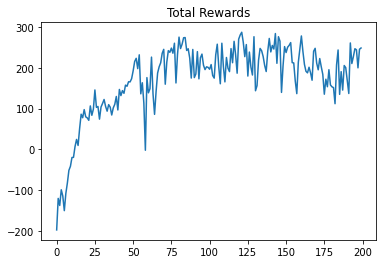

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

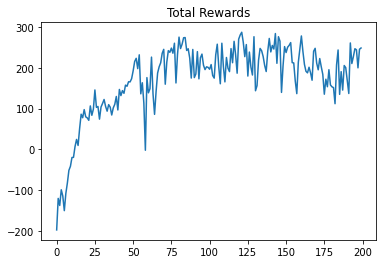

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(avg_total_rewards)
plt.title("Total Rewards")
plt.show()

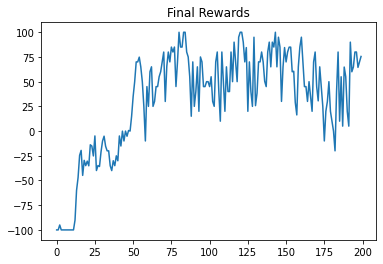

In [16]:
plt.plot(avg_final_rewards)
plt.title("Final Rewards")
plt.show()

In [27]:
%%capture
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

from IPython import display